<a href="https://colab.research.google.com/github/quanndm/kltn/blob/main/notebooks/training/liver_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [ ]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b main  https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 2957, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 2957 (delta 50), reused 32 (delta 14), pack-reused 2868 (from 2)
Receiving objects: 100% (2957/2957), 63.78 MiB | 12.44 MiB/s, done.
Resolving deltas: 100% (2040/2040), done.


In [2]:
from kltn.init.install_dependencies import install_packages, load_config
install_packages("./kltn")
config = load_config("./kltn/parameters.yaml")

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import json

from kltn import *
from kltn.datasets.get_datasets import get_datasets_lits
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import  trainer_stage1
from kltn.utils.metrics import  DiceMetric, TverskyLossWSigmoid, DiceLossWSigmoid
from kltn.models.model_factory import ModelFactory
from kltn.utils.visualize_results import visualize_results_stage_1
from kltn.processing.preprocessing import resize_crop_to_bbox_size, uncrop_to_full_image

In [4]:
drive.flush_and_unmount()
drive.mount("/content/gdrive")

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/gdrive


In [5]:
LOGGER = init_logger(config["log_path"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS(dir_name=config["source_folder_lits"])

0.00% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 1) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
1.64% complete (down: 22780.6 kB/s up: 666.2 kB/s peers: 10) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.p

## Load data

In [7]:
full_train_dataset, val_dataset = get_datasets_lits(source_folder=config["source_folder_lits"], seed=123, fold_number=2, mode="liver")
print(len(full_train_dataset), len(val_dataset))

105 26


In [8]:
train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=1, shuffle=True,
                                           num_workers=2, pin_memory=True, drop_last=True,  prefetch_factor=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False,
                                         pin_memory=True, num_workers=2,  prefetch_factor=2)

## visualize

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_sample(image_tensor, label_tensor):
    image_np = image_tensor.squeeze().cpu().numpy()
    label_np = label_tensor.squeeze().cpu().numpy()

    slide_index = image_np.shape[0] // 2

    # Lấy slice tại slice_index
    image_slice = image_np[slide_index, :, :]
    label_slice = label_np[slide_index, :, :]

    # Vẽ ảnh
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(image_slice, cmap='gray')
    axes[0].set_title("Image Slice")
    axes[0].axis('off')

    axes[1].imshow(label_slice, cmap='gray')
    axes[1].set_title("Label Slice")
    axes[1].axis('off')

    plt.show()


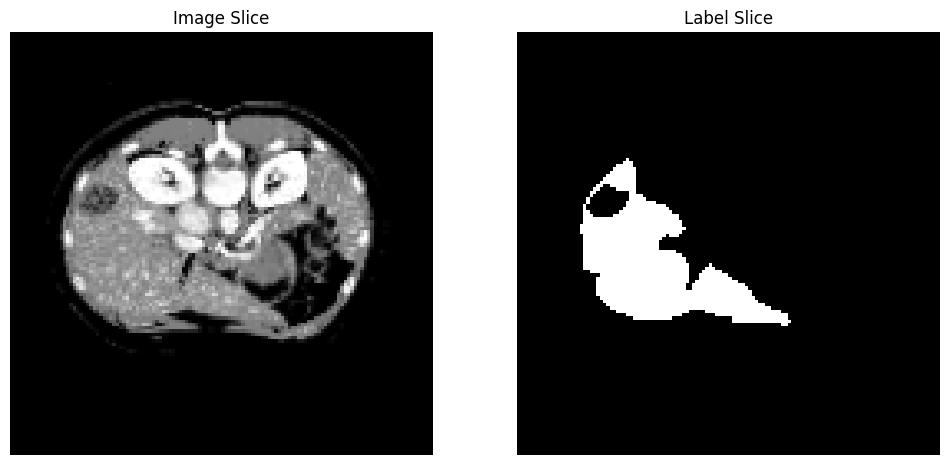

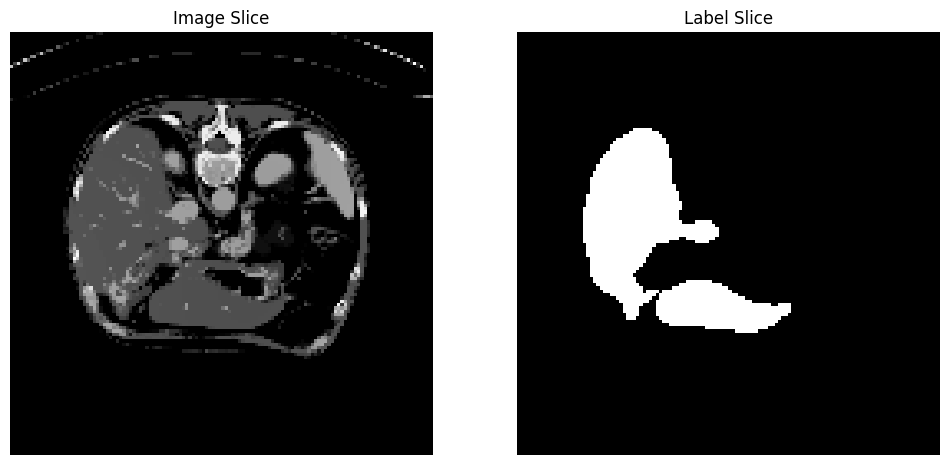

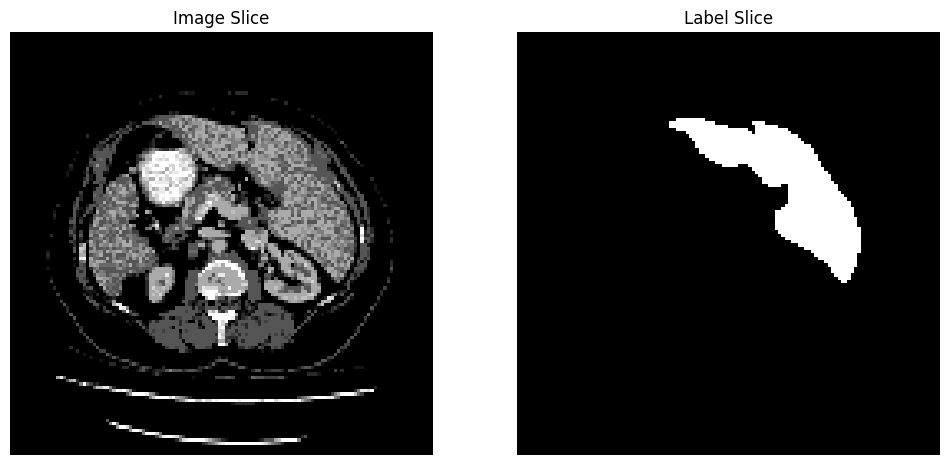

In [ ]:
i = 0
for batch in train_loader:
    i+=1
    image, label = batch["image"], batch["label"]
    plot_sample(image, label)

    if i == 3:
      break

## Training

In [9]:
model = ModelFactory.get_model("unet3d_resnext_ms_cot",in_channels=1, n_classes=1, n_channels=16).to(device)

In [10]:
criterion = DiceLossWSigmoid().to(device)

dice_acc = DiceMetric(include_background=False, reduction='mean_batch', get_not_nans=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=float(config["learning_rate"]), weight_decay=float(config["weight_decay"]))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(config["max_epochs"]), eta_min = float(config["eta_min"]))

In [11]:
LOGGER.info("[TRAINER] Start TRAIN process...")

(
    val_acc_max,
    best_epoch,
    dices_liver,
    loss_epochs,
    trains_epoch,
    ious_liver,
    precisions_liver,
    recalls_liver,
    time_tmp
) = trainer_stage1(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=criterion,
    acc_func=dice_acc,
    scheduler=scheduler,
    batch_size=config["batch_size"],
    max_epochs = config["max_epochs"],
    start_epoch = config["start_epoch"],
    val_every=config["val_every"],
    path_save_model=config["path_save_model_state"],
    logger=LOGGER,
    save_model=True,
    post_fix="liver_msa"
)

[TRAINER] Start TRAIN process...
INFO:kltn.utils.logger:[TRAINER] Start TRAIN process...

==============================Training epoch 1==============================
INFO:kltn.utils.logger:
==============================Training epoch 1==============================


Epoch 1/100 1/105 loss: 0.8969 time 25.24s
Epoch 1/100 2/105 loss: 0.8860 time 2.25s
Epoch 1/100 3/105 loss: 0.8708 time 2.31s
Epoch 1/100 4/105 loss: 0.8624 time 2.31s
Epoch 1/100 5/105 loss: 0.8541 time 12.88s
Epoch 1/100 6/105 loss: 0.8490 time 2.26s
Epoch 1/100 7/105 loss: 0.8432 time 6.47s
Epoch 1/100 8/105 loss: 0.8383 time 2.32s
Epoch 1/100 9/105 loss: 0.8334 time 3.97s
Epoch 1/100 10/105 loss: 0.8288 time 3.99s
Epoch 1/100 11/105 loss: 0.8243 time 2.31s
Epoch 1/100 12/105 loss: 0.8211 time 4.75s
Epoch 1/100 13/105 loss: 0.8179 time 3.79s
Epoch 1/100 14/105 loss: 0.8150 time 3.01s
Epoch 1/100 15/105 loss: 0.8121 time 2.29s
Epoch 1/100 16/105 loss: 0.8101 time 2.39s
Epoch 1/100 17/105 loss: 0.8076 time 2.93s
Epoch 1/100 18/105 loss: 0.8050 time 2.40s
Epoch 1/100 19/105 loss: 0.8023 time 2.67s
Epoch 1/100 20/105 loss: 0.7841 time 10.96s
Epoch 1/100 21/105 loss: 0.7819 time 2.39s
Epoch 1/100 22/105 loss: 0.7704 time 2.42s
Epoch 1/100 23/105 loss: 0.7479 time 4.01s
Epoch 1/100 24/10

Final training epochs: 1/100 ---[loss: 0.3468] ---[time 491.65s]
INFO:kltn.utils.logger:Final training epochs: 1/100 ---[loss: 0.3468] ---[time 491.65s]

********************Epoch 1 Validation********************
INFO:kltn.utils.logger:
********************Epoch 1 Validation********************


Epoch 1/100 105/105 loss: 0.3468 time 2.62s


Val 1/100 1/26, Dice_Liver: 0.411438, time 19.63s
INFO:kltn.utils.logger:Val 1/100 1/26, Dice_Liver: 0.411438, time 19.63s
Val 1/100 2/26, Dice_Liver: 0.590668, time 0.37s
INFO:kltn.utils.logger:Val 1/100 2/26, Dice_Liver: 0.590668, time 0.37s
Val 1/100 3/26, Dice_Liver: 0.650855, time 4.12s
INFO:kltn.utils.logger:Val 1/100 3/26, Dice_Liver: 0.650855, time 4.12s
Val 1/100 4/26, Dice_Liver: 0.696710, time 0.37s
INFO:kltn.utils.logger:Val 1/100 4/26, Dice_Liver: 0.696710, time 0.37s
Val 1/100 5/26, Dice_Liver: 0.597322, time 8.97s
INFO:kltn.utils.logger:Val 1/100 5/26, Dice_Liver: 0.597322, time 8.97s
Val 1/100 6/26, Dice_Liver: 0.868922, time 0.38s
INFO:kltn.utils.logger:Val 1/100 6/26, Dice_Liver: 0.868922, time 0.38s
Val 1/100 7/26, Dice_Liver: 0.616979, time 17.14s
INFO:kltn.utils.logger:Val 1/100 7/26, Dice_Liver: 0.616979, time 17.14s
Val 1/100 8/26, Dice_Liver: 0.796356, time 0.39s
INFO:kltn.utils.logger:Val 1/100 8/26, Dice_Liver: 0.796356, time 0.39s
Val 1/100 9/26, Dice_Liver: 

New best (0.000000 --> 0.566336). At epoch 1


Epoch 1/100 ---[loss: 0.3468] ---[val_dice: 0.566336] ---[time 113.36s]
INFO:kltn.utils.logger:Epoch 1/100 ---[loss: 0.3468] ---[val_dice: 0.566336] ---[time 113.36s]

==============================Training epoch 2==============================
INFO:kltn.utils.logger:
==============================Training epoch 2==============================


Epoch 2/100 1/105 loss: 0.1054 time 6.08s
Epoch 2/100 2/105 loss: 0.1391 time 2.45s
Epoch 2/100 3/105 loss: 0.1401 time 4.84s
Epoch 2/100 4/105 loss: 0.1336 time 2.48s
Epoch 2/100 5/105 loss: 0.1400 time 7.82s
Epoch 2/100 6/105 loss: 0.1457 time 5.67s
Epoch 2/100 7/105 loss: 0.1373 time 5.42s
Epoch 2/100 8/105 loss: 0.2131 time 2.40s
Epoch 2/100 9/105 loss: 0.2337 time 2.39s
Epoch 2/100 10/105 loss: 0.2359 time 2.43s
Epoch 2/100 11/105 loss: 0.2296 time 10.92s
Epoch 2/100 12/105 loss: 0.2226 time 2.39s
Epoch 2/100 13/105 loss: 0.2122 time 2.45s
Epoch 2/100 14/105 loss: 0.2231 time 2.43s
Epoch 2/100 15/105 loss: 0.2273 time 2.42s
Epoch 2/100 16/105 loss: 0.2208 time 2.42s
Epoch 2/100 17/105 loss: 0.2180 time 2.41s
Epoch 2/100 18/105 loss: 0.2181 time 7.72s
Epoch 2/100 19/105 loss: 0.2215 time 2.42s
Epoch 2/100 20/105 loss: 0.2187 time 2.41s
Epoch 2/100 21/105 loss: 0.2180 time 2.47s
Epoch 2/100 22/105 loss: 0.2157 time 10.83s
Epoch 2/100 23/105 loss: 0.2145 time 2.39s
Epoch 2/100 24/105

Final training epochs: 2/100 ---[loss: 0.1668] ---[time 480.58s]
INFO:kltn.utils.logger:Final training epochs: 2/100 ---[loss: 0.1668] ---[time 480.58s]

********************Epoch 2 Validation********************
INFO:kltn.utils.logger:
********************Epoch 2 Validation********************


Epoch 2/100 105/105 loss: 0.1668 time 2.41s


Val 2/100 1/26, Dice_Liver: 0.713807, time 17.16s
INFO:kltn.utils.logger:Val 2/100 1/26, Dice_Liver: 0.713807, time 17.16s
Val 2/100 2/26, Dice_Liver: 0.721464, time 0.38s
INFO:kltn.utils.logger:Val 2/100 2/26, Dice_Liver: 0.721464, time 0.38s
Val 2/100 3/26, Dice_Liver: 0.744391, time 6.07s
INFO:kltn.utils.logger:Val 2/100 3/26, Dice_Liver: 0.744391, time 6.07s
Val 2/100 4/26, Dice_Liver: 0.858691, time 0.37s
INFO:kltn.utils.logger:Val 2/100 4/26, Dice_Liver: 0.858691, time 0.37s
Val 2/100 5/26, Dice_Liver: 0.899689, time 9.15s
INFO:kltn.utils.logger:Val 2/100 5/26, Dice_Liver: 0.899689, time 9.15s
Val 2/100 6/26, Dice_Liver: 0.899239, time 0.37s
INFO:kltn.utils.logger:Val 2/100 6/26, Dice_Liver: 0.899239, time 0.37s
Val 2/100 7/26, Dice_Liver: 0.864814, time 16.92s
INFO:kltn.utils.logger:Val 2/100 7/26, Dice_Liver: 0.864814, time 16.92s
Val 2/100 8/26, Dice_Liver: 0.883090, time 0.38s
INFO:kltn.utils.logger:Val 2/100 8/26, Dice_Liver: 0.883090, time 0.38s
Val 2/100 9/26, Dice_Liver: 

New best (0.566336 --> 0.809447). At epoch 2



==============================Training epoch 3==============================
INFO:kltn.utils.logger:
==============================Training epoch 3==============================


Epoch 3/100 1/105 loss: 0.1594 time 5.07s
Epoch 3/100 2/105 loss: 0.1887 time 11.06s
Epoch 3/100 3/105 loss: 0.1652 time 2.42s
Epoch 3/100 4/105 loss: 0.1606 time 2.43s
Epoch 3/100 5/105 loss: 0.1666 time 5.11s
Epoch 3/100 6/105 loss: 0.1523 time 2.53s
Epoch 3/100 7/105 loss: 0.1608 time 10.07s
Epoch 3/100 8/105 loss: 0.1547 time 2.42s
Epoch 3/100 9/105 loss: 0.1473 time 2.48s
Epoch 3/100 10/105 loss: 0.1424 time 3.12s
Epoch 3/100 11/105 loss: 0.1367 time 2.43s
Epoch 3/100 12/105 loss: 0.1422 time 6.17s
Epoch 3/100 13/105 loss: 0.1397 time 4.60s
Epoch 3/100 14/105 loss: 0.1346 time 2.43s
Epoch 3/100 15/105 loss: 0.1381 time 2.41s
Epoch 3/100 16/105 loss: 0.1345 time 7.56s
Epoch 3/100 17/105 loss: 0.1343 time 3.21s
Epoch 3/100 18/105 loss: 0.1313 time 12.23s
Epoch 3/100 19/105 loss: 0.1306 time 2.39s
Epoch 3/100 20/105 loss: 0.1291 time 4.49s
Epoch 3/100 21/105 loss: 0.1274 time 11.59s
Epoch 3/100 22/105 loss: 0.1274 time 2.41s
Epoch 3/100 23/105 loss: 0.1267 time 12.86s
Epoch 3/100 24/

Final training epochs: 3/100 ---[loss: 0.1278] ---[time 492.66s]
INFO:kltn.utils.logger:Final training epochs: 3/100 ---[loss: 0.1278] ---[time 492.66s]

********************Epoch 3 Validation********************
INFO:kltn.utils.logger:
********************Epoch 3 Validation********************


Epoch 3/100 105/105 loss: 0.1278 time 7.27s


Val 3/100 1/26, Dice_Liver: 0.651300, time 17.40s
INFO:kltn.utils.logger:Val 3/100 1/26, Dice_Liver: 0.651300, time 17.40s
Val 3/100 2/26, Dice_Liver: 0.630530, time 0.37s
INFO:kltn.utils.logger:Val 3/100 2/26, Dice_Liver: 0.630530, time 0.37s
Val 3/100 3/26, Dice_Liver: 0.728578, time 6.68s
INFO:kltn.utils.logger:Val 3/100 3/26, Dice_Liver: 0.728578, time 6.68s
Val 3/100 4/26, Dice_Liver: 0.782410, time 0.37s
INFO:kltn.utils.logger:Val 3/100 4/26, Dice_Liver: 0.782410, time 0.37s
Val 3/100 5/26, Dice_Liver: 0.871887, time 8.28s
INFO:kltn.utils.logger:Val 3/100 5/26, Dice_Liver: 0.871887, time 8.28s
Val 3/100 6/26, Dice_Liver: 0.862420, time 0.37s
INFO:kltn.utils.logger:Val 3/100 6/26, Dice_Liver: 0.862420, time 0.37s
Val 3/100 7/26, Dice_Liver: 0.880812, time 18.04s
INFO:kltn.utils.logger:Val 3/100 7/26, Dice_Liver: 0.880812, time 18.04s
Val 3/100 8/26, Dice_Liver: 0.840786, time 0.38s
INFO:kltn.utils.logger:Val 3/100 8/26, Dice_Liver: 0.840786, time 0.38s
Val 3/100 9/26, Dice_Liver: 

Epoch 4/100 1/105 loss: 0.1127 time 3.73s
Epoch 4/100 2/105 loss: 0.1129 time 13.75s
Epoch 4/100 3/105 loss: 0.1106 time 2.43s
Epoch 4/100 4/105 loss: 0.1073 time 4.87s
Epoch 4/100 5/105 loss: 0.1007 time 3.16s
Epoch 4/100 6/105 loss: 0.0944 time 2.45s
Epoch 4/100 7/105 loss: 0.1033 time 2.43s
Epoch 4/100 8/105 loss: 0.1027 time 9.07s
Epoch 4/100 9/105 loss: 0.1149 time 4.32s
Epoch 4/100 10/105 loss: 0.1127 time 13.57s
Epoch 4/100 11/105 loss: 0.1127 time 2.39s
Epoch 4/100 12/105 loss: 0.1144 time 6.66s
Epoch 4/100 13/105 loss: 0.1134 time 2.41s
Epoch 4/100 14/105 loss: 0.1105 time 5.34s
Epoch 4/100 15/105 loss: 0.1081 time 2.48s
Epoch 4/100 16/105 loss: 0.1072 time 13.44s
Epoch 4/100 17/105 loss: 0.1047 time 2.41s
Epoch 4/100 18/105 loss: 0.1060 time 2.46s
Epoch 4/100 19/105 loss: 0.1051 time 2.45s
Epoch 4/100 20/105 loss: 0.1058 time 2.45s
Epoch 4/100 21/105 loss: 0.1048 time 2.43s
Epoch 4/100 22/105 loss: 0.1043 time 4.92s
Epoch 4/100 23/105 loss: 0.1046 time 9.33s
Epoch 4/100 24/10

Final training epochs: 4/100 ---[loss: 0.1053] ---[time 475.28s]
INFO:kltn.utils.logger:Final training epochs: 4/100 ---[loss: 0.1053] ---[time 475.28s]

********************Epoch 4 Validation********************
INFO:kltn.utils.logger:
********************Epoch 4 Validation********************


Epoch 4/100 105/105 loss: 0.1053 time 2.39s


Val 4/100 1/26, Dice_Liver: 0.826622, time 18.65s
INFO:kltn.utils.logger:Val 4/100 1/26, Dice_Liver: 0.826622, time 18.65s
Val 4/100 2/26, Dice_Liver: 0.734631, time 0.37s
INFO:kltn.utils.logger:Val 4/100 2/26, Dice_Liver: 0.734631, time 0.37s
Val 4/100 3/26, Dice_Liver: 0.770518, time 6.92s
INFO:kltn.utils.logger:Val 4/100 3/26, Dice_Liver: 0.770518, time 6.92s
Val 4/100 4/26, Dice_Liver: 0.892342, time 0.38s
INFO:kltn.utils.logger:Val 4/100 4/26, Dice_Liver: 0.892342, time 0.38s
Val 4/100 5/26, Dice_Liver: 0.882966, time 8.52s
INFO:kltn.utils.logger:Val 4/100 5/26, Dice_Liver: 0.882966, time 8.52s
Val 4/100 6/26, Dice_Liver: 0.901548, time 0.38s
INFO:kltn.utils.logger:Val 4/100 6/26, Dice_Liver: 0.901548, time 0.38s
Val 4/100 7/26, Dice_Liver: 0.814723, time 18.76s
INFO:kltn.utils.logger:Val 4/100 7/26, Dice_Liver: 0.814723, time 18.76s
Val 4/100 8/26, Dice_Liver: 0.881529, time 0.38s
INFO:kltn.utils.logger:Val 4/100 8/26, Dice_Liver: 0.881529, time 0.38s
Val 4/100 9/26, Dice_Liver: 

New best (0.809447 --> 0.826796). At epoch 4
Epoch 5/100 1/105 loss: 0.2337 time 6.41s
Epoch 5/100 2/105 loss: 0.1553 time 6.89s
Epoch 5/100 3/105 loss: 0.1340 time 2.42s
Epoch 5/100 4/105 loss: 0.1316 time 2.49s
Epoch 5/100 5/105 loss: 0.1283 time 14.36s
Epoch 5/100 6/105 loss: 0.1256 time 2.45s
Epoch 5/100 7/105 loss: 0.1292 time 7.04s
Epoch 5/100 8/105 loss: 0.1272 time 2.43s
Epoch 5/100 9/105 loss: 0.1245 time 3.90s
Epoch 5/100 10/105 loss: 0.1231 time 2.47s
Epoch 5/100 11/105 loss: 0.1184 time 2.42s
Epoch 5/100 12/105 loss: 0.1181 time 2.44s
Epoch 5/100 13/105 loss: 0.1190 time 2.42s
Epoch 5/100 14/105 loss: 0.1189 time 2.47s
Epoch 5/100 15/105 loss: 0.1180 time 16.47s
Epoch 5/100 16/105 loss: 0.1140 time 2.38s
Epoch 5/100 17/105 loss: 0.1115 time 2.42s
Epoch 5/100 18/105 loss: 0.1093 time 10.70s
Epoch 5/100 19/105 loss: 0.1092 time 2.40s
Epoch 5/100 20/105 loss: 0.1080 time 3.13s
Epoch 5/100 21/105 loss: 0.1080 time 6.20s
Epoch 5/100 22/105 loss: 0.1105 time 2.47s
Epoch 5/100 23/

Final training epochs: 5/100 ---[loss: 0.1010] ---[time 491.87s]
INFO:kltn.utils.logger:Final training epochs: 5/100 ---[loss: 0.1010] ---[time 491.87s]

********************Epoch 5 Validation********************
INFO:kltn.utils.logger:
********************Epoch 5 Validation********************


Epoch 5/100 105/105 loss: 0.1010 time 2.41s


Val 5/100 1/26, Dice_Liver: 0.571007, time 17.47s
INFO:kltn.utils.logger:Val 5/100 1/26, Dice_Liver: 0.571007, time 17.47s
Val 5/100 2/26, Dice_Liver: 0.663851, time 0.37s
INFO:kltn.utils.logger:Val 5/100 2/26, Dice_Liver: 0.663851, time 0.37s
Val 5/100 3/26, Dice_Liver: 0.211871, time 6.64s
INFO:kltn.utils.logger:Val 5/100 3/26, Dice_Liver: 0.211871, time 6.64s
Val 5/100 4/26, Dice_Liver: 0.866034, time 0.37s
INFO:kltn.utils.logger:Val 5/100 4/26, Dice_Liver: 0.866034, time 0.37s
Val 5/100 5/26, Dice_Liver: 0.743149, time 9.34s
INFO:kltn.utils.logger:Val 5/100 5/26, Dice_Liver: 0.743149, time 9.34s
Val 5/100 6/26, Dice_Liver: 0.886639, time 0.37s
INFO:kltn.utils.logger:Val 5/100 6/26, Dice_Liver: 0.886639, time 0.37s
Val 5/100 7/26, Dice_Liver: 0.683194, time 19.03s
INFO:kltn.utils.logger:Val 5/100 7/26, Dice_Liver: 0.683194, time 19.03s
Val 5/100 8/26, Dice_Liver: 0.874283, time 0.39s
INFO:kltn.utils.logger:Val 5/100 8/26, Dice_Liver: 0.874283, time 0.39s
Val 5/100 9/26, Dice_Liver: 

Epoch 6/100 1/105 loss: 0.0730 time 11.18s
Epoch 6/100 2/105 loss: 0.0820 time 2.38s
Epoch 6/100 3/105 loss: 0.0925 time 5.37s
Epoch 6/100 4/105 loss: 0.0895 time 2.46s
Epoch 6/100 5/105 loss: 0.0856 time 8.52s
Epoch 6/100 6/105 loss: 0.0890 time 2.41s
Epoch 6/100 7/105 loss: 0.0873 time 2.51s
Epoch 6/100 8/105 loss: 0.0854 time 2.49s
Epoch 6/100 9/105 loss: 0.0911 time 3.14s
Epoch 6/100 10/105 loss: 0.0902 time 2.43s
Epoch 6/100 11/105 loss: 0.0870 time 8.06s
Epoch 6/100 12/105 loss: 0.0887 time 2.41s
Epoch 6/100 13/105 loss: 0.0890 time 17.81s
Epoch 6/100 14/105 loss: 0.0868 time 2.38s
Epoch 6/100 15/105 loss: 0.0868 time 2.42s
Epoch 6/100 16/105 loss: 0.0860 time 2.40s
Epoch 6/100 17/105 loss: 0.0852 time 5.61s
Epoch 6/100 18/105 loss: 0.0848 time 2.41s
Epoch 6/100 19/105 loss: 0.0850 time 11.82s
Epoch 6/100 20/105 loss: 0.0847 time 2.41s
Epoch 6/100 21/105 loss: 0.0836 time 8.69s
Epoch 6/100 22/105 loss: 0.0837 time 2.42s
Epoch 6/100 23/105 loss: 0.0862 time 2.43s
Epoch 6/100 24/10

Final training epochs: 6/100 ---[loss: 0.0965] ---[time 516.72s]
INFO:kltn.utils.logger:Final training epochs: 6/100 ---[loss: 0.0965] ---[time 516.72s]

********************Epoch 6 Validation********************
INFO:kltn.utils.logger:
********************Epoch 6 Validation********************


Epoch 6/100 105/105 loss: 0.0965 time 2.37s


Val 6/100 1/26, Dice_Liver: 0.837452, time 14.47s
INFO:kltn.utils.logger:Val 6/100 1/26, Dice_Liver: 0.837452, time 14.47s
Val 6/100 2/26, Dice_Liver: 0.734215, time 0.37s
INFO:kltn.utils.logger:Val 6/100 2/26, Dice_Liver: 0.734215, time 0.37s
Val 6/100 3/26, Dice_Liver: 0.257685, time 6.55s
INFO:kltn.utils.logger:Val 6/100 3/26, Dice_Liver: 0.257685, time 6.55s
Val 6/100 4/26, Dice_Liver: 0.895974, time 0.37s
INFO:kltn.utils.logger:Val 6/100 4/26, Dice_Liver: 0.895974, time 0.37s
Val 6/100 5/26, Dice_Liver: 0.712172, time 10.18s
INFO:kltn.utils.logger:Val 6/100 5/26, Dice_Liver: 0.712172, time 10.18s
Val 6/100 6/26, Dice_Liver: 0.908027, time 0.37s
INFO:kltn.utils.logger:Val 6/100 6/26, Dice_Liver: 0.908027, time 0.37s
Val 6/100 7/26, Dice_Liver: 0.856046, time 20.06s
INFO:kltn.utils.logger:Val 6/100 7/26, Dice_Liver: 0.856046, time 20.06s
Val 6/100 8/26, Dice_Liver: 0.919432, time 0.37s
INFO:kltn.utils.logger:Val 6/100 8/26, Dice_Liver: 0.919432, time 0.37s
Val 6/100 9/26, Dice_Liver

Epoch 7/100 1/105 loss: 0.0842 time 20.67s
Epoch 7/100 2/105 loss: 0.0799 time 2.38s
Epoch 7/100 3/105 loss: 0.0732 time 6.16s
Epoch 7/100 4/105 loss: 0.0763 time 2.44s
Epoch 7/100 5/105 loss: 0.0765 time 6.43s
Epoch 7/100 6/105 loss: 0.0849 time 2.40s
Epoch 7/100 7/105 loss: 0.0820 time 5.81s
Epoch 7/100 8/105 loss: 0.0795 time 2.41s
Epoch 7/100 9/105 loss: 0.0780 time 10.43s
Epoch 7/100 10/105 loss: 0.0799 time 2.47s
Epoch 7/100 11/105 loss: 0.0795 time 9.05s
Epoch 7/100 12/105 loss: 0.0817 time 2.46s
Epoch 7/100 13/105 loss: 0.0804 time 7.40s
Epoch 7/100 14/105 loss: 0.0812 time 2.42s
Epoch 7/100 15/105 loss: 0.0804 time 2.50s
Epoch 7/100 16/105 loss: 0.0799 time 2.49s
Epoch 7/100 17/105 loss: 0.0796 time 2.44s
Epoch 7/100 18/105 loss: 0.0815 time 2.46s
Epoch 7/100 19/105 loss: 0.0809 time 15.43s
Epoch 7/100 20/105 loss: 0.0793 time 2.38s
Epoch 7/100 21/105 loss: 0.0796 time 7.25s
Epoch 7/100 22/105 loss: 0.0788 time 2.39s
Epoch 7/100 23/105 loss: 0.0793 time 17.09s
Epoch 7/100 24/1

Final training epochs: 7/100 ---[loss: 0.0782] ---[time 509.91s]
INFO:kltn.utils.logger:Final training epochs: 7/100 ---[loss: 0.0782] ---[time 509.91s]

********************Epoch 7 Validation********************
INFO:kltn.utils.logger:
********************Epoch 7 Validation********************


Epoch 7/100 105/105 loss: 0.0782 time 7.47s


Val 7/100 1/26, Dice_Liver: 0.819441, time 17.53s
INFO:kltn.utils.logger:Val 7/100 1/26, Dice_Liver: 0.819441, time 17.53s
Val 7/100 2/26, Dice_Liver: 0.843744, time 0.37s
INFO:kltn.utils.logger:Val 7/100 2/26, Dice_Liver: 0.843744, time 0.37s
Val 7/100 3/26, Dice_Liver: 0.849963, time 7.18s
INFO:kltn.utils.logger:Val 7/100 3/26, Dice_Liver: 0.849963, time 7.18s
Val 7/100 4/26, Dice_Liver: 0.907127, time 0.37s
INFO:kltn.utils.logger:Val 7/100 4/26, Dice_Liver: 0.907127, time 0.37s
Val 7/100 5/26, Dice_Liver: 0.904079, time 9.23s
INFO:kltn.utils.logger:Val 7/100 5/26, Dice_Liver: 0.904079, time 9.23s
Val 7/100 6/26, Dice_Liver: 0.900141, time 0.38s
INFO:kltn.utils.logger:Val 7/100 6/26, Dice_Liver: 0.900141, time 0.38s
Val 7/100 7/26, Dice_Liver: 0.920496, time 19.06s
INFO:kltn.utils.logger:Val 7/100 7/26, Dice_Liver: 0.920496, time 19.06s
Val 7/100 8/26, Dice_Liver: 0.909988, time 0.38s
INFO:kltn.utils.logger:Val 7/100 8/26, Dice_Liver: 0.909988, time 0.38s
Val 7/100 9/26, Dice_Liver: 

New best (0.826796 --> 0.846452). At epoch 7
Epoch 8/100 1/105 loss: 0.0848 time 10.91s
Epoch 8/100 2/105 loss: 0.0717 time 2.72s
Epoch 8/100 3/105 loss: 0.0740 time 19.97s
Epoch 8/100 4/105 loss: 0.0768 time 2.45s
Epoch 8/100 5/105 loss: 0.0829 time 4.45s
Epoch 8/100 6/105 loss: 0.0795 time 2.45s
Epoch 8/100 7/105 loss: 0.0747 time 9.09s
Epoch 8/100 8/105 loss: 0.0731 time 2.44s
Epoch 8/100 9/105 loss: 0.0754 time 8.27s
Epoch 8/100 10/105 loss: 0.0843 time 2.41s
Epoch 8/100 11/105 loss: 0.0841 time 2.41s
Epoch 8/100 12/105 loss: 0.0876 time 2.51s
Epoch 8/100 13/105 loss: 0.0854 time 8.99s
Epoch 8/100 14/105 loss: 0.0830 time 2.69s
Epoch 8/100 15/105 loss: 0.0823 time 10.40s
Epoch 8/100 16/105 loss: 0.0809 time 2.39s
Epoch 8/100 17/105 loss: 0.0808 time 14.34s
Epoch 8/100 18/105 loss: 0.0800 time 2.40s
Epoch 8/100 19/105 loss: 0.0784 time 2.40s
Epoch 8/100 20/105 loss: 0.0769 time 5.75s
Epoch 8/100 21/105 loss: 0.0761 time 2.41s
Epoch 8/100 22/105 loss: 0.0750 time 12.18s
Epoch 8/100 2

Final training epochs: 8/100 ---[loss: 0.0741] ---[time 508.06s]
INFO:kltn.utils.logger:Final training epochs: 8/100 ---[loss: 0.0741] ---[time 508.06s]

********************Epoch 8 Validation********************
INFO:kltn.utils.logger:
********************Epoch 8 Validation********************


Epoch 8/100 105/105 loss: 0.0741 time 2.41s


Val 8/100 1/26, Dice_Liver: 0.812520, time 17.22s
INFO:kltn.utils.logger:Val 8/100 1/26, Dice_Liver: 0.812520, time 17.22s
Val 8/100 2/26, Dice_Liver: 0.726205, time 0.37s
INFO:kltn.utils.logger:Val 8/100 2/26, Dice_Liver: 0.726205, time 0.37s
Val 8/100 3/26, Dice_Liver: 0.864300, time 7.45s
INFO:kltn.utils.logger:Val 8/100 3/26, Dice_Liver: 0.864300, time 7.45s
Val 8/100 4/26, Dice_Liver: 0.916353, time 0.37s
INFO:kltn.utils.logger:Val 8/100 4/26, Dice_Liver: 0.916353, time 0.37s
Val 8/100 5/26, Dice_Liver: 0.909898, time 9.73s
INFO:kltn.utils.logger:Val 8/100 5/26, Dice_Liver: 0.909898, time 9.73s
Val 8/100 6/26, Dice_Liver: 0.898409, time 0.38s
INFO:kltn.utils.logger:Val 8/100 6/26, Dice_Liver: 0.898409, time 0.38s
Val 8/100 7/26, Dice_Liver: 0.925396, time 19.49s
INFO:kltn.utils.logger:Val 8/100 7/26, Dice_Liver: 0.925396, time 19.49s
Val 8/100 8/26, Dice_Liver: 0.914367, time 0.38s
INFO:kltn.utils.logger:Val 8/100 8/26, Dice_Liver: 0.914367, time 0.38s
Val 8/100 9/26, Dice_Liver: 

New best (0.846452 --> 0.851735). At epoch 8
Epoch 9/100 1/105 loss: 0.0781 time 19.69s
Epoch 9/100 2/105 loss: 0.0910 time 2.36s
Epoch 9/100 3/105 loss: 0.0885 time 2.44s
Epoch 9/100 4/105 loss: 0.0876 time 2.43s
Epoch 9/100 5/105 loss: 0.0817 time 2.47s
Epoch 9/100 6/105 loss: 0.0757 time 2.46s
Epoch 9/100 7/105 loss: 0.0736 time 7.40s
Epoch 9/100 8/105 loss: 0.0719 time 2.43s
Epoch 9/100 9/105 loss: 0.0694 time 5.29s
Epoch 9/100 10/105 loss: 0.0704 time 3.18s
Epoch 9/100 11/105 loss: 0.0712 time 9.50s
Epoch 9/100 12/105 loss: 0.0694 time 2.41s
Epoch 9/100 13/105 loss: 0.0697 time 10.81s
Epoch 9/100 14/105 loss: 0.0695 time 2.41s
Epoch 9/100 15/105 loss: 0.0688 time 2.76s
Epoch 9/100 16/105 loss: 0.0681 time 2.47s
Epoch 9/100 17/105 loss: 0.0664 time 2.49s
Epoch 9/100 18/105 loss: 0.0656 time 8.68s
Epoch 9/100 19/105 loss: 0.0653 time 2.43s
Epoch 9/100 20/105 loss: 0.0648 time 7.21s
Epoch 9/100 21/105 loss: 0.0649 time 2.39s
Epoch 9/100 22/105 loss: 0.0643 time 3.49s
Epoch 9/100 23/1

Final training epochs: 9/100 ---[loss: 0.0659] ---[time 496.64s]
INFO:kltn.utils.logger:Final training epochs: 9/100 ---[loss: 0.0659] ---[time 496.64s]

********************Epoch 9 Validation********************
INFO:kltn.utils.logger:
********************Epoch 9 Validation********************


Epoch 9/100 105/105 loss: 0.0659 time 2.40s


Val 9/100 1/26, Dice_Liver: 0.916691, time 16.77s
INFO:kltn.utils.logger:Val 9/100 1/26, Dice_Liver: 0.916691, time 16.77s
Val 9/100 2/26, Dice_Liver: 0.758999, time 0.37s
INFO:kltn.utils.logger:Val 9/100 2/26, Dice_Liver: 0.758999, time 0.37s
Val 9/100 3/26, Dice_Liver: 0.688208, time 6.80s
INFO:kltn.utils.logger:Val 9/100 3/26, Dice_Liver: 0.688208, time 6.80s
Val 9/100 4/26, Dice_Liver: 0.870149, time 0.37s
INFO:kltn.utils.logger:Val 9/100 4/26, Dice_Liver: 0.870149, time 0.37s
Val 9/100 5/26, Dice_Liver: 0.906998, time 9.57s
INFO:kltn.utils.logger:Val 9/100 5/26, Dice_Liver: 0.906998, time 9.57s
Val 9/100 6/26, Dice_Liver: 0.897538, time 0.37s
INFO:kltn.utils.logger:Val 9/100 6/26, Dice_Liver: 0.897538, time 0.37s
Val 9/100 7/26, Dice_Liver: 0.869002, time 18.18s
INFO:kltn.utils.logger:Val 9/100 7/26, Dice_Liver: 0.869002, time 18.18s
Val 9/100 8/26, Dice_Liver: 0.914685, time 0.38s
INFO:kltn.utils.logger:Val 9/100 8/26, Dice_Liver: 0.914685, time 0.38s
Val 9/100 9/26, Dice_Liver: 

Epoch 10/100 1/105 loss: 0.0710 time 5.61s
Epoch 10/100 2/105 loss: 0.0659 time 2.43s
Epoch 10/100 3/105 loss: 0.0941 time 2.40s
Epoch 10/100 4/105 loss: 0.0844 time 11.12s
Epoch 10/100 5/105 loss: 0.0796 time 2.44s
Epoch 10/100 6/105 loss: 0.0776 time 2.43s
Epoch 10/100 7/105 loss: 0.0794 time 2.41s
Epoch 10/100 8/105 loss: 0.0895 time 13.50s
Epoch 10/100 9/105 loss: 0.0861 time 2.46s
Epoch 10/100 10/105 loss: 0.0833 time 3.29s
Epoch 10/100 11/105 loss: 0.0818 time 2.44s
Epoch 10/100 12/105 loss: 0.0795 time 2.50s
Epoch 10/100 13/105 loss: 0.0778 time 7.32s
Epoch 10/100 14/105 loss: 0.0773 time 2.43s
Epoch 10/100 15/105 loss: 0.0778 time 9.19s
Epoch 10/100 16/105 loss: 0.0776 time 2.45s
Epoch 10/100 17/105 loss: 0.0777 time 3.55s
Epoch 10/100 18/105 loss: 0.0759 time 2.45s
Epoch 10/100 19/105 loss: 0.0745 time 10.47s
Epoch 10/100 20/105 loss: 0.0744 time 2.43s
Epoch 10/100 21/105 loss: 0.0807 time 8.97s
Epoch 10/100 22/105 loss: 0.0796 time 2.40s
Epoch 10/100 23/105 loss: 0.0790 time 

Final training epochs: 10/100 ---[loss: 0.0918] ---[time 487.18s]
INFO:kltn.utils.logger:Final training epochs: 10/100 ---[loss: 0.0918] ---[time 487.18s]

********************Epoch 10 Validation********************
INFO:kltn.utils.logger:
********************Epoch 10 Validation********************


Epoch 10/100 105/105 loss: 0.0918 time 2.44s


Val 10/100 1/26, Dice_Liver: 0.832995, time 18.02s
INFO:kltn.utils.logger:Val 10/100 1/26, Dice_Liver: 0.832995, time 18.02s
Val 10/100 2/26, Dice_Liver: 0.756051, time 0.37s
INFO:kltn.utils.logger:Val 10/100 2/26, Dice_Liver: 0.756051, time 0.37s
Val 10/100 3/26, Dice_Liver: 0.838344, time 6.57s
INFO:kltn.utils.logger:Val 10/100 3/26, Dice_Liver: 0.838344, time 6.57s
Val 10/100 4/26, Dice_Liver: 0.910050, time 0.38s
INFO:kltn.utils.logger:Val 10/100 4/26, Dice_Liver: 0.910050, time 0.38s
Val 10/100 5/26, Dice_Liver: 0.916812, time 10.26s
INFO:kltn.utils.logger:Val 10/100 5/26, Dice_Liver: 0.916812, time 10.26s
Val 10/100 6/26, Dice_Liver: 0.914109, time 0.37s
INFO:kltn.utils.logger:Val 10/100 6/26, Dice_Liver: 0.914109, time 0.37s
Val 10/100 7/26, Dice_Liver: 0.902822, time 19.19s
INFO:kltn.utils.logger:Val 10/100 7/26, Dice_Liver: 0.902822, time 19.19s
Val 10/100 8/26, Dice_Liver: 0.916585, time 0.38s
INFO:kltn.utils.logger:Val 10/100 8/26, Dice_Liver: 0.916585, time 0.38s
Val 10/100

New best (0.851735 --> 0.867013). At epoch 10



==============================Training epoch 11==============================
INFO:kltn.utils.logger:
==============================Training epoch 11==============================


Epoch 11/100 1/105 loss: 0.0613 time 12.09s
Epoch 11/100 2/105 loss: 0.0759 time 2.39s
Epoch 11/100 3/105 loss: 0.0729 time 4.03s
Epoch 11/100 4/105 loss: 0.0678 time 2.44s
Epoch 11/100 5/105 loss: 0.0727 time 13.91s
Epoch 11/100 6/105 loss: 0.0722 time 2.44s
Epoch 11/100 7/105 loss: 0.0766 time 6.84s
Epoch 11/100 8/105 loss: 0.0741 time 2.47s
Epoch 11/100 9/105 loss: 0.0731 time 9.21s
Epoch 11/100 10/105 loss: 0.0730 time 2.43s
Epoch 11/100 11/105 loss: 0.0711 time 9.38s
Epoch 11/100 12/105 loss: 0.0714 time 2.44s
Epoch 11/100 13/105 loss: 0.0708 time 13.65s
Epoch 11/100 14/105 loss: 0.0701 time 2.41s
Epoch 11/100 15/105 loss: 0.0726 time 8.71s
Epoch 11/100 16/105 loss: 0.0723 time 2.41s
Epoch 11/100 17/105 loss: 0.0732 time 2.41s
Epoch 11/100 18/105 loss: 0.0718 time 2.43s
Epoch 11/100 19/105 loss: 0.0717 time 3.20s
Epoch 11/100 20/105 loss: 0.0718 time 2.45s
Epoch 11/100 21/105 loss: 0.0715 time 13.48s
Epoch 11/100 22/105 loss: 0.0709 time 2.42s
Epoch 11/100 23/105 loss: 0.0719 time

Final training epochs: 11/100 ---[loss: 0.0738] ---[time 493.37s]
INFO:kltn.utils.logger:Final training epochs: 11/100 ---[loss: 0.0738] ---[time 493.37s]

********************Epoch 11 Validation********************
INFO:kltn.utils.logger:
********************Epoch 11 Validation********************


Epoch 11/100 105/105 loss: 0.0738 time 2.38s


Val 11/100 1/26, Dice_Liver: 0.885835, time 18.64s
INFO:kltn.utils.logger:Val 11/100 1/26, Dice_Liver: 0.885835, time 18.64s
Val 11/100 2/26, Dice_Liver: 0.759618, time 0.37s
INFO:kltn.utils.logger:Val 11/100 2/26, Dice_Liver: 0.759618, time 0.37s
Val 11/100 3/26, Dice_Liver: 0.801026, time 6.66s
INFO:kltn.utils.logger:Val 11/100 3/26, Dice_Liver: 0.801026, time 6.66s
Val 11/100 4/26, Dice_Liver: 0.913195, time 0.37s
INFO:kltn.utils.logger:Val 11/100 4/26, Dice_Liver: 0.913195, time 0.37s
Val 11/100 5/26, Dice_Liver: 0.915411, time 10.28s
INFO:kltn.utils.logger:Val 11/100 5/26, Dice_Liver: 0.915411, time 10.28s
Val 11/100 6/26, Dice_Liver: 0.923388, time 0.37s
INFO:kltn.utils.logger:Val 11/100 6/26, Dice_Liver: 0.923388, time 0.37s
Val 11/100 7/26, Dice_Liver: 0.908979, time 18.47s
INFO:kltn.utils.logger:Val 11/100 7/26, Dice_Liver: 0.908979, time 18.47s
Val 11/100 8/26, Dice_Liver: 0.922141, time 0.38s
INFO:kltn.utils.logger:Val 11/100 8/26, Dice_Liver: 0.922141, time 0.38s
Val 11/100

Epoch 12/100 1/105 loss: 0.0542 time 5.04s
Epoch 12/100 2/105 loss: 0.0623 time 13.26s
Epoch 12/100 3/105 loss: 0.0571 time 2.36s
Epoch 12/100 4/105 loss: 0.0739 time 7.77s
Epoch 12/100 5/105 loss: 0.0704 time 7.48s
Epoch 12/100 6/105 loss: 0.0681 time 2.40s
Epoch 12/100 7/105 loss: 0.0668 time 2.41s
Epoch 12/100 8/105 loss: 0.0687 time 4.77s
Epoch 12/100 9/105 loss: 0.0814 time 2.42s
Epoch 12/100 10/105 loss: 0.0846 time 15.77s
Epoch 12/100 11/105 loss: 0.0819 time 2.41s
Epoch 12/100 12/105 loss: 0.0798 time 12.33s
Epoch 12/100 13/105 loss: 0.0828 time 2.93s
Epoch 12/100 14/105 loss: 0.0837 time 3.05s
Epoch 12/100 15/105 loss: 0.0839 time 16.71s
Epoch 12/100 16/105 loss: 0.0825 time 2.42s
Epoch 12/100 17/105 loss: 0.0838 time 2.39s
Epoch 12/100 18/105 loss: 0.0852 time 2.49s
Epoch 12/100 19/105 loss: 0.0847 time 2.47s
Epoch 12/100 20/105 loss: 0.0858 time 3.66s
Epoch 12/100 21/105 loss: 0.0838 time 2.43s
Epoch 12/100 22/105 loss: 0.0862 time 2.49s
Epoch 12/100 23/105 loss: 0.0862 time

Final training epochs: 12/100 ---[loss: 0.0739] ---[time 503.65s]
INFO:kltn.utils.logger:Final training epochs: 12/100 ---[loss: 0.0739] ---[time 503.65s]

********************Epoch 12 Validation********************
INFO:kltn.utils.logger:
********************Epoch 12 Validation********************


Epoch 12/100 105/105 loss: 0.0739 time 3.81s


Val 12/100 1/26, Dice_Liver: 0.817156, time 19.09s
INFO:kltn.utils.logger:Val 12/100 1/26, Dice_Liver: 0.817156, time 19.09s
Val 12/100 2/26, Dice_Liver: 0.800728, time 0.37s
INFO:kltn.utils.logger:Val 12/100 2/26, Dice_Liver: 0.800728, time 0.37s
Val 12/100 3/26, Dice_Liver: 0.842050, time 7.15s
INFO:kltn.utils.logger:Val 12/100 3/26, Dice_Liver: 0.842050, time 7.15s
Val 12/100 4/26, Dice_Liver: 0.930699, time 0.38s
INFO:kltn.utils.logger:Val 12/100 4/26, Dice_Liver: 0.930699, time 0.38s
Val 12/100 5/26, Dice_Liver: 0.933665, time 8.64s
INFO:kltn.utils.logger:Val 12/100 5/26, Dice_Liver: 0.933665, time 8.64s
Val 12/100 6/26, Dice_Liver: 0.915155, time 0.38s
INFO:kltn.utils.logger:Val 12/100 6/26, Dice_Liver: 0.915155, time 0.38s
Val 12/100 7/26, Dice_Liver: 0.939251, time 19.21s
INFO:kltn.utils.logger:Val 12/100 7/26, Dice_Liver: 0.939251, time 19.21s
Val 12/100 8/26, Dice_Liver: 0.924505, time 0.37s
INFO:kltn.utils.logger:Val 12/100 8/26, Dice_Liver: 0.924505, time 0.37s
Val 12/100 9

New best (0.867013 --> 0.875409). At epoch 12



==============================Training epoch 13==============================
INFO:kltn.utils.logger:
==============================Training epoch 13==============================


Epoch 13/100 1/105 loss: 0.0798 time 17.09s
Epoch 13/100 2/105 loss: 0.0872 time 2.38s
Epoch 13/100 3/105 loss: 0.0739 time 2.38s
Epoch 13/100 4/105 loss: 0.0791 time 2.41s
Epoch 13/100 5/105 loss: 0.0732 time 4.79s
Epoch 13/100 6/105 loss: 0.0711 time 2.40s
Epoch 13/100 7/105 loss: 0.0701 time 7.48s
Epoch 13/100 8/105 loss: 0.0696 time 2.47s
Epoch 13/100 9/105 loss: 0.0694 time 14.82s
Epoch 13/100 10/105 loss: 0.0716 time 2.41s
Epoch 13/100 11/105 loss: 0.0703 time 7.82s
Epoch 13/100 12/105 loss: 0.0697 time 2.61s
Epoch 13/100 13/105 loss: 0.0675 time 5.66s
Epoch 13/100 14/105 loss: 0.0673 time 9.70s
Epoch 13/100 15/105 loss: 0.0661 time 3.58s
Epoch 13/100 16/105 loss: 0.0655 time 2.41s
Epoch 13/100 17/105 loss: 0.0646 time 2.46s
Epoch 13/100 18/105 loss: 0.0660 time 3.38s
Epoch 13/100 19/105 loss: 0.0660 time 2.42s
Epoch 13/100 20/105 loss: 0.0660 time 10.13s
Epoch 13/100 21/105 loss: 0.0653 time 2.39s
Epoch 13/100 22/105 loss: 0.0647 time 17.78s
Epoch 13/100 23/105 loss: 0.0643 time

Final training epochs: 13/100 ---[loss: 0.0618] ---[time 502.00s]
INFO:kltn.utils.logger:Final training epochs: 13/100 ---[loss: 0.0618] ---[time 502.00s]

********************Epoch 13 Validation********************
INFO:kltn.utils.logger:
********************Epoch 13 Validation********************


Epoch 13/100 105/105 loss: 0.0618 time 2.77s


Val 13/100 1/26, Dice_Liver: 0.913186, time 16.45s
INFO:kltn.utils.logger:Val 13/100 1/26, Dice_Liver: 0.913186, time 16.45s
Val 13/100 2/26, Dice_Liver: 0.797295, time 0.37s
INFO:kltn.utils.logger:Val 13/100 2/26, Dice_Liver: 0.797295, time 0.37s
Val 13/100 3/26, Dice_Liver: 0.861430, time 6.53s
INFO:kltn.utils.logger:Val 13/100 3/26, Dice_Liver: 0.861430, time 6.53s
Val 13/100 4/26, Dice_Liver: 0.913061, time 0.38s
INFO:kltn.utils.logger:Val 13/100 4/26, Dice_Liver: 0.913061, time 0.38s
Val 13/100 5/26, Dice_Liver: 0.914305, time 8.75s
INFO:kltn.utils.logger:Val 13/100 5/26, Dice_Liver: 0.914305, time 8.75s
Val 13/100 6/26, Dice_Liver: 0.918158, time 0.37s
INFO:kltn.utils.logger:Val 13/100 6/26, Dice_Liver: 0.918158, time 0.37s
Val 13/100 7/26, Dice_Liver: 0.887479, time 18.32s
INFO:kltn.utils.logger:Val 13/100 7/26, Dice_Liver: 0.887479, time 18.32s
Val 13/100 8/26, Dice_Liver: 0.932200, time 0.38s
INFO:kltn.utils.logger:Val 13/100 8/26, Dice_Liver: 0.932200, time 0.38s
Val 13/100 9

Epoch 14/100 1/105 loss: 0.0428 time 19.73s
Epoch 14/100 2/105 loss: 0.0576 time 2.48s
Epoch 14/100 3/105 loss: 0.0638 time 4.79s
Epoch 14/100 4/105 loss: 0.0713 time 5.72s
Epoch 14/100 5/105 loss: 0.0683 time 2.41s
Epoch 14/100 6/105 loss: 0.0680 time 17.11s
Epoch 14/100 7/105 loss: 0.0662 time 2.40s
Epoch 14/100 8/105 loss: 0.0634 time 6.33s
Epoch 14/100 9/105 loss: 0.0652 time 2.42s
Epoch 14/100 10/105 loss: 0.0652 time 16.37s
Epoch 14/100 11/105 loss: 0.0664 time 2.42s
Epoch 14/100 12/105 loss: 0.0651 time 2.46s
Epoch 14/100 13/105 loss: 0.0645 time 2.43s
Epoch 14/100 14/105 loss: 0.0636 time 2.47s
Epoch 14/100 15/105 loss: 0.0623 time 7.03s
Epoch 14/100 16/105 loss: 0.0622 time 2.48s
Epoch 14/100 17/105 loss: 0.0616 time 4.56s
Epoch 14/100 18/105 loss: 0.0616 time 2.52s
Epoch 14/100 19/105 loss: 0.0604 time 5.51s
Epoch 14/100 20/105 loss: 0.0603 time 2.40s
Epoch 14/100 21/105 loss: 0.0599 time 10.84s
Epoch 14/100 22/105 loss: 0.0619 time 2.39s
Epoch 14/100 23/105 loss: 0.0626 time

Final training epochs: 14/100 ---[loss: 0.0588] ---[time 503.23s]
INFO:kltn.utils.logger:Final training epochs: 14/100 ---[loss: 0.0588] ---[time 503.23s]

********************Epoch 14 Validation********************
INFO:kltn.utils.logger:
********************Epoch 14 Validation********************


Epoch 14/100 105/105 loss: 0.0588 time 8.72s


Val 14/100 1/26, Dice_Liver: 0.846765, time 17.15s
INFO:kltn.utils.logger:Val 14/100 1/26, Dice_Liver: 0.846765, time 17.15s
Val 14/100 2/26, Dice_Liver: 0.851197, time 0.37s
INFO:kltn.utils.logger:Val 14/100 2/26, Dice_Liver: 0.851197, time 0.37s
Val 14/100 3/26, Dice_Liver: 0.863235, time 7.28s
INFO:kltn.utils.logger:Val 14/100 3/26, Dice_Liver: 0.863235, time 7.28s
Val 14/100 4/26, Dice_Liver: 0.924088, time 0.38s
INFO:kltn.utils.logger:Val 14/100 4/26, Dice_Liver: 0.924088, time 0.38s
Val 14/100 5/26, Dice_Liver: 0.929400, time 9.47s
INFO:kltn.utils.logger:Val 14/100 5/26, Dice_Liver: 0.929400, time 9.47s
Val 14/100 6/26, Dice_Liver: 0.906843, time 0.38s
INFO:kltn.utils.logger:Val 14/100 6/26, Dice_Liver: 0.906843, time 0.38s
Val 14/100 7/26, Dice_Liver: 0.949514, time 18.59s
INFO:kltn.utils.logger:Val 14/100 7/26, Dice_Liver: 0.949514, time 18.59s
Val 14/100 8/26, Dice_Liver: 0.934026, time 0.39s
INFO:kltn.utils.logger:Val 14/100 8/26, Dice_Liver: 0.934026, time 0.39s
Val 14/100 9

New best (0.875409 --> 0.891733). At epoch 14



==============================Training epoch 15==============================
INFO:kltn.utils.logger:
==============================Training epoch 15==============================


Epoch 15/100 1/105 loss: 0.0633 time 5.92s
Epoch 15/100 2/105 loss: 0.1070 time 2.38s
Epoch 15/100 3/105 loss: 0.0876 time 7.58s
Epoch 15/100 4/105 loss: 0.0848 time 2.42s
Epoch 15/100 5/105 loss: 0.0767 time 9.45s
Epoch 15/100 6/105 loss: 0.0713 time 2.46s
Epoch 15/100 7/105 loss: 0.0682 time 10.80s
Epoch 15/100 8/105 loss: 0.0669 time 2.49s
Epoch 15/100 9/105 loss: 0.0698 time 3.69s
Epoch 15/100 10/105 loss: 0.0672 time 2.43s
Epoch 15/100 11/105 loss: 0.0661 time 15.40s
Epoch 15/100 12/105 loss: 0.0661 time 2.41s
Epoch 15/100 13/105 loss: 0.0643 time 5.95s
Epoch 15/100 14/105 loss: 0.0666 time 2.45s
Epoch 15/100 15/105 loss: 0.0649 time 2.41s
Epoch 15/100 16/105 loss: 0.0642 time 2.45s
Epoch 15/100 17/105 loss: 0.0641 time 5.25s
Epoch 15/100 18/105 loss: 0.0627 time 2.81s
Epoch 15/100 19/105 loss: 0.0618 time 4.17s
Epoch 15/100 20/105 loss: 0.0630 time 8.31s
Epoch 15/100 21/105 loss: 0.0626 time 2.37s
Epoch 15/100 22/105 loss: 0.0624 time 6.69s
Epoch 15/100 23/105 loss: 0.0633 time 2

Final training epochs: 15/100 ---[loss: 0.0553] ---[time 495.97s]
INFO:kltn.utils.logger:Final training epochs: 15/100 ---[loss: 0.0553] ---[time 495.97s]

********************Epoch 15 Validation********************
INFO:kltn.utils.logger:
********************Epoch 15 Validation********************


Epoch 15/100 105/105 loss: 0.0553 time 7.46s


Val 15/100 1/26, Dice_Liver: 0.845439, time 18.38s
INFO:kltn.utils.logger:Val 15/100 1/26, Dice_Liver: 0.845439, time 18.38s
Val 15/100 2/26, Dice_Liver: 0.802898, time 0.38s
INFO:kltn.utils.logger:Val 15/100 2/26, Dice_Liver: 0.802898, time 0.38s
Val 15/100 3/26, Dice_Liver: 0.880943, time 7.21s
INFO:kltn.utils.logger:Val 15/100 3/26, Dice_Liver: 0.880943, time 7.21s
Val 15/100 4/26, Dice_Liver: 0.930086, time 0.37s
INFO:kltn.utils.logger:Val 15/100 4/26, Dice_Liver: 0.930086, time 0.37s
Val 15/100 5/26, Dice_Liver: 0.941809, time 9.34s
INFO:kltn.utils.logger:Val 15/100 5/26, Dice_Liver: 0.941809, time 9.34s
Val 15/100 6/26, Dice_Liver: 0.910724, time 0.37s
INFO:kltn.utils.logger:Val 15/100 6/26, Dice_Liver: 0.910724, time 0.37s
Val 15/100 7/26, Dice_Liver: 0.942757, time 18.62s
INFO:kltn.utils.logger:Val 15/100 7/26, Dice_Liver: 0.942757, time 18.62s
Val 15/100 8/26, Dice_Liver: 0.932092, time 0.39s
INFO:kltn.utils.logger:Val 15/100 8/26, Dice_Liver: 0.932092, time 0.39s
Val 15/100 9

Epoch 16/100 1/105 loss: 0.0320 time 17.63s
Epoch 16/100 2/105 loss: 0.0470 time 2.38s
Epoch 16/100 3/105 loss: 0.0561 time 10.37s
Epoch 16/100 4/105 loss: 0.0567 time 2.39s
Epoch 16/100 5/105 loss: 0.0559 time 2.42s
Epoch 16/100 6/105 loss: 0.0527 time 2.42s
Epoch 16/100 7/105 loss: 0.0514 time 2.45s
Epoch 16/100 8/105 loss: 0.0506 time 2.66s
Epoch 16/100 9/105 loss: 0.0506 time 15.41s
Epoch 16/100 10/105 loss: 0.0512 time 2.39s
Epoch 16/100 11/105 loss: 0.0541 time 12.68s
Epoch 16/100 12/105 loss: 0.0539 time 3.79s
Epoch 16/100 13/105 loss: 0.0536 time 2.47s
Epoch 16/100 14/105 loss: 0.0559 time 2.42s
Epoch 16/100 15/105 loss: 0.0565 time 5.09s
Epoch 16/100 16/105 loss: 0.0559 time 3.61s
Epoch 16/100 17/105 loss: 0.0571 time 9.37s
Epoch 16/100 18/105 loss: 0.0566 time 7.18s
Epoch 16/100 19/105 loss: 0.0566 time 2.39s
Epoch 16/100 20/105 loss: 0.0566 time 11.21s
Epoch 16/100 21/105 loss: 0.0568 time 2.41s
Epoch 16/100 22/105 loss: 0.0573 time 2.47s
Epoch 16/100 23/105 loss: 0.0580 tim

Final training epochs: 16/100 ---[loss: 0.0622] ---[time 512.88s]
INFO:kltn.utils.logger:Final training epochs: 16/100 ---[loss: 0.0622] ---[time 512.88s]

********************Epoch 16 Validation********************
INFO:kltn.utils.logger:
********************Epoch 16 Validation********************


Epoch 16/100 105/105 loss: 0.0622 time 9.33s


Val 16/100 1/26, Dice_Liver: 0.880634, time 16.18s
INFO:kltn.utils.logger:Val 16/100 1/26, Dice_Liver: 0.880634, time 16.18s
Val 16/100 2/26, Dice_Liver: 0.755114, time 0.38s
INFO:kltn.utils.logger:Val 16/100 2/26, Dice_Liver: 0.755114, time 0.38s
Val 16/100 3/26, Dice_Liver: 0.911741, time 6.83s
INFO:kltn.utils.logger:Val 16/100 3/26, Dice_Liver: 0.911741, time 6.83s
Val 16/100 4/26, Dice_Liver: 0.916630, time 0.38s
INFO:kltn.utils.logger:Val 16/100 4/26, Dice_Liver: 0.916630, time 0.38s
Val 16/100 5/26, Dice_Liver: 0.940906, time 9.88s
INFO:kltn.utils.logger:Val 16/100 5/26, Dice_Liver: 0.940906, time 9.88s
Val 16/100 6/26, Dice_Liver: 0.914954, time 0.37s
INFO:kltn.utils.logger:Val 16/100 6/26, Dice_Liver: 0.914954, time 0.37s
Val 16/100 7/26, Dice_Liver: 0.935624, time 19.26s
INFO:kltn.utils.logger:Val 16/100 7/26, Dice_Liver: 0.935624, time 19.26s
Val 16/100 8/26, Dice_Liver: 0.928741, time 0.40s
INFO:kltn.utils.logger:Val 16/100 8/26, Dice_Liver: 0.928741, time 0.40s
Val 16/100 9

Epoch 17/100 1/105 loss: 0.0496 time 4.99s
Epoch 17/100 2/105 loss: 0.0672 time 10.25s
Epoch 17/100 3/105 loss: 0.0611 time 2.43s
Epoch 17/100 4/105 loss: 0.0607 time 2.43s
Epoch 17/100 5/105 loss: 0.0579 time 2.55s
Epoch 17/100 6/105 loss: 0.0595 time 2.49s
Epoch 17/100 7/105 loss: 0.0605 time 10.21s
Epoch 17/100 8/105 loss: 0.0601 time 2.43s
Epoch 17/100 9/105 loss: 0.0602 time 8.75s
Epoch 17/100 10/105 loss: 0.0641 time 2.39s
Epoch 17/100 11/105 loss: 0.0630 time 8.75s
Epoch 17/100 12/105 loss: 0.0608 time 2.38s
Epoch 17/100 13/105 loss: 0.0610 time 2.41s
Epoch 17/100 14/105 loss: 0.0607 time 2.52s
Epoch 17/100 15/105 loss: 0.0604 time 9.27s
Epoch 17/100 16/105 loss: 0.0605 time 2.41s
Epoch 17/100 17/105 loss: 0.0633 time 2.40s
Epoch 17/100 18/105 loss: 0.0620 time 2.47s
Epoch 17/100 19/105 loss: 0.0630 time 2.43s
Epoch 17/100 20/105 loss: 0.0617 time 2.42s
Epoch 17/100 21/105 loss: 0.0604 time 2.45s
Epoch 17/100 22/105 loss: 0.0602 time 10.41s
Epoch 17/100 23/105 loss: 0.0602 time 

Final training epochs: 17/100 ---[loss: 0.0581] ---[time 508.27s]
INFO:kltn.utils.logger:Final training epochs: 17/100 ---[loss: 0.0581] ---[time 508.27s]

********************Epoch 17 Validation********************
INFO:kltn.utils.logger:
********************Epoch 17 Validation********************


Epoch 17/100 105/105 loss: 0.0581 time 2.73s


Val 17/100 1/26, Dice_Liver: 0.903196, time 17.77s
INFO:kltn.utils.logger:Val 17/100 1/26, Dice_Liver: 0.903196, time 17.77s
Val 17/100 2/26, Dice_Liver: 0.781027, time 0.37s
INFO:kltn.utils.logger:Val 17/100 2/26, Dice_Liver: 0.781027, time 0.37s
Val 17/100 3/26, Dice_Liver: 0.872289, time 6.56s
INFO:kltn.utils.logger:Val 17/100 3/26, Dice_Liver: 0.872289, time 6.56s
Val 17/100 4/26, Dice_Liver: 0.913018, time 0.38s
INFO:kltn.utils.logger:Val 17/100 4/26, Dice_Liver: 0.913018, time 0.38s
Val 17/100 5/26, Dice_Liver: 0.931226, time 10.03s
INFO:kltn.utils.logger:Val 17/100 5/26, Dice_Liver: 0.931226, time 10.03s
Val 17/100 6/26, Dice_Liver: 0.908430, time 0.37s
INFO:kltn.utils.logger:Val 17/100 6/26, Dice_Liver: 0.908430, time 0.37s
Val 17/100 7/26, Dice_Liver: 0.919149, time 20.04s
INFO:kltn.utils.logger:Val 17/100 7/26, Dice_Liver: 0.919149, time 20.04s
Val 17/100 8/26, Dice_Liver: 0.921244, time 0.39s
INFO:kltn.utils.logger:Val 17/100 8/26, Dice_Liver: 0.921244, time 0.39s
Val 17/100

Epoch 18/100 1/105 loss: 0.0542 time 15.46s
Epoch 18/100 2/105 loss: 0.0581 time 6.31s
Epoch 18/100 3/105 loss: 0.0699 time 8.84s
Epoch 18/100 4/105 loss: 0.0652 time 2.43s
Epoch 18/100 5/105 loss: 0.0653 time 2.44s
Epoch 18/100 6/105 loss: 0.0685 time 11.51s
Epoch 18/100 7/105 loss: 0.0687 time 2.41s
Epoch 18/100 8/105 loss: 0.0680 time 2.43s
Epoch 18/100 9/105 loss: 0.0692 time 2.45s
Epoch 18/100 10/105 loss: 0.0712 time 8.36s
Epoch 18/100 11/105 loss: 0.0683 time 2.41s
Epoch 18/100 12/105 loss: 0.0654 time 8.46s
Epoch 18/100 13/105 loss: 0.0661 time 2.39s
Epoch 18/100 14/105 loss: 0.0645 time 8.81s
Epoch 18/100 15/105 loss: 0.0644 time 2.45s
Epoch 18/100 16/105 loss: 0.0644 time 7.37s
Epoch 18/100 17/105 loss: 0.0640 time 2.40s
Epoch 18/100 18/105 loss: 0.0628 time 2.41s
Epoch 18/100 19/105 loss: 0.0619 time 2.43s
Epoch 18/100 20/105 loss: 0.0619 time 16.25s
Epoch 18/100 21/105 loss: 0.0610 time 2.39s
Epoch 18/100 22/105 loss: 0.0603 time 8.31s
Epoch 18/100 23/105 loss: 0.0598 time 

Final training epochs: 18/100 ---[loss: 0.0585] ---[time 515.60s]
INFO:kltn.utils.logger:Final training epochs: 18/100 ---[loss: 0.0585] ---[time 515.60s]

********************Epoch 18 Validation********************
INFO:kltn.utils.logger:
********************Epoch 18 Validation********************


Epoch 18/100 105/105 loss: 0.0585 time 9.63s


Val 18/100 1/26, Dice_Liver: 0.902390, time 17.95s
INFO:kltn.utils.logger:Val 18/100 1/26, Dice_Liver: 0.902390, time 17.95s
Val 18/100 2/26, Dice_Liver: 0.796238, time 0.37s
INFO:kltn.utils.logger:Val 18/100 2/26, Dice_Liver: 0.796238, time 0.37s
Val 18/100 3/26, Dice_Liver: 0.895642, time 6.82s
INFO:kltn.utils.logger:Val 18/100 3/26, Dice_Liver: 0.895642, time 6.82s
Val 18/100 4/26, Dice_Liver: 0.913543, time 0.39s
INFO:kltn.utils.logger:Val 18/100 4/26, Dice_Liver: 0.913543, time 0.39s
Val 18/100 5/26, Dice_Liver: 0.903569, time 8.55s
INFO:kltn.utils.logger:Val 18/100 5/26, Dice_Liver: 0.903569, time 8.55s
Val 18/100 6/26, Dice_Liver: 0.925062, time 0.37s
INFO:kltn.utils.logger:Val 18/100 6/26, Dice_Liver: 0.925062, time 0.37s
Val 18/100 7/26, Dice_Liver: 0.922460, time 19.69s
INFO:kltn.utils.logger:Val 18/100 7/26, Dice_Liver: 0.922460, time 19.69s
Val 18/100 8/26, Dice_Liver: 0.938560, time 0.38s
INFO:kltn.utils.logger:Val 18/100 8/26, Dice_Liver: 0.938560, time 0.38s
Val 18/100 9

Epoch 19/100 1/105 loss: 0.1400 time 19.10s
Epoch 19/100 2/105 loss: 0.0959 time 2.46s
Epoch 19/100 3/105 loss: 0.0825 time 2.43s
Epoch 19/100 4/105 loss: 0.0732 time 2.52s
Epoch 19/100 5/105 loss: 0.0682 time 2.49s
Epoch 19/100 6/105 loss: 0.0660 time 5.08s
Epoch 19/100 7/105 loss: 0.0645 time 2.45s
Epoch 19/100 8/105 loss: 0.0613 time 2.75s
Epoch 19/100 9/105 loss: 0.0598 time 2.47s
Epoch 19/100 10/105 loss: 0.0573 time 8.82s
Epoch 19/100 11/105 loss: 0.0576 time 2.39s
Epoch 19/100 12/105 loss: 0.0578 time 6.59s
Epoch 19/100 13/105 loss: 0.0561 time 2.38s
Epoch 19/100 14/105 loss: 0.0549 time 2.68s
Epoch 19/100 15/105 loss: 0.0560 time 2.39s
Epoch 19/100 16/105 loss: 0.0561 time 7.49s
Epoch 19/100 17/105 loss: 0.0566 time 2.45s
Epoch 19/100 18/105 loss: 0.0557 time 2.39s
Epoch 19/100 19/105 loss: 0.0550 time 2.46s
Epoch 19/100 20/105 loss: 0.0553 time 4.12s
Epoch 19/100 21/105 loss: 0.0557 time 9.16s
Epoch 19/100 22/105 loss: 0.0557 time 2.43s
Epoch 19/100 23/105 loss: 0.0556 time 12

Final training epochs: 19/100 ---[loss: 0.0556] ---[time 517.21s]
INFO:kltn.utils.logger:Final training epochs: 19/100 ---[loss: 0.0556] ---[time 517.21s]

********************Epoch 19 Validation********************
INFO:kltn.utils.logger:
********************Epoch 19 Validation********************


Epoch 19/100 105/105 loss: 0.0556 time 3.61s


Val 19/100 1/26, Dice_Liver: 0.889055, time 18.34s
INFO:kltn.utils.logger:Val 19/100 1/26, Dice_Liver: 0.889055, time 18.34s
Val 19/100 2/26, Dice_Liver: 0.788239, time 0.37s
INFO:kltn.utils.logger:Val 19/100 2/26, Dice_Liver: 0.788239, time 0.37s
Val 19/100 3/26, Dice_Liver: 0.926864, time 6.65s
INFO:kltn.utils.logger:Val 19/100 3/26, Dice_Liver: 0.926864, time 6.65s
Val 19/100 4/26, Dice_Liver: 0.924695, time 0.38s
INFO:kltn.utils.logger:Val 19/100 4/26, Dice_Liver: 0.924695, time 0.38s
Val 19/100 5/26, Dice_Liver: 0.947070, time 8.68s
INFO:kltn.utils.logger:Val 19/100 5/26, Dice_Liver: 0.947070, time 8.68s
Val 19/100 6/26, Dice_Liver: 0.913100, time 0.37s
INFO:kltn.utils.logger:Val 19/100 6/26, Dice_Liver: 0.913100, time 0.37s
Val 19/100 7/26, Dice_Liver: 0.946174, time 20.38s
INFO:kltn.utils.logger:Val 19/100 7/26, Dice_Liver: 0.946174, time 20.38s
Val 19/100 8/26, Dice_Liver: 0.922969, time 0.39s
INFO:kltn.utils.logger:Val 19/100 8/26, Dice_Liver: 0.922969, time 0.39s
Val 19/100 9

New best (0.891733 --> 0.898513). At epoch 19



==============================Training epoch 20==============================
INFO:kltn.utils.logger:
==============================Training epoch 20==============================


Epoch 20/100 1/105 loss: 0.0533 time 3.64s
Epoch 20/100 2/105 loss: 0.0477 time 7.99s
Epoch 20/100 3/105 loss: 0.0479 time 2.43s
Epoch 20/100 4/105 loss: 0.0482 time 2.47s
Epoch 20/100 5/105 loss: 0.0502 time 2.44s
Epoch 20/100 6/105 loss: 0.0548 time 2.49s
Epoch 20/100 7/105 loss: 0.0549 time 2.64s
Epoch 20/100 8/105 loss: 0.0540 time 2.45s
Epoch 20/100 9/105 loss: 0.0542 time 11.02s
Epoch 20/100 10/105 loss: 0.0536 time 2.38s
Epoch 20/100 11/105 loss: 0.0527 time 2.75s
Epoch 20/100 12/105 loss: 0.0519 time 2.39s
Epoch 20/100 13/105 loss: 0.0513 time 7.63s
Epoch 20/100 14/105 loss: 0.0519 time 2.38s
Epoch 20/100 15/105 loss: 0.0514 time 12.33s
Epoch 20/100 16/105 loss: 0.0509 time 2.38s
Epoch 20/100 17/105 loss: 0.0498 time 3.39s
Epoch 20/100 18/105 loss: 0.0490 time 2.44s
Epoch 20/100 19/105 loss: 0.0482 time 9.01s
Epoch 20/100 20/105 loss: 0.0492 time 2.41s
Epoch 20/100 21/105 loss: 0.0505 time 2.43s
Epoch 20/100 22/105 loss: 0.0504 time 2.48s
Epoch 20/100 23/105 loss: 0.0499 time 2

Final training epochs: 20/100 ---[loss: 0.0516] ---[time 512.43s]
INFO:kltn.utils.logger:Final training epochs: 20/100 ---[loss: 0.0516] ---[time 512.43s]

********************Epoch 20 Validation********************
INFO:kltn.utils.logger:
********************Epoch 20 Validation********************


Epoch 20/100 105/105 loss: 0.0516 time 2.41s


Val 20/100 1/26, Dice_Liver: 0.912777, time 17.14s
INFO:kltn.utils.logger:Val 20/100 1/26, Dice_Liver: 0.912777, time 17.14s
Val 20/100 2/26, Dice_Liver: 0.758385, time 0.37s
INFO:kltn.utils.logger:Val 20/100 2/26, Dice_Liver: 0.758385, time 0.37s
Val 20/100 3/26, Dice_Liver: 0.912280, time 6.65s
INFO:kltn.utils.logger:Val 20/100 3/26, Dice_Liver: 0.912280, time 6.65s
Val 20/100 4/26, Dice_Liver: 0.928865, time 0.37s
INFO:kltn.utils.logger:Val 20/100 4/26, Dice_Liver: 0.928865, time 0.37s
Val 20/100 5/26, Dice_Liver: 0.943096, time 9.47s
INFO:kltn.utils.logger:Val 20/100 5/26, Dice_Liver: 0.943096, time 9.47s
Val 20/100 6/26, Dice_Liver: 0.923676, time 0.37s
INFO:kltn.utils.logger:Val 20/100 6/26, Dice_Liver: 0.923676, time 0.37s
Val 20/100 7/26, Dice_Liver: 0.934435, time 19.75s
INFO:kltn.utils.logger:Val 20/100 7/26, Dice_Liver: 0.934435, time 19.75s
Val 20/100 8/26, Dice_Liver: 0.934524, time 0.39s
INFO:kltn.utils.logger:Val 20/100 8/26, Dice_Liver: 0.934524, time 0.39s
Val 20/100 9

Epoch 21/100 1/105 loss: 0.0586 time 6.92s
Epoch 21/100 2/105 loss: 0.0490 time 2.41s
Epoch 21/100 3/105 loss: 0.0563 time 13.54s
Epoch 21/100 4/105 loss: 0.0527 time 2.42s
Epoch 21/100 5/105 loss: 0.0546 time 11.06s
Epoch 21/100 6/105 loss: 0.0588 time 2.40s
Epoch 21/100 7/105 loss: 0.0578 time 2.43s
Epoch 21/100 8/105 loss: 0.0567 time 2.53s
Epoch 21/100 9/105 loss: 0.0574 time 9.77s
Epoch 21/100 10/105 loss: 0.0575 time 2.41s
Epoch 21/100 11/105 loss: 0.0585 time 2.47s
Epoch 21/100 12/105 loss: 0.0574 time 4.33s
Epoch 21/100 13/105 loss: 0.0561 time 8.23s
Epoch 21/100 14/105 loss: 0.0557 time 5.63s
Epoch 21/100 15/105 loss: 0.0551 time 2.40s
Epoch 21/100 16/105 loss: 0.0544 time 2.43s
Epoch 21/100 17/105 loss: 0.0544 time 6.42s
Epoch 21/100 18/105 loss: 0.0539 time 2.39s
Epoch 21/100 19/105 loss: 0.0531 time 7.78s
Epoch 21/100 20/105 loss: 0.0522 time 2.81s
Epoch 21/100 21/105 loss: 0.0522 time 6.78s
Epoch 21/100 22/105 loss: 0.0516 time 2.93s
Epoch 21/100 23/105 loss: 0.0514 time 2

Final training epochs: 21/100 ---[loss: 0.0523] ---[time 506.61s]
INFO:kltn.utils.logger:Final training epochs: 21/100 ---[loss: 0.0523] ---[time 506.61s]

********************Epoch 21 Validation********************
INFO:kltn.utils.logger:
********************Epoch 21 Validation********************


Epoch 21/100 105/105 loss: 0.0523 time 4.12s


Val 21/100 1/26, Dice_Liver: 0.774081, time 18.56s
INFO:kltn.utils.logger:Val 21/100 1/26, Dice_Liver: 0.774081, time 18.56s
Val 21/100 2/26, Dice_Liver: 0.796415, time 0.37s
INFO:kltn.utils.logger:Val 21/100 2/26, Dice_Liver: 0.796415, time 0.37s
Val 21/100 3/26, Dice_Liver: 0.887596, time 6.64s
INFO:kltn.utils.logger:Val 21/100 3/26, Dice_Liver: 0.887596, time 6.64s
Val 21/100 4/26, Dice_Liver: 0.907012, time 0.37s
INFO:kltn.utils.logger:Val 21/100 4/26, Dice_Liver: 0.907012, time 0.37s
Val 21/100 5/26, Dice_Liver: 0.931458, time 8.80s
INFO:kltn.utils.logger:Val 21/100 5/26, Dice_Liver: 0.931458, time 8.80s
Val 21/100 6/26, Dice_Liver: 0.899599, time 0.37s
INFO:kltn.utils.logger:Val 21/100 6/26, Dice_Liver: 0.899599, time 0.37s
Val 21/100 7/26, Dice_Liver: 0.920950, time 19.38s
INFO:kltn.utils.logger:Val 21/100 7/26, Dice_Liver: 0.920950, time 19.38s
Val 21/100 8/26, Dice_Liver: 0.916580, time 0.38s
INFO:kltn.utils.logger:Val 21/100 8/26, Dice_Liver: 0.916580, time 0.38s
Val 21/100 9

Epoch 22/100 1/105 loss: 0.0401 time 4.58s
Epoch 22/100 2/105 loss: 0.0509 time 13.54s
Epoch 22/100 3/105 loss: 0.0508 time 5.19s
Epoch 22/100 4/105 loss: 0.0570 time 4.21s
Epoch 22/100 5/105 loss: 0.0549 time 3.84s
Epoch 22/100 6/105 loss: 0.0543 time 4.45s
Epoch 22/100 7/105 loss: 0.0520 time 2.47s
Epoch 22/100 8/105 loss: 0.0523 time 2.43s
Epoch 22/100 9/105 loss: 0.0520 time 2.48s
Epoch 22/100 10/105 loss: 0.0503 time 13.28s
Epoch 22/100 11/105 loss: 0.0502 time 2.40s
Epoch 22/100 12/105 loss: 0.0493 time 6.15s
Epoch 22/100 13/105 loss: 0.0505 time 2.39s
Epoch 22/100 14/105 loss: 0.0510 time 2.38s
Epoch 22/100 15/105 loss: 0.0515 time 2.41s
Epoch 22/100 16/105 loss: 0.0525 time 2.41s
Epoch 22/100 17/105 loss: 0.0521 time 2.44s
Epoch 22/100 18/105 loss: 0.0527 time 2.49s
Epoch 22/100 19/105 loss: 0.0542 time 9.98s
Epoch 22/100 20/105 loss: 0.0550 time 2.48s
Epoch 22/100 21/105 loss: 0.0553 time 7.18s
Epoch 22/100 22/105 loss: 0.0556 time 2.39s
Epoch 22/100 23/105 loss: 0.0562 time 8

Final training epochs: 22/100 ---[loss: 0.0552] ---[time 494.93s]
INFO:kltn.utils.logger:Final training epochs: 22/100 ---[loss: 0.0552] ---[time 494.93s]

********************Epoch 22 Validation********************
INFO:kltn.utils.logger:
********************Epoch 22 Validation********************


Epoch 22/100 105/105 loss: 0.0552 time 7.44s


Val 22/100 1/26, Dice_Liver: 0.842887, time 16.42s
INFO:kltn.utils.logger:Val 22/100 1/26, Dice_Liver: 0.842887, time 16.42s
Val 22/100 2/26, Dice_Liver: 0.794916, time 0.38s
INFO:kltn.utils.logger:Val 22/100 2/26, Dice_Liver: 0.794916, time 0.38s
Val 22/100 3/26, Dice_Liver: 0.893585, time 6.81s
INFO:kltn.utils.logger:Val 22/100 3/26, Dice_Liver: 0.893585, time 6.81s
Val 22/100 4/26, Dice_Liver: 0.922969, time 0.37s
INFO:kltn.utils.logger:Val 22/100 4/26, Dice_Liver: 0.922969, time 0.37s
Val 22/100 5/26, Dice_Liver: 0.943809, time 9.70s
INFO:kltn.utils.logger:Val 22/100 5/26, Dice_Liver: 0.943809, time 9.70s
Val 22/100 6/26, Dice_Liver: 0.915149, time 0.37s
INFO:kltn.utils.logger:Val 22/100 6/26, Dice_Liver: 0.915149, time 0.37s
Val 22/100 7/26, Dice_Liver: 0.946517, time 20.83s
INFO:kltn.utils.logger:Val 22/100 7/26, Dice_Liver: 0.946517, time 20.83s
Val 22/100 8/26, Dice_Liver: 0.935113, time 0.38s
INFO:kltn.utils.logger:Val 22/100 8/26, Dice_Liver: 0.935113, time 0.38s
Val 22/100 9

Epoch 23/100 1/105 loss: 0.0543 time 17.27s
Epoch 23/100 2/105 loss: 0.0505 time 2.42s
Epoch 23/100 3/105 loss: 0.0497 time 13.61s
Epoch 23/100 4/105 loss: 0.0533 time 2.43s
Epoch 23/100 5/105 loss: 0.0697 time 2.43s
Epoch 23/100 6/105 loss: 0.0647 time 2.51s
Epoch 23/100 7/105 loss: 0.0616 time 11.52s
Epoch 23/100 8/105 loss: 0.0591 time 2.41s
Epoch 23/100 9/105 loss: 0.0588 time 13.82s
Epoch 23/100 10/105 loss: 0.0564 time 2.45s
Epoch 23/100 11/105 loss: 0.0593 time 8.07s
Epoch 23/100 12/105 loss: 0.0583 time 2.40s
Epoch 23/100 13/105 loss: 0.0578 time 2.44s
Epoch 23/100 14/105 loss: 0.0570 time 2.43s
Epoch 23/100 15/105 loss: 0.0560 time 3.60s
Epoch 23/100 16/105 loss: 0.0553 time 2.45s
Epoch 23/100 17/105 loss: 0.0551 time 11.10s
Epoch 23/100 18/105 loss: 0.0543 time 2.40s
Epoch 23/100 19/105 loss: 0.0545 time 4.34s
Epoch 23/100 20/105 loss: 0.0544 time 2.48s
Epoch 23/100 21/105 loss: 0.0530 time 2.39s
Epoch 23/100 22/105 loss: 0.0529 time 2.42s
Epoch 23/100 23/105 loss: 0.0528 tim

Final training epochs: 23/100 ---[loss: 0.0533] ---[time 514.24s]
INFO:kltn.utils.logger:Final training epochs: 23/100 ---[loss: 0.0533] ---[time 514.24s]

********************Epoch 23 Validation********************
INFO:kltn.utils.logger:
********************Epoch 23 Validation********************


Epoch 23/100 105/105 loss: 0.0533 time 2.37s


Val 23/100 1/26, Dice_Liver: 0.884941, time 13.48s
INFO:kltn.utils.logger:Val 23/100 1/26, Dice_Liver: 0.884941, time 13.48s
Val 23/100 2/26, Dice_Liver: 0.807578, time 0.37s
INFO:kltn.utils.logger:Val 23/100 2/26, Dice_Liver: 0.807578, time 0.37s
Val 23/100 3/26, Dice_Liver: 0.924721, time 7.40s
INFO:kltn.utils.logger:Val 23/100 3/26, Dice_Liver: 0.924721, time 7.40s
Val 23/100 4/26, Dice_Liver: 0.932311, time 0.38s
INFO:kltn.utils.logger:Val 23/100 4/26, Dice_Liver: 0.932311, time 0.38s
Val 23/100 5/26, Dice_Liver: 0.949128, time 10.35s
INFO:kltn.utils.logger:Val 23/100 5/26, Dice_Liver: 0.949128, time 10.35s
Val 23/100 6/26, Dice_Liver: 0.922634, time 0.38s
INFO:kltn.utils.logger:Val 23/100 6/26, Dice_Liver: 0.922634, time 0.38s
Val 23/100 7/26, Dice_Liver: 0.951331, time 19.06s
INFO:kltn.utils.logger:Val 23/100 7/26, Dice_Liver: 0.951331, time 19.06s
Val 23/100 8/26, Dice_Liver: 0.925027, time 0.38s
INFO:kltn.utils.logger:Val 23/100 8/26, Dice_Liver: 0.925027, time 0.38s
Val 23/100

Epoch 24/100 1/105 loss: 0.0422 time 19.90s
Epoch 24/100 2/105 loss: 0.0741 time 2.47s
Epoch 24/100 3/105 loss: 0.0761 time 2.41s
Epoch 24/100 4/105 loss: 0.0693 time 2.50s
Epoch 24/100 5/105 loss: 0.0647 time 5.52s
Epoch 24/100 6/105 loss: 0.0602 time 2.45s
Epoch 24/100 7/105 loss: 0.0580 time 14.69s
Epoch 24/100 8/105 loss: 0.0562 time 2.39s
Epoch 24/100 9/105 loss: 0.0561 time 5.30s
Epoch 24/100 10/105 loss: 0.0572 time 2.40s
Epoch 24/100 11/105 loss: 0.0554 time 6.34s
Epoch 24/100 12/105 loss: 0.0558 time 2.46s
Epoch 24/100 13/105 loss: 0.0555 time 8.93s
Epoch 24/100 14/105 loss: 0.0572 time 2.45s
Epoch 24/100 15/105 loss: 0.0559 time 8.17s
Epoch 24/100 16/105 loss: 0.0549 time 2.39s
Epoch 24/100 17/105 loss: 0.0538 time 2.40s
Epoch 24/100 18/105 loss: 0.0536 time 2.48s
Epoch 24/100 19/105 loss: 0.0527 time 12.42s
Epoch 24/100 20/105 loss: 0.0531 time 2.77s
Epoch 24/100 21/105 loss: 0.0530 time 2.44s
Epoch 24/100 22/105 loss: 0.0533 time 2.41s
Epoch 24/100 23/105 loss: 0.0529 time 

Final training epochs: 24/100 ---[loss: 0.0497] ---[time 497.10s]
INFO:kltn.utils.logger:Final training epochs: 24/100 ---[loss: 0.0497] ---[time 497.10s]

********************Epoch 24 Validation********************
INFO:kltn.utils.logger:
********************Epoch 24 Validation********************


Epoch 24/100 105/105 loss: 0.0497 time 2.42s


Val 24/100 1/26, Dice_Liver: 0.880932, time 17.78s
INFO:kltn.utils.logger:Val 24/100 1/26, Dice_Liver: 0.880932, time 17.78s
Val 24/100 2/26, Dice_Liver: 0.765757, time 0.37s
INFO:kltn.utils.logger:Val 24/100 2/26, Dice_Liver: 0.765757, time 0.37s
Val 24/100 3/26, Dice_Liver: 0.910089, time 7.36s
INFO:kltn.utils.logger:Val 24/100 3/26, Dice_Liver: 0.910089, time 7.36s
Val 24/100 4/26, Dice_Liver: 0.927582, time 0.37s
INFO:kltn.utils.logger:Val 24/100 4/26, Dice_Liver: 0.927582, time 0.37s
Val 24/100 5/26, Dice_Liver: 0.949695, time 9.94s
INFO:kltn.utils.logger:Val 24/100 5/26, Dice_Liver: 0.949695, time 9.94s
Val 24/100 6/26, Dice_Liver: 0.928352, time 0.37s
INFO:kltn.utils.logger:Val 24/100 6/26, Dice_Liver: 0.928352, time 0.37s
Val 24/100 7/26, Dice_Liver: 0.954304, time 19.46s
INFO:kltn.utils.logger:Val 24/100 7/26, Dice_Liver: 0.954304, time 19.46s
Val 24/100 8/26, Dice_Liver: 0.937468, time 0.37s
INFO:kltn.utils.logger:Val 24/100 8/26, Dice_Liver: 0.937468, time 0.37s
Val 24/100 9

New best (0.898513 --> 0.907420). At epoch 24
Epoch 25/100 1/105 loss: 0.0695 time 19.72s
Epoch 25/100 2/105 loss: 0.0521 time 2.41s
Epoch 25/100 3/105 loss: 0.0583 time 8.87s
Epoch 25/100 4/105 loss: 0.0543 time 2.45s
Epoch 25/100 5/105 loss: 0.0547 time 2.48s
Epoch 25/100 6/105 loss: 0.0556 time 2.44s
Epoch 25/100 7/105 loss: 0.0526 time 2.46s
Epoch 25/100 8/105 loss: 0.0600 time 2.49s
Epoch 25/100 9/105 loss: 0.0568 time 11.66s
Epoch 25/100 10/105 loss: 0.0549 time 2.41s
Epoch 25/100 11/105 loss: 0.0537 time 2.39s
Epoch 25/100 12/105 loss: 0.0518 time 4.47s
Epoch 25/100 13/105 loss: 0.0506 time 12.76s
Epoch 25/100 14/105 loss: 0.0497 time 2.37s
Epoch 25/100 15/105 loss: 0.0487 time 7.45s
Epoch 25/100 16/105 loss: 0.0478 time 5.24s
Epoch 25/100 17/105 loss: 0.0476 time 3.87s
Epoch 25/100 18/105 loss: 0.0477 time 2.47s
Epoch 25/100 19/105 loss: 0.0473 time 2.65s
Epoch 25/100 20/105 loss: 0.0474 time 2.48s
Epoch 25/100 21/105 loss: 0.0475 time 12.08s
Epoch 25/100 22/105 loss: 0.0467 ti

Final training epochs: 25/100 ---[loss: 0.0486] ---[time 505.95s]
INFO:kltn.utils.logger:Final training epochs: 25/100 ---[loss: 0.0486] ---[time 505.95s]

********************Epoch 25 Validation********************
INFO:kltn.utils.logger:
********************Epoch 25 Validation********************


Epoch 25/100 105/105 loss: 0.0486 time 2.39s


Val 25/100 1/26, Dice_Liver: 0.932955, time 18.03s
INFO:kltn.utils.logger:Val 25/100 1/26, Dice_Liver: 0.932955, time 18.03s
Val 25/100 2/26, Dice_Liver: 0.831045, time 0.38s
INFO:kltn.utils.logger:Val 25/100 2/26, Dice_Liver: 0.831045, time 0.38s
Val 25/100 3/26, Dice_Liver: 0.895554, time 7.18s
INFO:kltn.utils.logger:Val 25/100 3/26, Dice_Liver: 0.895554, time 7.18s
Val 25/100 4/26, Dice_Liver: 0.893970, time 0.38s
INFO:kltn.utils.logger:Val 25/100 4/26, Dice_Liver: 0.893970, time 0.38s
Val 25/100 5/26, Dice_Liver: 0.940707, time 8.61s
INFO:kltn.utils.logger:Val 25/100 5/26, Dice_Liver: 0.940707, time 8.61s
Val 25/100 6/26, Dice_Liver: 0.928757, time 0.37s
INFO:kltn.utils.logger:Val 25/100 6/26, Dice_Liver: 0.928757, time 0.37s
Val 25/100 7/26, Dice_Liver: 0.927641, time 19.30s
INFO:kltn.utils.logger:Val 25/100 7/26, Dice_Liver: 0.927641, time 19.30s
Val 25/100 8/26, Dice_Liver: 0.944752, time 0.38s
INFO:kltn.utils.logger:Val 25/100 8/26, Dice_Liver: 0.944752, time 0.38s
Val 25/100 9

Epoch 26/100 1/105 loss: 0.0504 time 20.50s
Epoch 26/100 2/105 loss: 0.0584 time 2.42s
Epoch 26/100 3/105 loss: 0.0572 time 5.02s
Epoch 26/100 4/105 loss: 0.0524 time 2.46s
Epoch 26/100 5/105 loss: 0.0499 time 13.08s
Epoch 26/100 6/105 loss: 0.0484 time 2.41s
Epoch 26/100 7/105 loss: 0.0518 time 2.41s
Epoch 26/100 8/105 loss: 0.0564 time 2.42s
Epoch 26/100 9/105 loss: 0.0553 time 5.31s
Epoch 26/100 10/105 loss: 0.0552 time 2.45s
Epoch 26/100 11/105 loss: 0.0531 time 7.30s
Epoch 26/100 12/105 loss: 0.0530 time 2.41s
Epoch 26/100 13/105 loss: 0.0526 time 2.47s
Epoch 26/100 14/105 loss: 0.0510 time 2.47s
Epoch 26/100 15/105 loss: 0.0512 time 2.44s
Epoch 26/100 16/105 loss: 0.0514 time 2.42s
Epoch 26/100 17/105 loss: 0.0508 time 6.46s
Epoch 26/100 18/105 loss: 0.0511 time 6.00s
Epoch 26/100 19/105 loss: 0.0510 time 2.39s
Epoch 26/100 20/105 loss: 0.0503 time 10.13s
Epoch 26/100 21/105 loss: 0.0494 time 2.39s
Epoch 26/100 22/105 loss: 0.0486 time 4.21s
Epoch 26/100 23/105 loss: 0.0487 time 

Final training epochs: 26/100 ---[loss: 0.0483] ---[time 508.70s]
INFO:kltn.utils.logger:Final training epochs: 26/100 ---[loss: 0.0483] ---[time 508.70s]

********************Epoch 26 Validation********************
INFO:kltn.utils.logger:
********************Epoch 26 Validation********************


Epoch 26/100 105/105 loss: 0.0483 time 2.40s


Val 26/100 1/26, Dice_Liver: 0.809233, time 18.33s
INFO:kltn.utils.logger:Val 26/100 1/26, Dice_Liver: 0.809233, time 18.33s
Val 26/100 2/26, Dice_Liver: 0.811895, time 0.37s
INFO:kltn.utils.logger:Val 26/100 2/26, Dice_Liver: 0.811895, time 0.37s
Val 26/100 3/26, Dice_Liver: 0.926915, time 6.86s
INFO:kltn.utils.logger:Val 26/100 3/26, Dice_Liver: 0.926915, time 6.86s
Val 26/100 4/26, Dice_Liver: 0.928010, time 0.38s
INFO:kltn.utils.logger:Val 26/100 4/26, Dice_Liver: 0.928010, time 0.38s
Val 26/100 5/26, Dice_Liver: 0.947939, time 8.55s
INFO:kltn.utils.logger:Val 26/100 5/26, Dice_Liver: 0.947939, time 8.55s
Val 26/100 6/26, Dice_Liver: 0.914581, time 0.37s
INFO:kltn.utils.logger:Val 26/100 6/26, Dice_Liver: 0.914581, time 0.37s
Val 26/100 7/26, Dice_Liver: 0.961020, time 19.72s
INFO:kltn.utils.logger:Val 26/100 7/26, Dice_Liver: 0.961020, time 19.72s
Val 26/100 8/26, Dice_Liver: 0.937733, time 0.38s
INFO:kltn.utils.logger:Val 26/100 8/26, Dice_Liver: 0.937733, time 0.38s
Val 26/100 9

Epoch 27/100 1/105 loss: 0.0651 time 6.05s
Epoch 27/100 2/105 loss: 0.0553 time 3.73s
Epoch 27/100 3/105 loss: 0.0482 time 2.41s
Epoch 27/100 4/105 loss: 0.0485 time 8.89s
Epoch 27/100 5/105 loss: 0.0465 time 2.43s
Epoch 27/100 6/105 loss: 0.0533 time 11.84s
Epoch 27/100 7/105 loss: 0.0508 time 2.46s
Epoch 27/100 8/105 loss: 0.0520 time 2.52s
Epoch 27/100 9/105 loss: 0.0518 time 2.41s
Epoch 27/100 10/105 loss: 0.0515 time 12.18s
Epoch 27/100 11/105 loss: 0.0501 time 2.45s
Epoch 27/100 12/105 loss: 0.0495 time 5.60s
Epoch 27/100 13/105 loss: 0.0491 time 2.47s
Epoch 27/100 14/105 loss: 0.0493 time 7.78s
Epoch 27/100 15/105 loss: 0.0486 time 4.90s
Epoch 27/100 16/105 loss: 0.0492 time 4.58s
Epoch 27/100 17/105 loss: 0.0492 time 2.42s
Epoch 27/100 18/105 loss: 0.0491 time 2.41s
Epoch 27/100 19/105 loss: 0.0513 time 2.47s
Epoch 27/100 20/105 loss: 0.0511 time 8.90s
Epoch 27/100 21/105 loss: 0.0511 time 2.42s
Epoch 27/100 22/105 loss: 0.0506 time 6.94s
Epoch 27/100 23/105 loss: 0.0506 time 2

Final training epochs: 27/100 ---[loss: 0.0502] ---[time 501.50s]
INFO:kltn.utils.logger:Final training epochs: 27/100 ---[loss: 0.0502] ---[time 501.50s]

********************Epoch 27 Validation********************
INFO:kltn.utils.logger:
********************Epoch 27 Validation********************


Epoch 27/100 105/105 loss: 0.0502 time 2.43s


Val 27/100 1/26, Dice_Liver: 0.905826, time 16.85s
INFO:kltn.utils.logger:Val 27/100 1/26, Dice_Liver: 0.905826, time 16.85s
Val 27/100 2/26, Dice_Liver: 0.876167, time 0.37s
INFO:kltn.utils.logger:Val 27/100 2/26, Dice_Liver: 0.876167, time 0.37s
Val 27/100 3/26, Dice_Liver: 0.912492, time 6.61s
INFO:kltn.utils.logger:Val 27/100 3/26, Dice_Liver: 0.912492, time 6.61s
Val 27/100 4/26, Dice_Liver: 0.915247, time 0.37s
INFO:kltn.utils.logger:Val 27/100 4/26, Dice_Liver: 0.915247, time 0.37s
Val 27/100 5/26, Dice_Liver: 0.956303, time 10.18s
INFO:kltn.utils.logger:Val 27/100 5/26, Dice_Liver: 0.956303, time 10.18s
Val 27/100 6/26, Dice_Liver: 0.919297, time 0.37s
INFO:kltn.utils.logger:Val 27/100 6/26, Dice_Liver: 0.919297, time 0.37s
Val 27/100 7/26, Dice_Liver: 0.957346, time 19.71s
INFO:kltn.utils.logger:Val 27/100 7/26, Dice_Liver: 0.957346, time 19.71s
Val 27/100 8/26, Dice_Liver: 0.934079, time 0.37s
INFO:kltn.utils.logger:Val 27/100 8/26, Dice_Liver: 0.934079, time 0.37s
Val 27/100

Epoch 28/100 1/105 loss: 0.0607 time 19.07s
Epoch 28/100 2/105 loss: 0.0587 time 2.40s
Epoch 28/100 3/105 loss: 0.0506 time 2.42s
Epoch 28/100 4/105 loss: 0.0472 time 2.43s
Epoch 28/100 5/105 loss: 0.0455 time 8.04s
Epoch 28/100 6/105 loss: 0.0481 time 2.43s
Epoch 28/100 7/105 loss: 0.0485 time 2.42s
Epoch 28/100 8/105 loss: 0.0467 time 2.53s
Epoch 28/100 9/105 loss: 0.0464 time 5.16s
Epoch 28/100 10/105 loss: 0.0448 time 2.43s
Epoch 28/100 11/105 loss: 0.0452 time 7.77s
Epoch 28/100 12/105 loss: 0.0493 time 2.40s
Epoch 28/100 13/105 loss: 0.0489 time 2.39s
Epoch 28/100 14/105 loss: 0.0479 time 2.41s
Epoch 28/100 15/105 loss: 0.0474 time 2.45s
Epoch 28/100 16/105 loss: 0.0468 time 7.68s
Epoch 28/100 17/105 loss: 0.0462 time 2.39s
Epoch 28/100 18/105 loss: 0.0464 time 2.37s
Epoch 28/100 19/105 loss: 0.0463 time 12.13s
Epoch 28/100 20/105 loss: 0.0466 time 2.85s
Epoch 28/100 21/105 loss: 0.0470 time 7.91s
Epoch 28/100 22/105 loss: 0.0472 time 2.59s
Epoch 28/100 23/105 loss: 0.0473 time 2

Final training epochs: 28/100 ---[loss: 0.0790] ---[time 522.76s]
INFO:kltn.utils.logger:Final training epochs: 28/100 ---[loss: 0.0790] ---[time 522.76s]

********************Epoch 28 Validation********************
INFO:kltn.utils.logger:
********************Epoch 28 Validation********************


Epoch 28/100 105/105 loss: 0.0790 time 2.45s


Val 28/100 1/26, Dice_Liver: 0.769528, time 15.89s
INFO:kltn.utils.logger:Val 28/100 1/26, Dice_Liver: 0.769528, time 15.89s
Val 28/100 2/26, Dice_Liver: 0.876701, time 0.37s
INFO:kltn.utils.logger:Val 28/100 2/26, Dice_Liver: 0.876701, time 0.37s
Val 28/100 3/26, Dice_Liver: 0.783904, time 6.58s
INFO:kltn.utils.logger:Val 28/100 3/26, Dice_Liver: 0.783904, time 6.58s
Val 28/100 4/26, Dice_Liver: 0.910127, time 0.37s
INFO:kltn.utils.logger:Val 28/100 4/26, Dice_Liver: 0.910127, time 0.37s
Val 28/100 5/26, Dice_Liver: 0.928247, time 11.10s
INFO:kltn.utils.logger:Val 28/100 5/26, Dice_Liver: 0.928247, time 11.10s
Val 28/100 6/26, Dice_Liver: 0.941144, time 0.37s
INFO:kltn.utils.logger:Val 28/100 6/26, Dice_Liver: 0.941144, time 0.37s
Val 28/100 7/26, Dice_Liver: 0.916441, time 19.13s
INFO:kltn.utils.logger:Val 28/100 7/26, Dice_Liver: 0.916441, time 19.13s
Val 28/100 8/26, Dice_Liver: 0.917902, time 0.38s
INFO:kltn.utils.logger:Val 28/100 8/26, Dice_Liver: 0.917902, time 0.38s
Val 28/100

Epoch 29/100 1/105 loss: 0.0530 time 14.15s
Epoch 29/100 2/105 loss: 0.0553 time 2.46s
Epoch 29/100 3/105 loss: 0.0562 time 2.41s
Epoch 29/100 4/105 loss: 0.0633 time 2.43s
Epoch 29/100 5/105 loss: 0.0593 time 13.95s
Epoch 29/100 6/105 loss: 0.0653 time 3.62s
Epoch 29/100 7/105 loss: 0.0860 time 2.47s
Epoch 29/100 8/105 loss: 0.0982 time 2.46s
Epoch 29/100 9/105 loss: 0.0931 time 2.41s
Epoch 29/100 10/105 loss: 0.0926 time 2.47s
Epoch 29/100 11/105 loss: 0.0889 time 7.45s
Epoch 29/100 12/105 loss: 0.0896 time 2.41s
Epoch 29/100 13/105 loss: 0.0873 time 8.80s
Epoch 29/100 14/105 loss: 0.0854 time 2.43s
Epoch 29/100 15/105 loss: 0.0845 time 4.71s
Epoch 29/100 16/105 loss: 0.0827 time 2.39s
Epoch 29/100 17/105 loss: 0.0823 time 16.27s
Epoch 29/100 18/105 loss: 0.0805 time 2.45s
Epoch 29/100 19/105 loss: 0.0808 time 6.38s
Epoch 29/100 20/105 loss: 0.0794 time 2.40s
Epoch 29/100 21/105 loss: 0.0823 time 2.41s
Epoch 29/100 22/105 loss: 0.0811 time 2.48s
Epoch 29/100 23/105 loss: 0.0804 time 

Final training epochs: 29/100 ---[loss: 0.0637] ---[time 508.01s]
INFO:kltn.utils.logger:Final training epochs: 29/100 ---[loss: 0.0637] ---[time 508.01s]

********************Epoch 29 Validation********************
INFO:kltn.utils.logger:
********************Epoch 29 Validation********************


Epoch 29/100 105/105 loss: 0.0637 time 2.39s


Val 29/100 1/26, Dice_Liver: 0.835964, time 19.59s
INFO:kltn.utils.logger:Val 29/100 1/26, Dice_Liver: 0.835964, time 19.59s
Val 29/100 2/26, Dice_Liver: 0.839192, time 0.37s
INFO:kltn.utils.logger:Val 29/100 2/26, Dice_Liver: 0.839192, time 0.37s
Val 29/100 3/26, Dice_Liver: 0.893063, time 7.25s
INFO:kltn.utils.logger:Val 29/100 3/26, Dice_Liver: 0.893063, time 7.25s
Val 29/100 4/26, Dice_Liver: 0.923104, time 0.38s
INFO:kltn.utils.logger:Val 29/100 4/26, Dice_Liver: 0.923104, time 0.38s
Val 29/100 5/26, Dice_Liver: 0.951073, time 9.74s
INFO:kltn.utils.logger:Val 29/100 5/26, Dice_Liver: 0.951073, time 9.74s
Val 29/100 6/26, Dice_Liver: 0.933501, time 0.38s
INFO:kltn.utils.logger:Val 29/100 6/26, Dice_Liver: 0.933501, time 0.38s
Val 29/100 7/26, Dice_Liver: 0.946934, time 19.86s
INFO:kltn.utils.logger:Val 29/100 7/26, Dice_Liver: 0.946934, time 19.86s
Val 29/100 8/26, Dice_Liver: 0.935981, time 0.38s
INFO:kltn.utils.logger:Val 29/100 8/26, Dice_Liver: 0.935981, time 0.38s
Val 29/100 9

Epoch 30/100 1/105 loss: 0.0348 time 4.03s
Epoch 30/100 2/105 loss: 0.0487 time 12.82s
Epoch 30/100 3/105 loss: 0.0599 time 2.85s
Epoch 30/100 4/105 loss: 0.0603 time 10.03s
Epoch 30/100 5/105 loss: 0.0584 time 6.42s
Epoch 30/100 6/105 loss: 0.0556 time 2.44s
Epoch 30/100 7/105 loss: 0.0537 time 7.88s
Epoch 30/100 8/105 loss: 0.0531 time 2.47s
Epoch 30/100 9/105 loss: 0.0534 time 2.42s
Epoch 30/100 10/105 loss: 0.0510 time 2.47s
Epoch 30/100 11/105 loss: 0.0542 time 2.48s
Epoch 30/100 12/105 loss: 0.0523 time 4.60s
Epoch 30/100 13/105 loss: 0.0514 time 2.42s
Epoch 30/100 14/105 loss: 0.0504 time 8.91s
Epoch 30/100 15/105 loss: 0.0508 time 2.39s
Epoch 30/100 16/105 loss: 0.0503 time 2.39s
Epoch 30/100 17/105 loss: 0.0499 time 2.40s
Epoch 30/100 18/105 loss: 0.0502 time 11.96s
Epoch 30/100 19/105 loss: 0.0496 time 2.40s
Epoch 30/100 20/105 loss: 0.0503 time 9.65s
Epoch 30/100 21/105 loss: 0.0513 time 2.42s
Epoch 30/100 22/105 loss: 0.0508 time 2.39s
Epoch 30/100 23/105 loss: 0.0500 time 

Final training epochs: 30/100 ---[loss: 0.0540] ---[time 507.38s]
INFO:kltn.utils.logger:Final training epochs: 30/100 ---[loss: 0.0540] ---[time 507.38s]

********************Epoch 30 Validation********************
INFO:kltn.utils.logger:
********************Epoch 30 Validation********************


Epoch 30/100 105/105 loss: 0.0540 time 2.39s


Val 30/100 1/26, Dice_Liver: 0.874152, time 19.79s
INFO:kltn.utils.logger:Val 30/100 1/26, Dice_Liver: 0.874152, time 19.79s
Val 30/100 2/26, Dice_Liver: 0.859214, time 0.37s
INFO:kltn.utils.logger:Val 30/100 2/26, Dice_Liver: 0.859214, time 0.37s
Val 30/100 3/26, Dice_Liver: 0.928959, time 7.49s
INFO:kltn.utils.logger:Val 30/100 3/26, Dice_Liver: 0.928959, time 7.49s
Val 30/100 4/26, Dice_Liver: 0.933343, time 0.38s
INFO:kltn.utils.logger:Val 30/100 4/26, Dice_Liver: 0.933343, time 0.38s
Val 30/100 5/26, Dice_Liver: 0.950242, time 8.85s
INFO:kltn.utils.logger:Val 30/100 5/26, Dice_Liver: 0.950242, time 8.85s
Val 30/100 6/26, Dice_Liver: 0.922398, time 0.38s
INFO:kltn.utils.logger:Val 30/100 6/26, Dice_Liver: 0.922398, time 0.38s
Val 30/100 7/26, Dice_Liver: 0.944049, time 18.91s
INFO:kltn.utils.logger:Val 30/100 7/26, Dice_Liver: 0.944049, time 18.91s
Val 30/100 8/26, Dice_Liver: 0.935488, time 0.39s
INFO:kltn.utils.logger:Val 30/100 8/26, Dice_Liver: 0.935488, time 0.39s
Val 30/100 9

Epoch 31/100 1/105 loss: 0.0497 time 12.00s
Epoch 31/100 2/105 loss: 0.0461 time 2.41s
Epoch 31/100 3/105 loss: 0.0446 time 2.45s
Epoch 31/100 4/105 loss: 0.0472 time 2.47s
Epoch 31/100 5/105 loss: 0.0441 time 2.48s
Epoch 31/100 6/105 loss: 0.0427 time 4.66s
Epoch 31/100 7/105 loss: 0.0455 time 2.47s
Epoch 31/100 8/105 loss: 0.0433 time 2.45s
Epoch 31/100 9/105 loss: 0.0444 time 5.61s
Epoch 31/100 10/105 loss: 0.0449 time 12.02s
Epoch 31/100 11/105 loss: 0.0456 time 2.36s
Epoch 31/100 12/105 loss: 0.0454 time 2.41s
Epoch 31/100 13/105 loss: 0.0484 time 2.39s
Epoch 31/100 14/105 loss: 0.0481 time 2.45s
Epoch 31/100 15/105 loss: 0.0478 time 2.40s
Epoch 31/100 16/105 loss: 0.0482 time 2.74s
Epoch 31/100 17/105 loss: 0.0474 time 3.13s
Epoch 31/100 18/105 loss: 0.0478 time 2.45s
Epoch 31/100 19/105 loss: 0.0477 time 6.60s
Epoch 31/100 20/105 loss: 0.0469 time 2.45s
Epoch 31/100 21/105 loss: 0.0471 time 2.40s
Epoch 31/100 22/105 loss: 0.0480 time 2.47s
Epoch 31/100 23/105 loss: 0.0477 time 6

Final training epochs: 31/100 ---[loss: 0.0505] ---[time 498.58s]
INFO:kltn.utils.logger:Final training epochs: 31/100 ---[loss: 0.0505] ---[time 498.58s]

********************Epoch 31 Validation********************
INFO:kltn.utils.logger:
********************Epoch 31 Validation********************


Epoch 31/100 105/105 loss: 0.0505 time 2.28s


Val 31/100 1/26, Dice_Liver: 0.897910, time 16.40s
INFO:kltn.utils.logger:Val 31/100 1/26, Dice_Liver: 0.897910, time 16.40s
Val 31/100 2/26, Dice_Liver: 0.840857, time 0.36s
INFO:kltn.utils.logger:Val 31/100 2/26, Dice_Liver: 0.840857, time 0.36s
Val 31/100 3/26, Dice_Liver: 0.912653, time 6.48s
INFO:kltn.utils.logger:Val 31/100 3/26, Dice_Liver: 0.912653, time 6.48s
Val 31/100 4/26, Dice_Liver: 0.916775, time 0.36s
INFO:kltn.utils.logger:Val 31/100 4/26, Dice_Liver: 0.916775, time 0.36s
Val 31/100 5/26, Dice_Liver: 0.953760, time 9.90s
INFO:kltn.utils.logger:Val 31/100 5/26, Dice_Liver: 0.953760, time 9.90s
Val 31/100 6/26, Dice_Liver: 0.924833, time 0.36s
INFO:kltn.utils.logger:Val 31/100 6/26, Dice_Liver: 0.924833, time 0.36s
Val 31/100 7/26, Dice_Liver: 0.944013, time 19.35s
INFO:kltn.utils.logger:Val 31/100 7/26, Dice_Liver: 0.944013, time 19.35s
Val 31/100 8/26, Dice_Liver: 0.938331, time 0.36s
INFO:kltn.utils.logger:Val 31/100 8/26, Dice_Liver: 0.938331, time 0.36s
Val 31/100 9

Epoch 32/100 1/105 loss: 0.0305 time 20.57s
Epoch 32/100 2/105 loss: 0.0557 time 2.24s
Epoch 32/100 3/105 loss: 0.0485 time 6.97s
Epoch 32/100 4/105 loss: 0.0484 time 2.26s
Epoch 32/100 5/105 loss: 0.0497 time 13.49s
Epoch 32/100 6/105 loss: 0.0513 time 2.25s
Epoch 32/100 7/105 loss: 0.0514 time 3.61s
Epoch 32/100 8/105 loss: 0.0514 time 2.31s
Epoch 32/100 9/105 loss: 0.0527 time 9.01s
Epoch 32/100 10/105 loss: 0.0525 time 2.28s
Epoch 32/100 11/105 loss: 0.0507 time 7.85s
Epoch 32/100 12/105 loss: 0.0495 time 2.26s
Epoch 32/100 13/105 loss: 0.0493 time 10.68s
Epoch 32/100 14/105 loss: 0.0498 time 2.29s
Epoch 32/100 15/105 loss: 0.0492 time 11.04s
Epoch 32/100 16/105 loss: 0.0484 time 2.32s
Epoch 32/100 17/105 loss: 0.0479 time 9.72s
Epoch 32/100 18/105 loss: 0.0479 time 2.27s
Epoch 32/100 19/105 loss: 0.0474 time 2.25s
Epoch 32/100 20/105 loss: 0.0474 time 10.95s
Epoch 32/100 21/105 loss: 0.0465 time 2.27s
Epoch 32/100 22/105 loss: 0.0468 time 2.32s
Epoch 32/100 23/105 loss: 0.0471 tim

Final training epochs: 32/100 ---[loss: 0.0498] ---[time 525.89s]
INFO:kltn.utils.logger:Final training epochs: 32/100 ---[loss: 0.0498] ---[time 525.89s]

********************Epoch 32 Validation********************
INFO:kltn.utils.logger:
********************Epoch 32 Validation********************


Epoch 32/100 105/105 loss: 0.0498 time 2.39s


Val 32/100 1/26, Dice_Liver: 0.730063, time 16.72s
INFO:kltn.utils.logger:Val 32/100 1/26, Dice_Liver: 0.730063, time 16.72s
Val 32/100 2/26, Dice_Liver: 0.881252, time 0.37s
INFO:kltn.utils.logger:Val 32/100 2/26, Dice_Liver: 0.881252, time 0.37s
Val 32/100 3/26, Dice_Liver: 0.933026, time 7.45s
INFO:kltn.utils.logger:Val 32/100 3/26, Dice_Liver: 0.933026, time 7.45s
Val 32/100 4/26, Dice_Liver: 0.936773, time 0.38s
INFO:kltn.utils.logger:Val 32/100 4/26, Dice_Liver: 0.936773, time 0.38s
Val 32/100 5/26, Dice_Liver: 0.955061, time 9.34s
INFO:kltn.utils.logger:Val 32/100 5/26, Dice_Liver: 0.955061, time 9.34s
Val 32/100 6/26, Dice_Liver: 0.914047, time 0.37s
INFO:kltn.utils.logger:Val 32/100 6/26, Dice_Liver: 0.914047, time 0.37s
Val 32/100 7/26, Dice_Liver: 0.949553, time 19.20s
INFO:kltn.utils.logger:Val 32/100 7/26, Dice_Liver: 0.949553, time 19.20s
Val 32/100 8/26, Dice_Liver: 0.929761, time 0.38s
INFO:kltn.utils.logger:Val 32/100 8/26, Dice_Liver: 0.929761, time 0.38s
Val 32/100 9

New best (0.907420 --> 0.916879). At epoch 32
Epoch 33/100 1/105 loss: 0.0568 time 5.33s
Epoch 33/100 2/105 loss: 0.0557 time 17.76s
Epoch 33/100 3/105 loss: 0.0500 time 2.41s
Epoch 33/100 4/105 loss: 0.0521 time 2.43s
Epoch 33/100 5/105 loss: 0.0498 time 2.49s
Epoch 33/100 6/105 loss: 0.0502 time 17.36s
Epoch 33/100 7/105 loss: 0.0502 time 2.39s
Epoch 33/100 8/105 loss: 0.0486 time 5.10s
Epoch 33/100 9/105 loss: 0.0470 time 2.45s
Epoch 33/100 10/105 loss: 0.0461 time 2.41s
Epoch 33/100 11/105 loss: 0.0457 time 2.46s
Epoch 33/100 12/105 loss: 0.0444 time 9.19s
Epoch 33/100 13/105 loss: 0.0443 time 2.41s
Epoch 33/100 14/105 loss: 0.0447 time 2.45s
Epoch 33/100 15/105 loss: 0.0449 time 3.41s
Epoch 33/100 16/105 loss: 0.0447 time 2.40s
Epoch 33/100 17/105 loss: 0.0445 time 12.49s
Epoch 33/100 18/105 loss: 0.0443 time 2.39s
Epoch 33/100 19/105 loss: 0.0442 time 4.68s
Epoch 33/100 20/105 loss: 0.0442 time 2.44s
Epoch 33/100 21/105 loss: 0.0441 time 2.41s
Epoch 33/100 22/105 loss: 0.0437 tim

Final training epochs: 33/100 ---[loss: 0.0470] ---[time 520.64s]
INFO:kltn.utils.logger:Final training epochs: 33/100 ---[loss: 0.0470] ---[time 520.64s]

********************Epoch 33 Validation********************
INFO:kltn.utils.logger:
********************Epoch 33 Validation********************


Epoch 33/100 105/105 loss: 0.0470 time 2.42s


Val 33/100 1/26, Dice_Liver: 0.881400, time 19.38s
INFO:kltn.utils.logger:Val 33/100 1/26, Dice_Liver: 0.881400, time 19.38s
Val 33/100 2/26, Dice_Liver: 0.862066, time 0.38s
INFO:kltn.utils.logger:Val 33/100 2/26, Dice_Liver: 0.862066, time 0.38s
Val 33/100 3/26, Dice_Liver: 0.928580, time 6.60s
INFO:kltn.utils.logger:Val 33/100 3/26, Dice_Liver: 0.928580, time 6.60s
Val 33/100 4/26, Dice_Liver: 0.927904, time 0.37s
INFO:kltn.utils.logger:Val 33/100 4/26, Dice_Liver: 0.927904, time 0.37s
Val 33/100 5/26, Dice_Liver: 0.951025, time 8.48s
INFO:kltn.utils.logger:Val 33/100 5/26, Dice_Liver: 0.951025, time 8.48s
Val 33/100 6/26, Dice_Liver: 0.924449, time 0.37s
INFO:kltn.utils.logger:Val 33/100 6/26, Dice_Liver: 0.924449, time 0.37s
Val 33/100 7/26, Dice_Liver: 0.943013, time 19.30s
INFO:kltn.utils.logger:Val 33/100 7/26, Dice_Liver: 0.943013, time 19.30s
Val 33/100 8/26, Dice_Liver: 0.938438, time 0.39s
INFO:kltn.utils.logger:Val 33/100 8/26, Dice_Liver: 0.938438, time 0.39s
Val 33/100 9

Epoch 34/100 1/105 loss: 0.0354 time 6.30s
Epoch 34/100 2/105 loss: 0.0321 time 2.31s
Epoch 34/100 3/105 loss: 0.0353 time 2.28s
Epoch 34/100 4/105 loss: 0.0450 time 14.69s
Epoch 34/100 5/105 loss: 0.0463 time 2.27s
Epoch 34/100 6/105 loss: 0.0466 time 6.29s
Epoch 34/100 7/105 loss: 0.0457 time 2.35s
Epoch 34/100 8/105 loss: 0.0475 time 8.33s
Epoch 34/100 9/105 loss: 0.0477 time 2.35s
Epoch 34/100 10/105 loss: 0.0469 time 2.32s
Epoch 34/100 11/105 loss: 0.0465 time 16.40s
Epoch 34/100 12/105 loss: 0.0454 time 2.28s
Epoch 34/100 13/105 loss: 0.0447 time 5.28s
Epoch 34/100 14/105 loss: 0.0443 time 2.36s
Epoch 34/100 15/105 loss: 0.0436 time 6.26s
Epoch 34/100 16/105 loss: 0.0433 time 2.35s
Epoch 34/100 17/105 loss: 0.0432 time 2.29s
Epoch 34/100 18/105 loss: 0.0436 time 9.73s
Epoch 34/100 19/105 loss: 0.0433 time 2.28s
Epoch 34/100 20/105 loss: 0.0438 time 3.19s
Epoch 34/100 21/105 loss: 0.0437 time 2.30s
Epoch 34/100 22/105 loss: 0.0444 time 2.32s
Epoch 34/100 23/105 loss: 0.0442 time 2

Final training epochs: 34/100 ---[loss: 0.0472] ---[time 513.01s]
INFO:kltn.utils.logger:Final training epochs: 34/100 ---[loss: 0.0472] ---[time 513.01s]

********************Epoch 34 Validation********************
INFO:kltn.utils.logger:
********************Epoch 34 Validation********************


Epoch 34/100 105/105 loss: 0.0472 time 2.29s


Val 34/100 1/26, Dice_Liver: 0.882257, time 19.02s
INFO:kltn.utils.logger:Val 34/100 1/26, Dice_Liver: 0.882257, time 19.02s
Val 34/100 2/26, Dice_Liver: 0.883647, time 0.36s
INFO:kltn.utils.logger:Val 34/100 2/26, Dice_Liver: 0.883647, time 0.36s
Val 34/100 3/26, Dice_Liver: 0.926857, time 7.08s
INFO:kltn.utils.logger:Val 34/100 3/26, Dice_Liver: 0.926857, time 7.08s
Val 34/100 4/26, Dice_Liver: 0.924747, time 0.36s
INFO:kltn.utils.logger:Val 34/100 4/26, Dice_Liver: 0.924747, time 0.36s
Val 34/100 5/26, Dice_Liver: 0.946968, time 9.14s
INFO:kltn.utils.logger:Val 34/100 5/26, Dice_Liver: 0.946968, time 9.14s
Val 34/100 6/26, Dice_Liver: 0.928247, time 0.36s
INFO:kltn.utils.logger:Val 34/100 6/26, Dice_Liver: 0.928247, time 0.36s
Val 34/100 7/26, Dice_Liver: 0.939243, time 20.26s
INFO:kltn.utils.logger:Val 34/100 7/26, Dice_Liver: 0.939243, time 20.26s
Val 34/100 8/26, Dice_Liver: 0.941637, time 0.40s
INFO:kltn.utils.logger:Val 34/100 8/26, Dice_Liver: 0.941637, time 0.40s
Val 34/100 9

Epoch 35/100 1/105 loss: 0.0469 time 18.31s
Epoch 35/100 2/105 loss: 0.0450 time 2.25s
Epoch 35/100 3/105 loss: 0.0544 time 2.30s
Epoch 35/100 4/105 loss: 0.0561 time 9.41s
Epoch 35/100 5/105 loss: 0.0534 time 2.27s
Epoch 35/100 6/105 loss: 0.0495 time 2.26s
Epoch 35/100 7/105 loss: 0.0501 time 2.27s
Epoch 35/100 8/105 loss: 0.0489 time 14.19s
Epoch 35/100 9/105 loss: 0.0470 time 2.38s
Epoch 35/100 10/105 loss: 0.0467 time 2.33s
Epoch 35/100 11/105 loss: 0.0468 time 2.28s
Epoch 35/100 12/105 loss: 0.0465 time 2.29s
Epoch 35/100 13/105 loss: 0.0461 time 2.35s
Epoch 35/100 14/105 loss: 0.0459 time 8.09s
Epoch 35/100 15/105 loss: 0.0454 time 3.78s
Epoch 35/100 16/105 loss: 0.0450 time 2.34s
Epoch 35/100 17/105 loss: 0.0446 time 2.35s
Epoch 35/100 18/105 loss: 0.0456 time 2.39s
Epoch 35/100 19/105 loss: 0.0458 time 2.35s
Epoch 35/100 20/105 loss: 0.0455 time 2.39s
Epoch 35/100 21/105 loss: 0.0452 time 4.91s
Epoch 35/100 22/105 loss: 0.0452 time 4.09s
Epoch 35/100 23/105 loss: 0.0453 time 2

Final training epochs: 35/100 ---[loss: 0.0440] ---[time 500.80s]
INFO:kltn.utils.logger:Final training epochs: 35/100 ---[loss: 0.0440] ---[time 500.80s]

********************Epoch 35 Validation********************
INFO:kltn.utils.logger:
********************Epoch 35 Validation********************


Epoch 35/100 105/105 loss: 0.0440 time 3.91s


Val 35/100 1/26, Dice_Liver: 0.880453, time 19.03s
INFO:kltn.utils.logger:Val 35/100 1/26, Dice_Liver: 0.880453, time 19.03s
Val 35/100 2/26, Dice_Liver: 0.881578, time 0.36s
INFO:kltn.utils.logger:Val 35/100 2/26, Dice_Liver: 0.881578, time 0.36s
Val 35/100 3/26, Dice_Liver: 0.932420, time 6.63s
INFO:kltn.utils.logger:Val 35/100 3/26, Dice_Liver: 0.932420, time 6.63s
Val 35/100 4/26, Dice_Liver: 0.930122, time 0.37s
INFO:kltn.utils.logger:Val 35/100 4/26, Dice_Liver: 0.930122, time 0.37s
Val 35/100 5/26, Dice_Liver: 0.958458, time 9.39s
INFO:kltn.utils.logger:Val 35/100 5/26, Dice_Liver: 0.958458, time 9.39s
Val 35/100 6/26, Dice_Liver: 0.921712, time 0.36s
INFO:kltn.utils.logger:Val 35/100 6/26, Dice_Liver: 0.921712, time 0.36s
Val 35/100 7/26, Dice_Liver: 0.956232, time 21.31s
INFO:kltn.utils.logger:Val 35/100 7/26, Dice_Liver: 0.956232, time 21.31s
Val 35/100 8/26, Dice_Liver: 0.939220, time 0.37s
INFO:kltn.utils.logger:Val 35/100 8/26, Dice_Liver: 0.939220, time 0.37s
Val 35/100 9

Epoch 36/100 1/105 loss: 0.0523 time 21.11s
Epoch 36/100 2/105 loss: 0.0464 time 2.24s
Epoch 36/100 3/105 loss: 0.0428 time 5.41s
Epoch 36/100 4/105 loss: 0.0442 time 2.33s
Epoch 36/100 5/105 loss: 0.0429 time 13.78s
Epoch 36/100 6/105 loss: 0.0436 time 2.29s
Epoch 36/100 7/105 loss: 0.0446 time 9.23s
Epoch 36/100 8/105 loss: 0.0440 time 2.25s
Epoch 36/100 9/105 loss: 0.0432 time 5.79s
Epoch 36/100 10/105 loss: 0.0419 time 2.26s
Epoch 36/100 11/105 loss: 0.0414 time 2.26s
Epoch 36/100 12/105 loss: 0.0415 time 2.28s
Epoch 36/100 13/105 loss: 0.0412 time 7.95s
Epoch 36/100 14/105 loss: 0.0409 time 3.48s
Epoch 36/100 15/105 loss: 0.0421 time 2.26s
Epoch 36/100 16/105 loss: 0.0425 time 20.59s
Epoch 36/100 17/105 loss: 0.0420 time 2.25s
Epoch 36/100 18/105 loss: 0.0416 time 2.27s
Epoch 36/100 19/105 loss: 0.0407 time 2.28s
Epoch 36/100 20/105 loss: 0.0403 time 14.43s
Epoch 36/100 21/105 loss: 0.0405 time 2.32s
Epoch 36/100 22/105 loss: 0.0405 time 3.22s
Epoch 36/100 23/105 loss: 0.0401 time

Final training epochs: 36/100 ---[loss: 0.0430] ---[time 511.35s]
INFO:kltn.utils.logger:Final training epochs: 36/100 ---[loss: 0.0430] ---[time 511.35s]

********************Epoch 36 Validation********************
INFO:kltn.utils.logger:
********************Epoch 36 Validation********************


Epoch 36/100 105/105 loss: 0.0430 time 2.48s


Val 36/100 1/26, Dice_Liver: 0.883555, time 18.00s
INFO:kltn.utils.logger:Val 36/100 1/26, Dice_Liver: 0.883555, time 18.00s
Val 36/100 2/26, Dice_Liver: 0.864763, time 0.36s
INFO:kltn.utils.logger:Val 36/100 2/26, Dice_Liver: 0.864763, time 0.36s
Val 36/100 3/26, Dice_Liver: 0.936608, time 7.47s
INFO:kltn.utils.logger:Val 36/100 3/26, Dice_Liver: 0.936608, time 7.47s
Val 36/100 4/26, Dice_Liver: 0.941898, time 0.37s
INFO:kltn.utils.logger:Val 36/100 4/26, Dice_Liver: 0.941898, time 0.37s
Val 36/100 5/26, Dice_Liver: 0.958555, time 9.00s
INFO:kltn.utils.logger:Val 36/100 5/26, Dice_Liver: 0.958555, time 9.00s
Val 36/100 6/26, Dice_Liver: 0.935349, time 0.37s
INFO:kltn.utils.logger:Val 36/100 6/26, Dice_Liver: 0.935349, time 0.37s
Val 36/100 7/26, Dice_Liver: 0.954510, time 18.96s
INFO:kltn.utils.logger:Val 36/100 7/26, Dice_Liver: 0.954510, time 18.96s
Val 36/100 8/26, Dice_Liver: 0.940975, time 0.36s
INFO:kltn.utils.logger:Val 36/100 8/26, Dice_Liver: 0.940975, time 0.36s
Val 36/100 9

Epoch 37/100 1/105 loss: 0.0297 time 12.27s
Epoch 37/100 2/105 loss: 0.0297 time 5.50s
Epoch 37/100 3/105 loss: 0.0382 time 2.30s
Epoch 37/100 4/105 loss: 0.0385 time 3.86s
Epoch 37/100 5/105 loss: 0.0362 time 2.32s
Epoch 37/100 6/105 loss: 0.0350 time 2.33s
Epoch 37/100 7/105 loss: 0.0370 time 2.39s
Epoch 37/100 8/105 loss: 0.0395 time 6.08s
Epoch 37/100 9/105 loss: 0.0423 time 2.37s
Epoch 37/100 10/105 loss: 0.0437 time 2.33s
Epoch 37/100 11/105 loss: 0.0444 time 2.44s
Epoch 37/100 12/105 loss: 0.0439 time 6.50s
Epoch 37/100 13/105 loss: 0.0454 time 2.35s
Epoch 37/100 14/105 loss: 0.0452 time 7.35s
Epoch 37/100 15/105 loss: 0.0445 time 2.37s
Epoch 37/100 16/105 loss: 0.0450 time 16.95s
Epoch 37/100 17/105 loss: 0.0451 time 2.38s
Epoch 37/100 18/105 loss: 0.0462 time 2.44s
Epoch 37/100 19/105 loss: 0.0466 time 2.40s
Epoch 37/100 20/105 loss: 0.0462 time 2.39s
Epoch 37/100 21/105 loss: 0.0459 time 2.42s
Epoch 37/100 22/105 loss: 0.0459 time 5.96s
Epoch 37/100 23/105 loss: 0.0457 time 2

Final training epochs: 37/100 ---[loss: 0.0431] ---[time 500.18s]
INFO:kltn.utils.logger:Final training epochs: 37/100 ---[loss: 0.0431] ---[time 500.18s]

********************Epoch 37 Validation********************
INFO:kltn.utils.logger:
********************Epoch 37 Validation********************


Epoch 37/100 105/105 loss: 0.0431 time 3.72s


Val 37/100 1/26, Dice_Liver: 0.894926, time 20.28s
INFO:kltn.utils.logger:Val 37/100 1/26, Dice_Liver: 0.894926, time 20.28s
Val 37/100 2/26, Dice_Liver: 0.870201, time 0.37s
INFO:kltn.utils.logger:Val 37/100 2/26, Dice_Liver: 0.870201, time 0.37s
Val 37/100 3/26, Dice_Liver: 0.934267, time 6.57s
INFO:kltn.utils.logger:Val 37/100 3/26, Dice_Liver: 0.934267, time 6.57s
Val 37/100 4/26, Dice_Liver: 0.931085, time 0.37s
INFO:kltn.utils.logger:Val 37/100 4/26, Dice_Liver: 0.931085, time 0.37s
Val 37/100 5/26, Dice_Liver: 0.960465, time 9.47s
INFO:kltn.utils.logger:Val 37/100 5/26, Dice_Liver: 0.960465, time 9.47s
Val 37/100 6/26, Dice_Liver: 0.928768, time 0.37s
INFO:kltn.utils.logger:Val 37/100 6/26, Dice_Liver: 0.928768, time 0.37s
Val 37/100 7/26, Dice_Liver: 0.952934, time 19.59s
INFO:kltn.utils.logger:Val 37/100 7/26, Dice_Liver: 0.952934, time 19.59s
Val 37/100 8/26, Dice_Liver: 0.943111, time 0.39s
INFO:kltn.utils.logger:Val 37/100 8/26, Dice_Liver: 0.943111, time 0.39s
Val 37/100 9

Epoch 38/100 1/105 loss: 0.0465 time 15.51s
Epoch 38/100 2/105 loss: 0.0387 time 2.35s
Epoch 38/100 3/105 loss: 0.0406 time 6.20s
Epoch 38/100 4/105 loss: 0.0395 time 2.43s
Epoch 38/100 5/105 loss: 0.0402 time 3.39s
Epoch 38/100 6/105 loss: 0.0400 time 2.37s
Epoch 38/100 7/105 loss: 0.0394 time 2.41s
Epoch 38/100 8/105 loss: 0.0380 time 8.70s
Epoch 38/100 9/105 loss: 0.0397 time 5.40s
Epoch 38/100 10/105 loss: 0.0397 time 2.45s
Epoch 38/100 11/105 loss: 0.0424 time 13.46s
Epoch 38/100 12/105 loss: 0.0418 time 2.48s
Epoch 38/100 13/105 loss: 0.0421 time 5.02s
Epoch 38/100 14/105 loss: 0.0430 time 2.41s
Epoch 38/100 15/105 loss: 0.0440 time 12.86s
Epoch 38/100 16/105 loss: 0.0436 time 2.39s
Epoch 38/100 17/105 loss: 0.0432 time 4.03s
Epoch 38/100 18/105 loss: 0.0428 time 2.42s
Epoch 38/100 19/105 loss: 0.0431 time 2.43s
Epoch 38/100 20/105 loss: 0.0424 time 2.42s
Epoch 38/100 21/105 loss: 0.0422 time 2.43s
Epoch 38/100 22/105 loss: 0.0434 time 2.45s
Epoch 38/100 23/105 loss: 0.0435 time 

Final training epochs: 38/100 ---[loss: 0.0431] ---[time 512.45s]
INFO:kltn.utils.logger:Final training epochs: 38/100 ---[loss: 0.0431] ---[time 512.45s]

********************Epoch 38 Validation********************
INFO:kltn.utils.logger:
********************Epoch 38 Validation********************


Epoch 38/100 105/105 loss: 0.0431 time 3.51s


Val 38/100 1/26, Dice_Liver: 0.908983, time 15.49s
INFO:kltn.utils.logger:Val 38/100 1/26, Dice_Liver: 0.908983, time 15.49s
Val 38/100 2/26, Dice_Liver: 0.872032, time 0.37s
INFO:kltn.utils.logger:Val 38/100 2/26, Dice_Liver: 0.872032, time 0.37s
Val 38/100 3/26, Dice_Liver: 0.934897, time 6.52s
INFO:kltn.utils.logger:Val 38/100 3/26, Dice_Liver: 0.934897, time 6.52s
Val 38/100 4/26, Dice_Liver: 0.923386, time 0.37s
INFO:kltn.utils.logger:Val 38/100 4/26, Dice_Liver: 0.923386, time 0.37s
Val 38/100 5/26, Dice_Liver: 0.958499, time 10.14s
INFO:kltn.utils.logger:Val 38/100 5/26, Dice_Liver: 0.958499, time 10.14s
Val 38/100 6/26, Dice_Liver: 0.931389, time 0.37s
INFO:kltn.utils.logger:Val 38/100 6/26, Dice_Liver: 0.931389, time 0.37s
Val 38/100 7/26, Dice_Liver: 0.951091, time 19.33s
INFO:kltn.utils.logger:Val 38/100 7/26, Dice_Liver: 0.951091, time 19.33s
Val 38/100 8/26, Dice_Liver: 0.944523, time 0.38s
INFO:kltn.utils.logger:Val 38/100 8/26, Dice_Liver: 0.944523, time 0.38s
Val 38/100

Epoch 39/100 1/105 loss: 0.0407 time 9.08s
Epoch 39/100 2/105 loss: 0.0414 time 2.47s
Epoch 39/100 3/105 loss: 0.0414 time 13.85s
Epoch 39/100 4/105 loss: 0.0414 time 2.38s
Epoch 39/100 5/105 loss: 0.0458 time 2.38s
Epoch 39/100 6/105 loss: 0.0461 time 2.40s
Epoch 39/100 7/105 loss: 0.0458 time 9.48s
Epoch 39/100 8/105 loss: 0.0451 time 2.41s
Epoch 39/100 9/105 loss: 0.0457 time 2.39s
Epoch 39/100 10/105 loss: 0.0450 time 2.41s
Epoch 39/100 11/105 loss: 0.0442 time 11.00s
Epoch 39/100 12/105 loss: 0.0437 time 2.40s
Epoch 39/100 13/105 loss: 0.0425 time 5.69s
Epoch 39/100 14/105 loss: 0.0420 time 2.41s
Epoch 39/100 15/105 loss: 0.0423 time 3.31s
Epoch 39/100 16/105 loss: 0.0429 time 2.42s
Epoch 39/100 17/105 loss: 0.0421 time 2.43s
Epoch 39/100 18/105 loss: 0.0420 time 2.49s
Epoch 39/100 19/105 loss: 0.0414 time 11.85s
Epoch 39/100 20/105 loss: 0.0410 time 2.39s
Epoch 39/100 21/105 loss: 0.0415 time 14.06s
Epoch 39/100 22/105 loss: 0.0419 time 2.38s
Epoch 39/100 23/105 loss: 0.0420 time

Final training epochs: 39/100 ---[loss: 0.0434] ---[time 500.03s]
INFO:kltn.utils.logger:Final training epochs: 39/100 ---[loss: 0.0434] ---[time 500.03s]

********************Epoch 39 Validation********************
INFO:kltn.utils.logger:
********************Epoch 39 Validation********************


Epoch 39/100 105/105 loss: 0.0434 time 8.20s


Val 39/100 1/26, Dice_Liver: 0.794653, time 17.51s
INFO:kltn.utils.logger:Val 39/100 1/26, Dice_Liver: 0.794653, time 17.51s
Val 39/100 2/26, Dice_Liver: 0.883429, time 0.37s
INFO:kltn.utils.logger:Val 39/100 2/26, Dice_Liver: 0.883429, time 0.37s
Val 39/100 3/26, Dice_Liver: 0.917254, time 6.49s
INFO:kltn.utils.logger:Val 39/100 3/26, Dice_Liver: 0.917254, time 6.49s
Val 39/100 4/26, Dice_Liver: 0.938181, time 0.38s
INFO:kltn.utils.logger:Val 39/100 4/26, Dice_Liver: 0.938181, time 0.38s
Val 39/100 5/26, Dice_Liver: 0.956545, time 9.31s
INFO:kltn.utils.logger:Val 39/100 5/26, Dice_Liver: 0.956545, time 9.31s
Val 39/100 6/26, Dice_Liver: 0.920899, time 0.38s
INFO:kltn.utils.logger:Val 39/100 6/26, Dice_Liver: 0.920899, time 0.38s
Val 39/100 7/26, Dice_Liver: 0.961373, time 20.22s
INFO:kltn.utils.logger:Val 39/100 7/26, Dice_Liver: 0.961373, time 20.22s
Val 39/100 8/26, Dice_Liver: 0.936471, time 0.38s
INFO:kltn.utils.logger:Val 39/100 8/26, Dice_Liver: 0.936471, time 0.38s
Val 39/100 9

Epoch 40/100 1/105 loss: 0.0532 time 6.14s
Epoch 40/100 2/105 loss: 0.0415 time 2.39s
Epoch 40/100 3/105 loss: 0.0392 time 2.54s
Epoch 40/100 4/105 loss: 0.0372 time 5.31s
Epoch 40/100 5/105 loss: 0.0349 time 8.09s
Epoch 40/100 6/105 loss: 0.0342 time 2.41s
Epoch 40/100 7/105 loss: 0.0360 time 3.01s
Epoch 40/100 8/105 loss: 0.0375 time 2.41s
Epoch 40/100 9/105 loss: 0.0375 time 10.27s
Epoch 40/100 10/105 loss: 0.0375 time 2.41s
Epoch 40/100 11/105 loss: 0.0372 time 5.46s
Epoch 40/100 12/105 loss: 0.0375 time 9.68s
Epoch 40/100 13/105 loss: 0.0392 time 2.46s
Epoch 40/100 14/105 loss: 0.0392 time 2.41s
Epoch 40/100 15/105 loss: 0.0394 time 2.47s
Epoch 40/100 16/105 loss: 0.0407 time 2.43s
Epoch 40/100 17/105 loss: 0.0413 time 7.34s
Epoch 40/100 18/105 loss: 0.0410 time 2.46s
Epoch 40/100 19/105 loss: 0.0410 time 6.99s
Epoch 40/100 20/105 loss: 0.0406 time 2.44s
Epoch 40/100 21/105 loss: 0.0410 time 8.28s
Epoch 40/100 22/105 loss: 0.0409 time 2.39s
Epoch 40/100 23/105 loss: 0.0415 time 14

Final training epochs: 40/100 ---[loss: 0.0438] ---[time 501.94s]
INFO:kltn.utils.logger:Final training epochs: 40/100 ---[loss: 0.0438] ---[time 501.94s]

********************Epoch 40 Validation********************
INFO:kltn.utils.logger:
********************Epoch 40 Validation********************


Epoch 40/100 105/105 loss: 0.0438 time 7.14s


Val 40/100 1/26, Dice_Liver: 0.914266, time 19.09s
INFO:kltn.utils.logger:Val 40/100 1/26, Dice_Liver: 0.914266, time 19.09s
Val 40/100 2/26, Dice_Liver: 0.877261, time 0.37s
INFO:kltn.utils.logger:Val 40/100 2/26, Dice_Liver: 0.877261, time 0.37s
Val 40/100 3/26, Dice_Liver: 0.923439, time 7.33s
INFO:kltn.utils.logger:Val 40/100 3/26, Dice_Liver: 0.923439, time 7.33s
Val 40/100 4/26, Dice_Liver: 0.922962, time 0.38s
INFO:kltn.utils.logger:Val 40/100 4/26, Dice_Liver: 0.922962, time 0.38s
Val 40/100 5/26, Dice_Liver: 0.956238, time 8.66s
INFO:kltn.utils.logger:Val 40/100 5/26, Dice_Liver: 0.956238, time 8.66s
Val 40/100 6/26, Dice_Liver: 0.915951, time 0.38s
INFO:kltn.utils.logger:Val 40/100 6/26, Dice_Liver: 0.915951, time 0.38s
Val 40/100 7/26, Dice_Liver: 0.953066, time 18.78s
INFO:kltn.utils.logger:Val 40/100 7/26, Dice_Liver: 0.953066, time 18.78s
Val 40/100 8/26, Dice_Liver: 0.941702, time 0.38s
INFO:kltn.utils.logger:Val 40/100 8/26, Dice_Liver: 0.941702, time 0.38s
Val 40/100 9

Epoch 41/100 1/105 loss: 0.0431 time 20.76s
Epoch 41/100 2/105 loss: 0.0549 time 2.37s
Epoch 41/100 3/105 loss: 0.0504 time 9.15s
Epoch 41/100 4/105 loss: 0.0494 time 2.40s
Epoch 41/100 5/105 loss: 0.0459 time 2.38s
Epoch 41/100 6/105 loss: 0.0449 time 2.41s
Epoch 41/100 7/105 loss: 0.0429 time 7.49s
Epoch 41/100 8/105 loss: 0.0441 time 2.45s
Epoch 41/100 9/105 loss: 0.0433 time 10.00s
Epoch 41/100 10/105 loss: 0.0435 time 2.40s
Epoch 41/100 11/105 loss: 0.0438 time 14.24s
Epoch 41/100 12/105 loss: 0.0447 time 2.43s
Epoch 41/100 13/105 loss: 0.0435 time 2.40s
Epoch 41/100 14/105 loss: 0.0431 time 2.43s
Epoch 41/100 15/105 loss: 0.0426 time 2.51s
Epoch 41/100 16/105 loss: 0.0421 time 6.47s
Epoch 41/100 17/105 loss: 0.0418 time 2.42s
Epoch 41/100 18/105 loss: 0.0417 time 16.22s
Epoch 41/100 19/105 loss: 0.0411 time 2.39s
Epoch 41/100 20/105 loss: 0.0411 time 2.38s
Epoch 41/100 21/105 loss: 0.0410 time 2.43s
Epoch 41/100 22/105 loss: 0.0406 time 5.51s
Epoch 41/100 23/105 loss: 0.0401 time

Final training epochs: 41/100 ---[loss: 0.0425] ---[time 494.60s]
INFO:kltn.utils.logger:Final training epochs: 41/100 ---[loss: 0.0425] ---[time 494.60s]

********************Epoch 41 Validation********************
INFO:kltn.utils.logger:
********************Epoch 41 Validation********************


Epoch 41/100 105/105 loss: 0.0425 time 2.42s


Val 41/100 1/26, Dice_Liver: 0.864316, time 17.71s
INFO:kltn.utils.logger:Val 41/100 1/26, Dice_Liver: 0.864316, time 17.71s
Val 41/100 2/26, Dice_Liver: 0.876256, time 0.37s
INFO:kltn.utils.logger:Val 41/100 2/26, Dice_Liver: 0.876256, time 0.37s
Val 41/100 3/26, Dice_Liver: 0.939622, time 7.24s
INFO:kltn.utils.logger:Val 41/100 3/26, Dice_Liver: 0.939622, time 7.24s
Val 41/100 4/26, Dice_Liver: 0.935491, time 0.38s
INFO:kltn.utils.logger:Val 41/100 4/26, Dice_Liver: 0.935491, time 0.38s
Val 41/100 5/26, Dice_Liver: 0.959934, time 8.48s
INFO:kltn.utils.logger:Val 41/100 5/26, Dice_Liver: 0.959934, time 8.48s
Val 41/100 6/26, Dice_Liver: 0.911525, time 0.37s
INFO:kltn.utils.logger:Val 41/100 6/26, Dice_Liver: 0.911525, time 0.37s
Val 41/100 7/26, Dice_Liver: 0.960338, time 19.83s
INFO:kltn.utils.logger:Val 41/100 7/26, Dice_Liver: 0.960338, time 19.83s
Val 41/100 8/26, Dice_Liver: 0.946298, time 0.39s
INFO:kltn.utils.logger:Val 41/100 8/26, Dice_Liver: 0.946298, time 0.39s
Val 41/100 9

Epoch 42/100 1/105 loss: 0.0348 time 18.03s
Epoch 42/100 2/105 loss: 0.0475 time 2.39s
Epoch 42/100 3/105 loss: 0.0486 time 9.96s
Epoch 42/100 4/105 loss: 0.0501 time 3.25s
Epoch 42/100 5/105 loss: 0.0471 time 2.87s
Epoch 42/100 6/105 loss: 0.0480 time 2.39s
Epoch 42/100 7/105 loss: 0.0459 time 12.48s
Epoch 42/100 8/105 loss: 0.0451 time 2.38s
Epoch 42/100 9/105 loss: 0.0460 time 2.41s
Epoch 42/100 10/105 loss: 0.0449 time 2.45s
Epoch 42/100 11/105 loss: 0.0435 time 3.31s
Epoch 42/100 12/105 loss: 0.0435 time 2.47s
Epoch 42/100 13/105 loss: 0.0435 time 2.43s
Epoch 42/100 14/105 loss: 0.0441 time 12.63s
Epoch 42/100 15/105 loss: 0.0427 time 2.40s
Epoch 42/100 16/105 loss: 0.0424 time 2.40s
Epoch 42/100 17/105 loss: 0.0415 time 2.50s
Epoch 42/100 18/105 loss: 0.0407 time 2.47s
Epoch 42/100 19/105 loss: 0.0406 time 4.50s
Epoch 42/100 20/105 loss: 0.0411 time 13.84s
Epoch 42/100 21/105 loss: 0.0417 time 2.38s
Epoch 42/100 22/105 loss: 0.0427 time 8.46s
Epoch 42/100 23/105 loss: 0.0424 time

Final training epochs: 42/100 ---[loss: 0.0431] ---[time 504.31s]
INFO:kltn.utils.logger:Final training epochs: 42/100 ---[loss: 0.0431] ---[time 504.31s]

********************Epoch 42 Validation********************
INFO:kltn.utils.logger:
********************Epoch 42 Validation********************
Val 42/100 1/26, Dice_Liver: 0.899409, time 20.17s
INFO:kltn.utils.logger:Val 42/100 1/26, Dice_Liver: 0.899409, time 20.17s
Val 42/100 2/26, Dice_Liver: 0.905306, time 0.37s
INFO:kltn.utils.logger:Val 42/100 2/26, Dice_Liver: 0.905306, time 0.37s
Val 42/100 3/26, Dice_Liver: 0.935779, time 6.72s
INFO:kltn.utils.logger:Val 42/100 3/26, Dice_Liver: 0.935779, time 6.72s
Val 42/100 4/26, Dice_Liver: 0.940540, time 0.38s
INFO:kltn.utils.logger:Val 42/100 4/26, Dice_Liver: 0.940540, time 0.38s
Val 42/100 5/26, Dice_Liver: 0.961392, time 8.64s
INFO:kltn.utils.logger:Val 42/100 5/26, Dice_Liver: 0.961392, time 8.64s
Val 42/100 6/26, Dice_Liver: 0.920363, time 0.37s
INFO:kltn.utils.logger:Val 42/100

Epoch 43/100 1/105 loss: 0.0249 time 4.58s
Epoch 43/100 2/105 loss: 0.0319 time 17.72s
Epoch 43/100 3/105 loss: 0.0316 time 2.41s
Epoch 43/100 4/105 loss: 0.0323 time 5.26s
Epoch 43/100 5/105 loss: 0.0354 time 7.06s
Epoch 43/100 6/105 loss: 0.0356 time 2.39s
Epoch 43/100 7/105 loss: 0.0355 time 2.47s
Epoch 43/100 8/105 loss: 0.0376 time 2.44s
Epoch 43/100 9/105 loss: 0.0371 time 4.92s
Epoch 43/100 10/105 loss: 0.0364 time 2.41s
Epoch 43/100 11/105 loss: 0.0357 time 9.52s
Epoch 43/100 12/105 loss: 0.0356 time 6.17s
Epoch 43/100 13/105 loss: 0.0351 time 5.35s
Epoch 43/100 14/105 loss: 0.0357 time 11.00s
Epoch 43/100 15/105 loss: 0.0356 time 2.39s
Epoch 43/100 16/105 loss: 0.0373 time 12.65s
Epoch 43/100 17/105 loss: 0.0378 time 3.61s
Epoch 43/100 18/105 loss: 0.0376 time 2.49s
Epoch 43/100 19/105 loss: 0.0378 time 2.43s
Epoch 43/100 20/105 loss: 0.0382 time 2.43s
Epoch 43/100 21/105 loss: 0.0380 time 4.92s
Epoch 43/100 22/105 loss: 0.0375 time 2.45s
Epoch 43/100 23/105 loss: 0.0375 time 

Final training epochs: 43/100 ---[loss: 0.0404] ---[time 514.41s]
INFO:kltn.utils.logger:Final training epochs: 43/100 ---[loss: 0.0404] ---[time 514.41s]

********************Epoch 43 Validation********************
INFO:kltn.utils.logger:
********************Epoch 43 Validation********************


Epoch 43/100 105/105 loss: 0.0404 time 2.40s


Val 43/100 1/26, Dice_Liver: 0.871538, time 16.78s
INFO:kltn.utils.logger:Val 43/100 1/26, Dice_Liver: 0.871538, time 16.78s
Val 43/100 2/26, Dice_Liver: 0.898285, time 0.37s
INFO:kltn.utils.logger:Val 43/100 2/26, Dice_Liver: 0.898285, time 0.37s
Val 43/100 3/26, Dice_Liver: 0.937749, time 6.99s
INFO:kltn.utils.logger:Val 43/100 3/26, Dice_Liver: 0.937749, time 6.99s
Val 43/100 4/26, Dice_Liver: 0.937014, time 0.39s
INFO:kltn.utils.logger:Val 43/100 4/26, Dice_Liver: 0.937014, time 0.39s
Val 43/100 5/26, Dice_Liver: 0.963003, time 9.36s
INFO:kltn.utils.logger:Val 43/100 5/26, Dice_Liver: 0.963003, time 9.36s
Val 43/100 6/26, Dice_Liver: 0.924887, time 0.37s
INFO:kltn.utils.logger:Val 43/100 6/26, Dice_Liver: 0.924887, time 0.37s
Val 43/100 7/26, Dice_Liver: 0.959921, time 19.35s
INFO:kltn.utils.logger:Val 43/100 7/26, Dice_Liver: 0.959921, time 19.35s
Val 43/100 8/26, Dice_Liver: 0.948161, time 0.38s
INFO:kltn.utils.logger:Val 43/100 8/26, Dice_Liver: 0.948161, time 0.38s
Val 43/100 9

New best (0.916879 --> 0.917585). At epoch 43



==============================Training epoch 44==============================
INFO:kltn.utils.logger:
==============================Training epoch 44==============================


Epoch 44/100 1/105 loss: 0.0511 time 5.83s
Epoch 44/100 2/105 loss: 0.0397 time 2.41s
Epoch 44/100 3/105 loss: 0.0409 time 11.28s
Epoch 44/100 4/105 loss: 0.0410 time 4.59s
Epoch 44/100 5/105 loss: 0.0395 time 4.06s
Epoch 44/100 6/105 loss: 0.0402 time 2.49s
Epoch 44/100 7/105 loss: 0.0389 time 8.10s
Epoch 44/100 8/105 loss: 0.0400 time 2.39s
Epoch 44/100 9/105 loss: 0.0403 time 2.44s
Epoch 44/100 10/105 loss: 0.0417 time 2.46s
Epoch 44/100 11/105 loss: 0.0421 time 7.68s
Epoch 44/100 12/105 loss: 0.0412 time 2.41s
Epoch 44/100 13/105 loss: 0.0402 time 9.56s
Epoch 44/100 14/105 loss: 0.0399 time 2.39s
Epoch 44/100 15/105 loss: 0.0399 time 2.40s
Epoch 44/100 16/105 loss: 0.0399 time 2.51s
Epoch 44/100 17/105 loss: 0.0400 time 17.78s
Epoch 44/100 18/105 loss: 0.0402 time 2.40s
Epoch 44/100 19/105 loss: 0.0404 time 6.60s
Epoch 44/100 20/105 loss: 0.0429 time 2.44s
Epoch 44/100 21/105 loss: 0.0432 time 7.32s
Epoch 44/100 22/105 loss: 0.0437 time 2.42s
Epoch 44/100 23/105 loss: 0.0432 time 2

Final training epochs: 44/100 ---[loss: 0.0426] ---[time 511.45s]
INFO:kltn.utils.logger:Final training epochs: 44/100 ---[loss: 0.0426] ---[time 511.45s]

********************Epoch 44 Validation********************
INFO:kltn.utils.logger:
********************Epoch 44 Validation********************


Epoch 44/100 105/105 loss: 0.0426 time 2.41s


Val 44/100 1/26, Dice_Liver: 0.880186, time 18.34s
INFO:kltn.utils.logger:Val 44/100 1/26, Dice_Liver: 0.880186, time 18.34s
Val 44/100 2/26, Dice_Liver: 0.901558, time 0.38s
INFO:kltn.utils.logger:Val 44/100 2/26, Dice_Liver: 0.901558, time 0.38s
Val 44/100 3/26, Dice_Liver: 0.933436, time 7.27s
INFO:kltn.utils.logger:Val 44/100 3/26, Dice_Liver: 0.933436, time 7.27s
Val 44/100 4/26, Dice_Liver: 0.929269, time 0.38s
INFO:kltn.utils.logger:Val 44/100 4/26, Dice_Liver: 0.929269, time 0.38s
Val 44/100 5/26, Dice_Liver: 0.961828, time 8.57s
INFO:kltn.utils.logger:Val 44/100 5/26, Dice_Liver: 0.961828, time 8.57s
Val 44/100 6/26, Dice_Liver: 0.922827, time 0.38s
INFO:kltn.utils.logger:Val 44/100 6/26, Dice_Liver: 0.922827, time 0.38s
Val 44/100 7/26, Dice_Liver: 0.958077, time 20.50s
INFO:kltn.utils.logger:Val 44/100 7/26, Dice_Liver: 0.958077, time 20.50s
Val 44/100 8/26, Dice_Liver: 0.944253, time 0.39s
INFO:kltn.utils.logger:Val 44/100 8/26, Dice_Liver: 0.944253, time 0.39s
Val 44/100 9

Epoch 45/100 1/105 loss: 0.0339 time 18.57s
Epoch 45/100 2/105 loss: 0.0344 time 2.37s
Epoch 45/100 3/105 loss: 0.0377 time 5.05s
Epoch 45/100 4/105 loss: 0.0390 time 2.39s
Epoch 45/100 5/105 loss: 0.0397 time 16.66s
Epoch 45/100 6/105 loss: 0.0391 time 2.44s
Epoch 45/100 7/105 loss: 0.0395 time 6.62s
Epoch 45/100 8/105 loss: 0.0391 time 2.39s
Epoch 45/100 9/105 loss: 0.0390 time 4.98s
Epoch 45/100 10/105 loss: 0.0399 time 2.41s
Epoch 45/100 11/105 loss: 0.0392 time 14.33s
Epoch 45/100 12/105 loss: 0.0415 time 2.46s
Epoch 45/100 13/105 loss: 0.0412 time 2.42s
Epoch 45/100 14/105 loss: 0.0405 time 2.47s
Epoch 45/100 15/105 loss: 0.0404 time 4.24s
Epoch 45/100 16/105 loss: 0.0404 time 3.85s
Epoch 45/100 17/105 loss: 0.0399 time 14.87s
Epoch 45/100 18/105 loss: 0.0392 time 2.43s
Epoch 45/100 19/105 loss: 0.0401 time 2.66s
Epoch 45/100 20/105 loss: 0.0407 time 2.39s
Epoch 45/100 21/105 loss: 0.0410 time 17.36s
Epoch 45/100 22/105 loss: 0.0406 time 2.44s
Epoch 45/100 23/105 loss: 0.0414 tim

Final training epochs: 45/100 ---[loss: 0.0406] ---[time 497.82s]
INFO:kltn.utils.logger:Final training epochs: 45/100 ---[loss: 0.0406] ---[time 497.82s]

********************Epoch 45 Validation********************
INFO:kltn.utils.logger:
********************Epoch 45 Validation********************


Epoch 45/100 105/105 loss: 0.0406 time 3.67s


Val 45/100 1/26, Dice_Liver: 0.880139, time 18.88s
INFO:kltn.utils.logger:Val 45/100 1/26, Dice_Liver: 0.880139, time 18.88s
Val 45/100 2/26, Dice_Liver: 0.899216, time 0.37s
INFO:kltn.utils.logger:Val 45/100 2/26, Dice_Liver: 0.899216, time 0.37s
Val 45/100 3/26, Dice_Liver: 0.939369, time 6.60s
INFO:kltn.utils.logger:Val 45/100 3/26, Dice_Liver: 0.939369, time 6.60s
Val 45/100 4/26, Dice_Liver: 0.938138, time 0.37s
INFO:kltn.utils.logger:Val 45/100 4/26, Dice_Liver: 0.938138, time 0.37s
Val 45/100 5/26, Dice_Liver: 0.963532, time 8.70s
INFO:kltn.utils.logger:Val 45/100 5/26, Dice_Liver: 0.963532, time 8.70s
Val 45/100 6/26, Dice_Liver: 0.928577, time 0.38s
INFO:kltn.utils.logger:Val 45/100 6/26, Dice_Liver: 0.928577, time 0.38s
Val 45/100 7/26, Dice_Liver: 0.960524, time 21.55s
INFO:kltn.utils.logger:Val 45/100 7/26, Dice_Liver: 0.960524, time 21.55s
Val 45/100 8/26, Dice_Liver: 0.946938, time 0.39s
INFO:kltn.utils.logger:Val 45/100 8/26, Dice_Liver: 0.946938, time 0.39s
Val 45/100 9

Epoch 46/100 1/105 loss: 0.0316 time 4.59s
Epoch 46/100 2/105 loss: 0.0371 time 2.45s
Epoch 46/100 3/105 loss: 0.0405 time 9.84s
Epoch 46/100 4/105 loss: 0.0396 time 2.50s
Epoch 46/100 5/105 loss: 0.0359 time 2.78s
Epoch 46/100 6/105 loss: 0.0345 time 2.43s
Epoch 46/100 7/105 loss: 0.0360 time 10.68s
Epoch 46/100 8/105 loss: 0.0369 time 4.81s
Epoch 46/100 9/105 loss: 0.0372 time 4.19s
Epoch 46/100 10/105 loss: 0.0389 time 2.39s
Epoch 46/100 11/105 loss: 0.0395 time 7.90s
Epoch 46/100 12/105 loss: 0.0394 time 2.43s
Epoch 46/100 13/105 loss: 0.0384 time 7.32s
Epoch 46/100 14/105 loss: 0.0384 time 2.40s
Epoch 46/100 15/105 loss: 0.0379 time 7.86s
Epoch 46/100 16/105 loss: 0.0378 time 2.46s
Epoch 46/100 17/105 loss: 0.0378 time 2.41s
Epoch 46/100 18/105 loss: 0.0381 time 19.37s
Epoch 46/100 19/105 loss: 0.0387 time 2.41s
Epoch 46/100 20/105 loss: 0.0384 time 4.60s
Epoch 46/100 21/105 loss: 0.0379 time 4.75s
Epoch 46/100 22/105 loss: 0.0373 time 2.42s
Epoch 46/100 23/105 loss: 0.0379 time 1

Final training epochs: 46/100 ---[loss: 0.0411] ---[time 507.22s]
INFO:kltn.utils.logger:Final training epochs: 46/100 ---[loss: 0.0411] ---[time 507.22s]

********************Epoch 46 Validation********************
INFO:kltn.utils.logger:
********************Epoch 46 Validation********************


Epoch 46/100 105/105 loss: 0.0411 time 2.55s


Val 46/100 1/26, Dice_Liver: 0.875188, time 16.79s
INFO:kltn.utils.logger:Val 46/100 1/26, Dice_Liver: 0.875188, time 16.79s
Val 46/100 2/26, Dice_Liver: 0.884736, time 0.38s
INFO:kltn.utils.logger:Val 46/100 2/26, Dice_Liver: 0.884736, time 0.38s
Val 46/100 3/26, Dice_Liver: 0.936224, time 6.47s
INFO:kltn.utils.logger:Val 46/100 3/26, Dice_Liver: 0.936224, time 6.47s
Val 46/100 4/26, Dice_Liver: 0.922372, time 0.37s
INFO:kltn.utils.logger:Val 46/100 4/26, Dice_Liver: 0.922372, time 0.37s
Val 46/100 5/26, Dice_Liver: 0.955603, time 9.82s
INFO:kltn.utils.logger:Val 46/100 5/26, Dice_Liver: 0.955603, time 9.82s
Val 46/100 6/26, Dice_Liver: 0.937602, time 0.37s
INFO:kltn.utils.logger:Val 46/100 6/26, Dice_Liver: 0.937602, time 0.37s
Val 46/100 7/26, Dice_Liver: 0.948022, time 19.41s
INFO:kltn.utils.logger:Val 46/100 7/26, Dice_Liver: 0.948022, time 19.41s
Val 46/100 8/26, Dice_Liver: 0.938732, time 0.42s
INFO:kltn.utils.logger:Val 46/100 8/26, Dice_Liver: 0.938732, time 0.42s
Val 46/100 9

Epoch 47/100 1/105 loss: 0.0406 time 10.42s
Epoch 47/100 2/105 loss: 0.0371 time 2.42s
Epoch 47/100 3/105 loss: 0.0401 time 17.33s
Epoch 47/100 4/105 loss: 0.0415 time 2.38s
Epoch 47/100 5/105 loss: 0.0399 time 2.40s
Epoch 47/100 6/105 loss: 0.0423 time 2.42s
Epoch 47/100 7/105 loss: 0.0439 time 5.51s
Epoch 47/100 8/105 loss: 0.0453 time 2.41s
Epoch 47/100 9/105 loss: 0.0438 time 2.40s
Epoch 47/100 10/105 loss: 0.0436 time 2.42s
Epoch 47/100 11/105 loss: 0.0428 time 8.85s
Epoch 47/100 12/105 loss: 0.0438 time 2.41s
Epoch 47/100 13/105 loss: 0.0440 time 8.00s
Epoch 47/100 14/105 loss: 0.0436 time 2.41s
Epoch 47/100 15/105 loss: 0.0432 time 7.71s
Epoch 47/100 16/105 loss: 0.0428 time 2.41s
Epoch 47/100 17/105 loss: 0.0430 time 4.71s
Epoch 47/100 18/105 loss: 0.0434 time 2.42s
Epoch 47/100 19/105 loss: 0.0434 time 10.33s
Epoch 47/100 20/105 loss: 0.0437 time 2.40s
Epoch 47/100 21/105 loss: 0.0428 time 2.40s
Epoch 47/100 22/105 loss: 0.0430 time 2.44s
Epoch 47/100 23/105 loss: 0.0429 time 

Final training epochs: 47/100 ---[loss: 0.0400] ---[time 533.01s]
INFO:kltn.utils.logger:Final training epochs: 47/100 ---[loss: 0.0400] ---[time 533.01s]

********************Epoch 47 Validation********************
INFO:kltn.utils.logger:
********************Epoch 47 Validation********************


Epoch 47/100 105/105 loss: 0.0400 time 2.41s


Val 47/100 1/26, Dice_Liver: 0.896019, time 16.52s
INFO:kltn.utils.logger:Val 47/100 1/26, Dice_Liver: 0.896019, time 16.52s
Val 47/100 2/26, Dice_Liver: 0.887413, time 0.38s
INFO:kltn.utils.logger:Val 47/100 2/26, Dice_Liver: 0.887413, time 0.38s
Val 47/100 3/26, Dice_Liver: 0.922167, time 6.64s
INFO:kltn.utils.logger:Val 47/100 3/26, Dice_Liver: 0.922167, time 6.64s
Val 47/100 4/26, Dice_Liver: 0.929259, time 0.37s
INFO:kltn.utils.logger:Val 47/100 4/26, Dice_Liver: 0.929259, time 0.37s
Val 47/100 5/26, Dice_Liver: 0.964159, time 11.07s
INFO:kltn.utils.logger:Val 47/100 5/26, Dice_Liver: 0.964159, time 11.07s
Val 47/100 6/26, Dice_Liver: 0.933806, time 0.38s
INFO:kltn.utils.logger:Val 47/100 6/26, Dice_Liver: 0.933806, time 0.38s
Val 47/100 7/26, Dice_Liver: 0.957527, time 19.35s
INFO:kltn.utils.logger:Val 47/100 7/26, Dice_Liver: 0.957527, time 19.35s
Val 47/100 8/26, Dice_Liver: 0.951378, time 0.38s
INFO:kltn.utils.logger:Val 47/100 8/26, Dice_Liver: 0.951378, time 0.38s
Val 47/100

Epoch 48/100 1/105 loss: 0.0328 time 4.98s
Epoch 48/100 2/105 loss: 0.0454 time 14.72s
Epoch 48/100 3/105 loss: 0.0440 time 2.40s
Epoch 48/100 4/105 loss: 0.0401 time 7.41s
Epoch 48/100 5/105 loss: 0.0382 time 2.42s
Epoch 48/100 6/105 loss: 0.0376 time 3.54s
Epoch 48/100 7/105 loss: 0.0368 time 2.50s
Epoch 48/100 8/105 loss: 0.0357 time 6.27s
Epoch 48/100 9/105 loss: 0.0359 time 2.40s
Epoch 48/100 10/105 loss: 0.0349 time 15.67s
Epoch 48/100 11/105 loss: 0.0360 time 2.47s
Epoch 48/100 12/105 loss: 0.0366 time 2.41s
Epoch 48/100 13/105 loss: 0.0358 time 2.44s
Epoch 48/100 14/105 loss: 0.0371 time 9.25s
Epoch 48/100 15/105 loss: 0.0370 time 2.48s
Epoch 48/100 16/105 loss: 0.0381 time 2.41s
Epoch 48/100 17/105 loss: 0.0391 time 2.45s
Epoch 48/100 18/105 loss: 0.0391 time 6.68s
Epoch 48/100 19/105 loss: 0.0386 time 2.51s
Epoch 48/100 20/105 loss: 0.0385 time 3.88s
Epoch 48/100 21/105 loss: 0.0385 time 5.58s
Epoch 48/100 22/105 loss: 0.0391 time 2.40s
Epoch 48/100 23/105 loss: 0.0400 time 1

Final training epochs: 48/100 ---[loss: 0.0442] ---[time 503.08s]
INFO:kltn.utils.logger:Final training epochs: 48/100 ---[loss: 0.0442] ---[time 503.08s]

********************Epoch 48 Validation********************
INFO:kltn.utils.logger:
********************Epoch 48 Validation********************


Epoch 48/100 105/105 loss: 0.0442 time 2.39s


Val 48/100 1/26, Dice_Liver: 0.896005, time 18.96s
INFO:kltn.utils.logger:Val 48/100 1/26, Dice_Liver: 0.896005, time 18.96s
Val 48/100 2/26, Dice_Liver: 0.862307, time 0.37s
INFO:kltn.utils.logger:Val 48/100 2/26, Dice_Liver: 0.862307, time 0.37s
Val 48/100 3/26, Dice_Liver: 0.899996, time 7.50s
INFO:kltn.utils.logger:Val 48/100 3/26, Dice_Liver: 0.899996, time 7.50s
Val 48/100 4/26, Dice_Liver: 0.935461, time 0.39s
INFO:kltn.utils.logger:Val 48/100 4/26, Dice_Liver: 0.935461, time 0.39s
Val 48/100 5/26, Dice_Liver: 0.958329, time 8.84s
INFO:kltn.utils.logger:Val 48/100 5/26, Dice_Liver: 0.958329, time 8.84s
Val 48/100 6/26, Dice_Liver: 0.940012, time 0.37s
INFO:kltn.utils.logger:Val 48/100 6/26, Dice_Liver: 0.940012, time 0.37s
Val 48/100 7/26, Dice_Liver: 0.954081, time 20.75s
INFO:kltn.utils.logger:Val 48/100 7/26, Dice_Liver: 0.954081, time 20.75s
Val 48/100 8/26, Dice_Liver: 0.945045, time 0.39s
INFO:kltn.utils.logger:Val 48/100 8/26, Dice_Liver: 0.945045, time 0.39s
Val 48/100 9

Epoch 49/100 1/105 loss: 0.0460 time 14.00s
Epoch 49/100 2/105 loss: 0.0522 time 2.43s
Epoch 49/100 3/105 loss: 0.0491 time 13.53s
Epoch 49/100 4/105 loss: 0.0462 time 2.50s
Epoch 49/100 5/105 loss: 0.0447 time 7.33s
Epoch 49/100 6/105 loss: 0.0437 time 2.43s
Epoch 49/100 7/105 loss: 0.0428 time 8.26s
Epoch 49/100 8/105 loss: 0.0415 time 2.41s
Epoch 49/100 9/105 loss: 0.0414 time 2.47s
Epoch 49/100 10/105 loss: 0.0450 time 2.49s
Epoch 49/100 11/105 loss: 0.0453 time 2.43s
Epoch 49/100 12/105 loss: 0.0438 time 2.45s
Epoch 49/100 13/105 loss: 0.0439 time 13.65s
Epoch 49/100 14/105 loss: 0.0431 time 2.38s
Epoch 49/100 15/105 loss: 0.0427 time 10.18s
Epoch 49/100 16/105 loss: 0.0416 time 2.38s
Epoch 49/100 17/105 loss: 0.0434 time 4.09s
Epoch 49/100 18/105 loss: 0.0431 time 2.41s
Epoch 49/100 19/105 loss: 0.0432 time 14.03s
Epoch 49/100 20/105 loss: 0.0428 time 2.41s
Epoch 49/100 21/105 loss: 0.0421 time 8.80s
Epoch 49/100 22/105 loss: 0.0422 time 2.41s
Epoch 49/100 23/105 loss: 0.0423 tim

Final training epochs: 49/100 ---[loss: 0.0427] ---[time 511.41s]
INFO:kltn.utils.logger:Final training epochs: 49/100 ---[loss: 0.0427] ---[time 511.41s]

********************Epoch 49 Validation********************
INFO:kltn.utils.logger:
********************Epoch 49 Validation********************


Epoch 49/100 105/105 loss: 0.0427 time 2.33s


Val 49/100 1/26, Dice_Liver: 0.855540, time 18.90s
INFO:kltn.utils.logger:Val 49/100 1/26, Dice_Liver: 0.855540, time 18.90s
Val 49/100 2/26, Dice_Liver: 0.920264, time 0.36s
INFO:kltn.utils.logger:Val 49/100 2/26, Dice_Liver: 0.920264, time 0.36s
Val 49/100 3/26, Dice_Liver: 0.937612, time 7.21s
INFO:kltn.utils.logger:Val 49/100 3/26, Dice_Liver: 0.937612, time 7.21s
Val 49/100 4/26, Dice_Liver: 0.926132, time 0.37s
INFO:kltn.utils.logger:Val 49/100 4/26, Dice_Liver: 0.926132, time 0.37s
Val 49/100 5/26, Dice_Liver: 0.955965, time 8.74s
INFO:kltn.utils.logger:Val 49/100 5/26, Dice_Liver: 0.955965, time 8.74s
Val 49/100 6/26, Dice_Liver: 0.933476, time 0.37s
INFO:kltn.utils.logger:Val 49/100 6/26, Dice_Liver: 0.933476, time 0.37s
Val 49/100 7/26, Dice_Liver: 0.962792, time 20.44s
INFO:kltn.utils.logger:Val 49/100 7/26, Dice_Liver: 0.962792, time 20.44s
Val 49/100 8/26, Dice_Liver: 0.939556, time 0.36s
INFO:kltn.utils.logger:Val 49/100 8/26, Dice_Liver: 0.939556, time 0.36s
Val 49/100 9

Epoch 50/100 1/105 loss: 0.0309 time 4.03s
Epoch 50/100 2/105 loss: 0.0418 time 12.72s
Epoch 50/100 3/105 loss: 0.0372 time 2.27s
Epoch 50/100 4/105 loss: 0.0393 time 2.31s
Epoch 50/100 5/105 loss: 0.0570 time 2.27s
Epoch 50/100 6/105 loss: 0.0536 time 2.28s
Epoch 50/100 7/105 loss: 0.0521 time 2.31s
Epoch 50/100 8/105 loss: 0.0506 time 10.77s
Epoch 50/100 9/105 loss: 0.0482 time 2.29s
Epoch 50/100 10/105 loss: 0.0481 time 2.30s
Epoch 50/100 11/105 loss: 0.0469 time 2.30s
Epoch 50/100 12/105 loss: 0.0460 time 6.86s
Epoch 50/100 13/105 loss: 0.0449 time 7.47s
Epoch 50/100 14/105 loss: 0.0451 time 3.44s
Epoch 50/100 15/105 loss: 0.0452 time 14.79s
Epoch 50/100 16/105 loss: 0.0455 time 2.28s
Epoch 50/100 17/105 loss: 0.0452 time 14.26s
Epoch 50/100 18/105 loss: 0.0453 time 2.33s
Epoch 50/100 19/105 loss: 0.0450 time 7.86s
Epoch 50/100 20/105 loss: 0.0452 time 2.34s
Epoch 50/100 21/105 loss: 0.0452 time 7.75s
Epoch 50/100 22/105 loss: 0.0452 time 2.29s
Epoch 50/100 23/105 loss: 0.0459 time

Final training epochs: 50/100 ---[loss: 0.0435] ---[time 511.96s]
INFO:kltn.utils.logger:Final training epochs: 50/100 ---[loss: 0.0435] ---[time 511.96s]

********************Epoch 50 Validation********************
INFO:kltn.utils.logger:
********************Epoch 50 Validation********************


Epoch 50/100 105/105 loss: 0.0435 time 2.31s


Val 50/100 1/26, Dice_Liver: 0.886453, time 17.83s
INFO:kltn.utils.logger:Val 50/100 1/26, Dice_Liver: 0.886453, time 17.83s
Val 50/100 2/26, Dice_Liver: 0.857030, time 0.36s
INFO:kltn.utils.logger:Val 50/100 2/26, Dice_Liver: 0.857030, time 0.36s
Val 50/100 3/26, Dice_Liver: 0.939775, time 6.46s
INFO:kltn.utils.logger:Val 50/100 3/26, Dice_Liver: 0.939775, time 6.46s
Val 50/100 4/26, Dice_Liver: 0.936891, time 0.36s
INFO:kltn.utils.logger:Val 50/100 4/26, Dice_Liver: 0.936891, time 0.36s
Val 50/100 5/26, Dice_Liver: 0.960818, time 9.21s
INFO:kltn.utils.logger:Val 50/100 5/26, Dice_Liver: 0.960818, time 9.21s
Val 50/100 6/26, Dice_Liver: 0.924653, time 0.36s
INFO:kltn.utils.logger:Val 50/100 6/26, Dice_Liver: 0.924653, time 0.36s
Val 50/100 7/26, Dice_Liver: 0.958951, time 18.97s
INFO:kltn.utils.logger:Val 50/100 7/26, Dice_Liver: 0.958951, time 18.97s
Val 50/100 8/26, Dice_Liver: 0.936863, time 0.38s
INFO:kltn.utils.logger:Val 50/100 8/26, Dice_Liver: 0.936863, time 0.38s
Val 50/100 9

Epoch 51/100 1/105 loss: 0.0607 time 9.70s
Epoch 51/100 2/105 loss: 0.0573 time 11.72s
Epoch 51/100 3/105 loss: 0.0504 time 4.30s
Epoch 51/100 4/105 loss: 0.0480 time 4.58s
Epoch 51/100 5/105 loss: 0.0448 time 2.26s
Epoch 51/100 6/105 loss: 0.0428 time 2.27s
Epoch 51/100 7/105 loss: 0.0430 time 2.27s
Epoch 51/100 8/105 loss: 0.0425 time 2.87s
Epoch 51/100 9/105 loss: 0.0402 time 2.33s
Epoch 51/100 10/105 loss: 0.0416 time 14.94s
Epoch 51/100 11/105 loss: 0.0411 time 2.27s
Epoch 51/100 12/105 loss: 0.0410 time 12.23s
Epoch 51/100 13/105 loss: 0.0413 time 2.28s
Epoch 51/100 14/105 loss: 0.0416 time 15.84s
Epoch 51/100 15/105 loss: 0.0416 time 2.48s
Epoch 51/100 16/105 loss: 0.0415 time 5.78s
Epoch 51/100 17/105 loss: 0.0411 time 3.78s
Epoch 51/100 18/105 loss: 0.0408 time 2.28s
Epoch 51/100 19/105 loss: 0.0414 time 2.31s
Epoch 51/100 20/105 loss: 0.0410 time 2.33s
Epoch 51/100 21/105 loss: 0.0407 time 2.34s
Epoch 51/100 22/105 loss: 0.0402 time 3.83s
Epoch 51/100 23/105 loss: 0.0404 time

Final training epochs: 51/100 ---[loss: 0.0418] ---[time 508.64s]
INFO:kltn.utils.logger:Final training epochs: 51/100 ---[loss: 0.0418] ---[time 508.64s]

********************Epoch 51 Validation********************
INFO:kltn.utils.logger:
********************Epoch 51 Validation********************


Epoch 51/100 105/105 loss: 0.0418 time 2.30s


Val 51/100 1/26, Dice_Liver: 0.869358, time 17.47s
INFO:kltn.utils.logger:Val 51/100 1/26, Dice_Liver: 0.869358, time 17.47s
Val 51/100 2/26, Dice_Liver: 0.905132, time 0.37s
INFO:kltn.utils.logger:Val 51/100 2/26, Dice_Liver: 0.905132, time 0.37s
Val 51/100 3/26, Dice_Liver: 0.932242, time 7.33s
INFO:kltn.utils.logger:Val 51/100 3/26, Dice_Liver: 0.932242, time 7.33s
Val 51/100 4/26, Dice_Liver: 0.928532, time 0.36s
INFO:kltn.utils.logger:Val 51/100 4/26, Dice_Liver: 0.928532, time 0.36s
Val 51/100 5/26, Dice_Liver: 0.958034, time 9.19s
INFO:kltn.utils.logger:Val 51/100 5/26, Dice_Liver: 0.958034, time 9.19s
Val 51/100 6/26, Dice_Liver: 0.933205, time 0.36s
INFO:kltn.utils.logger:Val 51/100 6/26, Dice_Liver: 0.933205, time 0.36s
Val 51/100 7/26, Dice_Liver: 0.954735, time 19.39s
INFO:kltn.utils.logger:Val 51/100 7/26, Dice_Liver: 0.954735, time 19.39s
Val 51/100 8/26, Dice_Liver: 0.945581, time 0.37s
INFO:kltn.utils.logger:Val 51/100 8/26, Dice_Liver: 0.945581, time 0.37s
Val 51/100 9

Epoch 52/100 1/105 loss: 0.0433 time 7.75s
Epoch 52/100 2/105 loss: 0.0481 time 7.92s
Epoch 52/100 3/105 loss: 0.0431 time 2.27s
Epoch 52/100 4/105 loss: 0.0394 time 7.22s
Epoch 52/100 5/105 loss: 0.0386 time 2.26s
Epoch 52/100 6/105 loss: 0.0366 time 2.31s
Epoch 52/100 7/105 loss: 0.0363 time 9.01s
Epoch 52/100 8/105 loss: 0.0376 time 2.29s
Epoch 52/100 9/105 loss: 0.0390 time 2.29s
Epoch 52/100 10/105 loss: 0.0406 time 2.34s
Epoch 52/100 11/105 loss: 0.0403 time 2.29s
Epoch 52/100 12/105 loss: 0.0396 time 2.31s
Epoch 52/100 13/105 loss: 0.0392 time 6.78s
Epoch 52/100 14/105 loss: 0.0397 time 2.29s
Epoch 52/100 15/105 loss: 0.0399 time 7.34s
Epoch 52/100 16/105 loss: 0.0395 time 2.30s
Epoch 52/100 17/105 loss: 0.0390 time 2.32s
Epoch 52/100 18/105 loss: 0.0394 time 2.32s
Epoch 52/100 19/105 loss: 0.0387 time 10.05s
Epoch 52/100 20/105 loss: 0.0378 time 2.36s
Epoch 52/100 21/105 loss: 0.0382 time 5.25s
Epoch 52/100 22/105 loss: 0.0380 time 2.29s
Epoch 52/100 23/105 loss: 0.0385 time 6.

Final training epochs: 52/100 ---[loss: 0.0403] ---[time 517.17s]
INFO:kltn.utils.logger:Final training epochs: 52/100 ---[loss: 0.0403] ---[time 517.17s]

********************Epoch 52 Validation********************
INFO:kltn.utils.logger:
********************Epoch 52 Validation********************


Epoch 52/100 105/105 loss: 0.0403 time 2.30s


Val 52/100 1/26, Dice_Liver: 0.881231, time 14.94s
INFO:kltn.utils.logger:Val 52/100 1/26, Dice_Liver: 0.881231, time 14.94s
Val 52/100 2/26, Dice_Liver: 0.919328, time 0.37s
INFO:kltn.utils.logger:Val 52/100 2/26, Dice_Liver: 0.919328, time 0.37s
Val 52/100 3/26, Dice_Liver: 0.932233, time 6.63s
INFO:kltn.utils.logger:Val 52/100 3/26, Dice_Liver: 0.932233, time 6.63s
Val 52/100 4/26, Dice_Liver: 0.939446, time 0.37s
INFO:kltn.utils.logger:Val 52/100 4/26, Dice_Liver: 0.939446, time 0.37s
Val 52/100 5/26, Dice_Liver: 0.963259, time 9.86s
INFO:kltn.utils.logger:Val 52/100 5/26, Dice_Liver: 0.963259, time 9.86s
Val 52/100 6/26, Dice_Liver: 0.944604, time 0.36s
INFO:kltn.utils.logger:Val 52/100 6/26, Dice_Liver: 0.944604, time 0.36s
Val 52/100 7/26, Dice_Liver: 0.963193, time 20.10s
INFO:kltn.utils.logger:Val 52/100 7/26, Dice_Liver: 0.963193, time 20.10s
Val 52/100 8/26, Dice_Liver: 0.948118, time 0.36s
INFO:kltn.utils.logger:Val 52/100 8/26, Dice_Liver: 0.948118, time 0.36s
Val 52/100 9

Epoch 53/100 1/105 loss: 0.0516 time 18.22s
Epoch 53/100 2/105 loss: 0.0449 time 2.26s
Epoch 53/100 3/105 loss: 0.0398 time 13.65s
Epoch 53/100 4/105 loss: 0.0370 time 2.30s
Epoch 53/100 5/105 loss: 0.0374 time 2.28s
Epoch 53/100 6/105 loss: 0.0380 time 2.31s
Epoch 53/100 7/105 loss: 0.0372 time 2.28s
Epoch 53/100 8/105 loss: 0.0369 time 2.33s
Epoch 53/100 9/105 loss: 0.0369 time 6.31s
Epoch 53/100 10/105 loss: 0.0361 time 2.65s
Epoch 53/100 11/105 loss: 0.0358 time 2.30s
Epoch 53/100 12/105 loss: 0.0355 time 2.28s
Epoch 53/100 13/105 loss: 0.0372 time 2.28s
Epoch 53/100 14/105 loss: 0.0373 time 13.49s
Epoch 53/100 15/105 loss: 0.0373 time 2.31s
Epoch 53/100 16/105 loss: 0.0371 time 4.54s
Epoch 53/100 17/105 loss: 0.0365 time 2.32s
Epoch 53/100 18/105 loss: 0.0369 time 8.10s
Epoch 53/100 19/105 loss: 0.0368 time 2.30s
Epoch 53/100 20/105 loss: 0.0367 time 7.79s
Epoch 53/100 21/105 loss: 0.0368 time 2.33s
Epoch 53/100 22/105 loss: 0.0364 time 8.54s
Epoch 53/100 23/105 loss: 0.0363 time 

Final training epochs: 53/100 ---[loss: 0.0396] ---[time 506.04s]
INFO:kltn.utils.logger:Final training epochs: 53/100 ---[loss: 0.0396] ---[time 506.04s]

********************Epoch 53 Validation********************
INFO:kltn.utils.logger:
********************Epoch 53 Validation********************


Epoch 53/100 105/105 loss: 0.0396 time 7.77s


Val 53/100 1/26, Dice_Liver: 0.882177, time 15.66s
INFO:kltn.utils.logger:Val 53/100 1/26, Dice_Liver: 0.882177, time 15.66s
Val 53/100 2/26, Dice_Liver: 0.922624, time 0.36s
INFO:kltn.utils.logger:Val 53/100 2/26, Dice_Liver: 0.922624, time 0.36s
Val 53/100 3/26, Dice_Liver: 0.916976, time 6.59s
INFO:kltn.utils.logger:Val 53/100 3/26, Dice_Liver: 0.916976, time 6.59s
Val 53/100 4/26, Dice_Liver: 0.927149, time 0.37s
INFO:kltn.utils.logger:Val 53/100 4/26, Dice_Liver: 0.927149, time 0.37s
Val 53/100 5/26, Dice_Liver: 0.960134, time 9.21s
INFO:kltn.utils.logger:Val 53/100 5/26, Dice_Liver: 0.960134, time 9.21s
Val 53/100 6/26, Dice_Liver: 0.945289, time 0.36s
INFO:kltn.utils.logger:Val 53/100 6/26, Dice_Liver: 0.945289, time 0.36s
Val 53/100 7/26, Dice_Liver: 0.958860, time 20.73s
INFO:kltn.utils.logger:Val 53/100 7/26, Dice_Liver: 0.958860, time 20.73s
Val 53/100 8/26, Dice_Liver: 0.949650, time 0.37s
INFO:kltn.utils.logger:Val 53/100 8/26, Dice_Liver: 0.949650, time 0.37s
Val 53/100 9

Epoch 54/100 1/105 loss: 0.0310 time 4.06s
Epoch 54/100 2/105 loss: 0.0420 time 14.08s
Epoch 54/100 3/105 loss: 0.0412 time 2.28s
Epoch 54/100 4/105 loss: 0.0450 time 13.61s
Epoch 54/100 5/105 loss: 0.0432 time 2.27s
Epoch 54/100 6/105 loss: 0.0436 time 2.25s
Epoch 54/100 7/105 loss: 0.0443 time 2.26s
Epoch 54/100 8/105 loss: 0.0447 time 15.57s
Epoch 54/100 9/105 loss: 0.0451 time 2.27s
Epoch 54/100 10/105 loss: 0.0488 time 2.32s
Epoch 54/100 11/105 loss: 0.0489 time 2.33s
Epoch 54/100 12/105 loss: 0.0480 time 5.32s
Epoch 54/100 13/105 loss: 0.0487 time 2.29s
Epoch 54/100 14/105 loss: 0.0490 time 2.35s
Epoch 54/100 15/105 loss: 0.0478 time 2.33s
Epoch 54/100 16/105 loss: 0.0466 time 2.28s
Epoch 54/100 17/105 loss: 0.0468 time 2.29s
Epoch 54/100 18/105 loss: 0.0457 time 2.34s
Epoch 54/100 19/105 loss: 0.0448 time 5.46s
Epoch 54/100 20/105 loss: 0.0445 time 3.95s
Epoch 54/100 21/105 loss: 0.0434 time 2.28s
Epoch 54/100 22/105 loss: 0.0435 time 15.31s
Epoch 54/100 23/105 loss: 0.0429 time

Final training epochs: 54/100 ---[loss: 0.0398] ---[time 516.99s]
INFO:kltn.utils.logger:Final training epochs: 54/100 ---[loss: 0.0398] ---[time 516.99s]

********************Epoch 54 Validation********************
INFO:kltn.utils.logger:
********************Epoch 54 Validation********************


Epoch 54/100 105/105 loss: 0.0398 time 2.31s


Val 54/100 1/26, Dice_Liver: 0.893499, time 18.03s
INFO:kltn.utils.logger:Val 54/100 1/26, Dice_Liver: 0.893499, time 18.03s
Val 54/100 2/26, Dice_Liver: 0.885678, time 0.36s
INFO:kltn.utils.logger:Val 54/100 2/26, Dice_Liver: 0.885678, time 0.36s
Val 54/100 3/26, Dice_Liver: 0.923596, time 6.51s
INFO:kltn.utils.logger:Val 54/100 3/26, Dice_Liver: 0.923596, time 6.51s
Val 54/100 4/26, Dice_Liver: 0.942893, time 0.37s
INFO:kltn.utils.logger:Val 54/100 4/26, Dice_Liver: 0.942893, time 0.37s
Val 54/100 5/26, Dice_Liver: 0.963366, time 10.22s
INFO:kltn.utils.logger:Val 54/100 5/26, Dice_Liver: 0.963366, time 10.22s
Val 54/100 6/26, Dice_Liver: 0.941132, time 0.36s
INFO:kltn.utils.logger:Val 54/100 6/26, Dice_Liver: 0.941132, time 0.36s
Val 54/100 7/26, Dice_Liver: 0.958003, time 19.58s
INFO:kltn.utils.logger:Val 54/100 7/26, Dice_Liver: 0.958003, time 19.58s
Val 54/100 8/26, Dice_Liver: 0.951264, time 0.38s
INFO:kltn.utils.logger:Val 54/100 8/26, Dice_Liver: 0.951264, time 0.38s
Val 54/100

Epoch 55/100 1/105 loss: 0.0479 time 19.87s
Epoch 55/100 2/105 loss: 0.0462 time 2.30s
Epoch 55/100 3/105 loss: 0.0381 time 2.25s
Epoch 55/100 4/105 loss: 0.0348 time 2.30s
Epoch 55/100 5/105 loss: 0.0359 time 4.52s
Epoch 55/100 6/105 loss: 0.0363 time 2.28s
Epoch 55/100 7/105 loss: 0.0367 time 2.26s
Epoch 55/100 8/105 loss: 0.0357 time 2.32s
Epoch 55/100 9/105 loss: 0.0343 time 2.28s
Epoch 55/100 10/105 loss: 0.0350 time 2.27s
Epoch 55/100 11/105 loss: 0.0352 time 2.32s
Epoch 55/100 12/105 loss: 0.0363 time 2.33s
Epoch 55/100 13/105 loss: 0.0369 time 2.35s
Epoch 55/100 14/105 loss: 0.0381 time 10.96s
Epoch 55/100 15/105 loss: 0.0380 time 2.30s
Epoch 55/100 16/105 loss: 0.0394 time 4.88s
Epoch 55/100 17/105 loss: 0.0384 time 2.29s
Epoch 55/100 18/105 loss: 0.0394 time 17.41s
Epoch 55/100 19/105 loss: 0.0399 time 2.28s
Epoch 55/100 20/105 loss: 0.0401 time 16.18s
Epoch 55/100 21/105 loss: 0.0408 time 2.29s
Epoch 55/100 22/105 loss: 0.0413 time 6.29s
Epoch 55/100 23/105 loss: 0.0415 time

Final training epochs: 55/100 ---[loss: 0.0397] ---[time 506.73s]
INFO:kltn.utils.logger:Final training epochs: 55/100 ---[loss: 0.0397] ---[time 506.73s]

********************Epoch 55 Validation********************
INFO:kltn.utils.logger:
********************Epoch 55 Validation********************


Epoch 55/100 105/105 loss: 0.0397 time 2.29s


Val 55/100 1/26, Dice_Liver: 0.871790, time 18.62s
INFO:kltn.utils.logger:Val 55/100 1/26, Dice_Liver: 0.871790, time 18.62s
Val 55/100 2/26, Dice_Liver: 0.910375, time 0.36s
INFO:kltn.utils.logger:Val 55/100 2/26, Dice_Liver: 0.910375, time 0.36s
Val 55/100 3/26, Dice_Liver: 0.940065, time 6.86s
INFO:kltn.utils.logger:Val 55/100 3/26, Dice_Liver: 0.940065, time 6.86s
Val 55/100 4/26, Dice_Liver: 0.943744, time 0.36s
INFO:kltn.utils.logger:Val 55/100 4/26, Dice_Liver: 0.943744, time 0.36s
Val 55/100 5/26, Dice_Liver: 0.961031, time 9.25s
INFO:kltn.utils.logger:Val 55/100 5/26, Dice_Liver: 0.961031, time 9.25s
Val 55/100 6/26, Dice_Liver: 0.943176, time 0.36s
INFO:kltn.utils.logger:Val 55/100 6/26, Dice_Liver: 0.943176, time 0.36s
Val 55/100 7/26, Dice_Liver: 0.957835, time 19.77s
INFO:kltn.utils.logger:Val 55/100 7/26, Dice_Liver: 0.957835, time 19.77s
Val 55/100 8/26, Dice_Liver: 0.946858, time 0.41s
INFO:kltn.utils.logger:Val 55/100 8/26, Dice_Liver: 0.946858, time 0.41s
Val 55/100 9

Epoch 56/100 1/105 loss: 0.0244 time 12.96s
Epoch 56/100 2/105 loss: 0.0270 time 2.31s
Epoch 56/100 3/105 loss: 0.0277 time 7.46s
Epoch 56/100 4/105 loss: 0.0308 time 2.31s
Epoch 56/100 5/105 loss: 0.0349 time 11.94s
Epoch 56/100 6/105 loss: 0.0345 time 2.36s
Epoch 56/100 7/105 loss: 0.0353 time 2.30s
Epoch 56/100 8/105 loss: 0.0364 time 2.28s
Epoch 56/100 9/105 loss: 0.0363 time 2.26s
Epoch 56/100 10/105 loss: 0.0382 time 2.35s
Epoch 56/100 11/105 loss: 0.0393 time 11.26s
Epoch 56/100 12/105 loss: 0.0384 time 5.68s
Epoch 56/100 13/105 loss: 0.0378 time 2.27s
Epoch 56/100 14/105 loss: 0.0379 time 8.93s
Epoch 56/100 15/105 loss: 0.0380 time 2.27s
Epoch 56/100 16/105 loss: 0.0387 time 2.28s
Epoch 56/100 17/105 loss: 0.0393 time 2.34s
Epoch 56/100 18/105 loss: 0.0389 time 12.11s
Epoch 56/100 19/105 loss: 0.0394 time 2.74s
Epoch 56/100 20/105 loss: 0.0394 time 3.55s
Epoch 56/100 21/105 loss: 0.0403 time 8.02s
Epoch 56/100 22/105 loss: 0.0398 time 4.01s
Epoch 56/100 23/105 loss: 0.0394 time

Final training epochs: 56/100 ---[loss: 0.0392] ---[time 509.04s]
INFO:kltn.utils.logger:Final training epochs: 56/100 ---[loss: 0.0392] ---[time 509.04s]

********************Epoch 56 Validation********************
INFO:kltn.utils.logger:
********************Epoch 56 Validation********************


Epoch 56/100 105/105 loss: 0.0392 time 2.30s


Val 56/100 1/26, Dice_Liver: 0.894265, time 15.58s
INFO:kltn.utils.logger:Val 56/100 1/26, Dice_Liver: 0.894265, time 15.58s
Val 56/100 2/26, Dice_Liver: 0.892515, time 0.36s
INFO:kltn.utils.logger:Val 56/100 2/26, Dice_Liver: 0.892515, time 0.36s
Val 56/100 3/26, Dice_Liver: 0.932494, time 6.48s
INFO:kltn.utils.logger:Val 56/100 3/26, Dice_Liver: 0.932494, time 6.48s
Val 56/100 4/26, Dice_Liver: 0.941272, time 0.36s
INFO:kltn.utils.logger:Val 56/100 4/26, Dice_Liver: 0.941272, time 0.36s
Val 56/100 5/26, Dice_Liver: 0.962247, time 10.07s
INFO:kltn.utils.logger:Val 56/100 5/26, Dice_Liver: 0.962247, time 10.07s
Val 56/100 6/26, Dice_Liver: 0.940764, time 0.36s
INFO:kltn.utils.logger:Val 56/100 6/26, Dice_Liver: 0.940764, time 0.36s
Val 56/100 7/26, Dice_Liver: 0.958111, time 20.16s
INFO:kltn.utils.logger:Val 56/100 7/26, Dice_Liver: 0.958111, time 20.16s
Val 56/100 8/26, Dice_Liver: 0.949693, time 0.39s
INFO:kltn.utils.logger:Val 56/100 8/26, Dice_Liver: 0.949693, time 0.39s
Val 56/100

Epoch 57/100 1/105 loss: 0.0398 time 6.15s
Epoch 57/100 2/105 loss: 0.0497 time 2.32s
Epoch 57/100 3/105 loss: 0.0473 time 2.33s
Epoch 57/100 4/105 loss: 0.0467 time 10.01s
Epoch 57/100 5/105 loss: 0.0450 time 2.31s
Epoch 57/100 6/105 loss: 0.0427 time 10.13s
Epoch 57/100 7/105 loss: 0.0434 time 2.26s
Epoch 57/100 8/105 loss: 0.0413 time 2.27s
Epoch 57/100 9/105 loss: 0.0399 time 2.31s
Epoch 57/100 10/105 loss: 0.0419 time 7.52s
Epoch 57/100 11/105 loss: 0.0409 time 2.27s
Epoch 57/100 12/105 loss: 0.0402 time 15.13s
Epoch 57/100 13/105 loss: 0.0392 time 2.34s
Epoch 57/100 14/105 loss: 0.0380 time 4.94s
Epoch 57/100 15/105 loss: 0.0385 time 2.29s
Epoch 57/100 16/105 loss: 0.0398 time 8.19s
Epoch 57/100 17/105 loss: 0.0392 time 2.30s
Epoch 57/100 18/105 loss: 0.0393 time 2.29s
Epoch 57/100 19/105 loss: 0.0392 time 2.28s
Epoch 57/100 20/105 loss: 0.0398 time 16.26s
Epoch 57/100 21/105 loss: 0.0395 time 2.28s
Epoch 57/100 22/105 loss: 0.0392 time 15.03s
Epoch 57/100 23/105 loss: 0.0390 tim

Final training epochs: 57/100 ---[loss: 0.0391] ---[time 508.28s]
INFO:kltn.utils.logger:Final training epochs: 57/100 ---[loss: 0.0391] ---[time 508.28s]

********************Epoch 57 Validation********************
INFO:kltn.utils.logger:
********************Epoch 57 Validation********************


Epoch 57/100 105/105 loss: 0.0391 time 2.85s


Val 57/100 1/26, Dice_Liver: 0.849850, time 19.61s
INFO:kltn.utils.logger:Val 57/100 1/26, Dice_Liver: 0.849850, time 19.61s
Val 57/100 2/26, Dice_Liver: 0.895880, time 0.37s
INFO:kltn.utils.logger:Val 57/100 2/26, Dice_Liver: 0.895880, time 0.37s
Val 57/100 3/26, Dice_Liver: 0.932186, time 6.48s
INFO:kltn.utils.logger:Val 57/100 3/26, Dice_Liver: 0.932186, time 6.48s
Val 57/100 4/26, Dice_Liver: 0.946101, time 0.36s
INFO:kltn.utils.logger:Val 57/100 4/26, Dice_Liver: 0.946101, time 0.36s
Val 57/100 5/26, Dice_Liver: 0.962733, time 9.19s
INFO:kltn.utils.logger:Val 57/100 5/26, Dice_Liver: 0.962733, time 9.19s
Val 57/100 6/26, Dice_Liver: 0.936657, time 0.36s
INFO:kltn.utils.logger:Val 57/100 6/26, Dice_Liver: 0.936657, time 0.36s
Val 57/100 7/26, Dice_Liver: 0.960732, time 19.81s
INFO:kltn.utils.logger:Val 57/100 7/26, Dice_Liver: 0.960732, time 19.81s
Val 57/100 8/26, Dice_Liver: 0.941933, time 0.37s
INFO:kltn.utils.logger:Val 57/100 8/26, Dice_Liver: 0.941933, time 0.37s
Val 57/100 9

New best (0.917585 --> 0.918206). At epoch 57



==============================Training epoch 58==============================
INFO:kltn.utils.logger:
==============================Training epoch 58==============================


Epoch 58/100 1/105 loss: 0.0343 time 19.96s
Epoch 58/100 2/105 loss: 0.0381 time 2.25s
Epoch 58/100 3/105 loss: 0.0347 time 10.58s
Epoch 58/100 4/105 loss: 0.0336 time 2.85s
Epoch 58/100 5/105 loss: 0.0341 time 7.90s
Epoch 58/100 6/105 loss: 0.0322 time 2.25s
Epoch 58/100 7/105 loss: 0.0332 time 11.73s
Epoch 58/100 8/105 loss: 0.0336 time 2.46s
Epoch 58/100 9/105 loss: 0.0340 time 6.32s
Epoch 58/100 10/105 loss: 0.0338 time 3.24s
Epoch 58/100 11/105 loss: 0.0352 time 2.46s
Epoch 58/100 12/105 loss: 0.0368 time 2.29s
Epoch 58/100 13/105 loss: 0.0373 time 14.69s
Epoch 58/100 14/105 loss: 0.0376 time 2.27s
Epoch 58/100 15/105 loss: 0.0369 time 11.34s
Epoch 58/100 16/105 loss: 0.0377 time 2.33s
Epoch 58/100 17/105 loss: 0.0376 time 2.27s
Epoch 58/100 18/105 loss: 0.0381 time 3.05s
Epoch 58/100 19/105 loss: 0.0375 time 6.94s
Epoch 58/100 20/105 loss: 0.0372 time 2.28s
Epoch 58/100 21/105 loss: 0.0370 time 3.34s
Epoch 58/100 22/105 loss: 0.0373 time 2.31s
Epoch 58/100 23/105 loss: 0.0380 tim

Final training epochs: 58/100 ---[loss: 0.0383] ---[time 513.61s]
INFO:kltn.utils.logger:Final training epochs: 58/100 ---[loss: 0.0383] ---[time 513.61s]

********************Epoch 58 Validation********************
INFO:kltn.utils.logger:
********************Epoch 58 Validation********************


Epoch 58/100 105/105 loss: 0.0383 time 2.30s


Val 58/100 1/26, Dice_Liver: 0.876752, time 18.37s
INFO:kltn.utils.logger:Val 58/100 1/26, Dice_Liver: 0.876752, time 18.37s
Val 58/100 2/26, Dice_Liver: 0.894390, time 0.36s
INFO:kltn.utils.logger:Val 58/100 2/26, Dice_Liver: 0.894390, time 0.36s
Val 58/100 3/26, Dice_Liver: 0.915727, time 6.65s
INFO:kltn.utils.logger:Val 58/100 3/26, Dice_Liver: 0.915727, time 6.65s
Val 58/100 4/26, Dice_Liver: 0.937261, time 0.36s
INFO:kltn.utils.logger:Val 58/100 4/26, Dice_Liver: 0.937261, time 0.36s
Val 58/100 5/26, Dice_Liver: 0.962933, time 9.52s
INFO:kltn.utils.logger:Val 58/100 5/26, Dice_Liver: 0.962933, time 9.52s
Val 58/100 6/26, Dice_Liver: 0.941537, time 0.36s
INFO:kltn.utils.logger:Val 58/100 6/26, Dice_Liver: 0.941537, time 0.36s
Val 58/100 7/26, Dice_Liver: 0.961611, time 19.12s
INFO:kltn.utils.logger:Val 58/100 7/26, Dice_Liver: 0.961611, time 19.12s
Val 58/100 8/26, Dice_Liver: 0.946521, time 0.40s
INFO:kltn.utils.logger:Val 58/100 8/26, Dice_Liver: 0.946521, time 0.40s
Val 58/100 9

Epoch 59/100 1/105 loss: 0.0313 time 13.36s
Epoch 59/100 2/105 loss: 0.0308 time 5.95s
Epoch 59/100 3/105 loss: 0.0371 time 2.26s
Epoch 59/100 4/105 loss: 0.0424 time 2.32s
Epoch 59/100 5/105 loss: 0.0424 time 2.28s
Epoch 59/100 6/105 loss: 0.0410 time 8.84s
Epoch 59/100 7/105 loss: 0.0432 time 2.34s
Epoch 59/100 8/105 loss: 0.0471 time 5.40s
Epoch 59/100 9/105 loss: 0.0453 time 2.30s
Epoch 59/100 10/105 loss: 0.0465 time 3.73s
Epoch 59/100 11/105 loss: 0.0463 time 3.14s
Epoch 59/100 12/105 loss: 0.0458 time 2.28s
Epoch 59/100 13/105 loss: 0.0452 time 10.28s
Epoch 59/100 14/105 loss: 0.0460 time 5.96s
Epoch 59/100 15/105 loss: 0.0459 time 2.28s
Epoch 59/100 16/105 loss: 0.0451 time 8.22s
Epoch 59/100 17/105 loss: 0.0441 time 2.33s
Epoch 59/100 18/105 loss: 0.0437 time 3.66s
Epoch 59/100 19/105 loss: 0.0434 time 2.29s
Epoch 59/100 20/105 loss: 0.0428 time 3.75s
Epoch 59/100 21/105 loss: 0.0423 time 14.99s
Epoch 59/100 22/105 loss: 0.0424 time 2.27s
Epoch 59/100 23/105 loss: 0.0426 time 

Final training epochs: 59/100 ---[loss: 0.0401] ---[time 501.28s]
INFO:kltn.utils.logger:Final training epochs: 59/100 ---[loss: 0.0401] ---[time 501.28s]

********************Epoch 59 Validation********************
INFO:kltn.utils.logger:
********************Epoch 59 Validation********************


Epoch 59/100 105/105 loss: 0.0401 time 2.31s


Val 59/100 1/26, Dice_Liver: 0.854245, time 20.38s
INFO:kltn.utils.logger:Val 59/100 1/26, Dice_Liver: 0.854245, time 20.38s
Val 59/100 2/26, Dice_Liver: 0.886558, time 0.36s
INFO:kltn.utils.logger:Val 59/100 2/26, Dice_Liver: 0.886558, time 0.36s
Val 59/100 3/26, Dice_Liver: 0.927467, time 7.06s
INFO:kltn.utils.logger:Val 59/100 3/26, Dice_Liver: 0.927467, time 7.06s
Val 59/100 4/26, Dice_Liver: 0.919227, time 0.38s
INFO:kltn.utils.logger:Val 59/100 4/26, Dice_Liver: 0.919227, time 0.38s
Val 59/100 5/26, Dice_Liver: 0.960704, time 9.24s
INFO:kltn.utils.logger:Val 59/100 5/26, Dice_Liver: 0.960704, time 9.24s
Val 59/100 6/26, Dice_Liver: 0.937390, time 0.36s
INFO:kltn.utils.logger:Val 59/100 6/26, Dice_Liver: 0.937390, time 0.36s
Val 59/100 7/26, Dice_Liver: 0.955910, time 20.14s
INFO:kltn.utils.logger:Val 59/100 7/26, Dice_Liver: 0.955910, time 20.14s
Val 59/100 8/26, Dice_Liver: 0.951218, time 0.36s
INFO:kltn.utils.logger:Val 59/100 8/26, Dice_Liver: 0.951218, time 0.36s
Val 59/100 9

Epoch 60/100 1/105 loss: 0.0521 time 22.89s
Epoch 60/100 2/105 loss: 0.0367 time 2.27s
Epoch 60/100 3/105 loss: 0.0363 time 7.59s
Epoch 60/100 4/105 loss: 0.0395 time 2.26s
Epoch 60/100 5/105 loss: 0.0405 time 10.42s
Epoch 60/100 6/105 loss: 0.0413 time 2.26s
Epoch 60/100 7/105 loss: 0.0399 time 8.37s
Epoch 60/100 8/105 loss: 0.0405 time 2.26s
Epoch 60/100 9/105 loss: 0.0386 time 5.25s
Epoch 60/100 10/105 loss: 0.0383 time 2.26s
Epoch 60/100 11/105 loss: 0.0385 time 18.87s
Epoch 60/100 12/105 loss: 0.0373 time 2.31s
Epoch 60/100 13/105 loss: 0.0369 time 2.26s
Epoch 60/100 14/105 loss: 0.0381 time 2.33s
Epoch 60/100 15/105 loss: 0.0383 time 2.27s
Epoch 60/100 16/105 loss: 0.0375 time 2.33s
Epoch 60/100 17/105 loss: 0.0368 time 13.10s
Epoch 60/100 18/105 loss: 0.0363 time 2.34s
Epoch 60/100 19/105 loss: 0.0360 time 6.32s
Epoch 60/100 20/105 loss: 0.0360 time 2.27s
Epoch 60/100 21/105 loss: 0.0358 time 10.90s
Epoch 60/100 22/105 loss: 0.0365 time 2.28s
Epoch 60/100 23/105 loss: 0.0365 tim

Final training epochs: 60/100 ---[loss: 0.0365] ---[time 505.79s]
INFO:kltn.utils.logger:Final training epochs: 60/100 ---[loss: 0.0365] ---[time 505.79s]

********************Epoch 60 Validation********************
INFO:kltn.utils.logger:
********************Epoch 60 Validation********************


Epoch 60/100 105/105 loss: 0.0365 time 2.29s


Val 60/100 1/26, Dice_Liver: 0.883633, time 18.53s
INFO:kltn.utils.logger:Val 60/100 1/26, Dice_Liver: 0.883633, time 18.53s
Val 60/100 2/26, Dice_Liver: 0.901932, time 0.36s
INFO:kltn.utils.logger:Val 60/100 2/26, Dice_Liver: 0.901932, time 0.36s
Val 60/100 3/26, Dice_Liver: 0.933864, time 7.02s
INFO:kltn.utils.logger:Val 60/100 3/26, Dice_Liver: 0.933864, time 7.02s
Val 60/100 4/26, Dice_Liver: 0.930427, time 0.36s
INFO:kltn.utils.logger:Val 60/100 4/26, Dice_Liver: 0.930427, time 0.36s
Val 60/100 5/26, Dice_Liver: 0.965534, time 8.68s
INFO:kltn.utils.logger:Val 60/100 5/26, Dice_Liver: 0.965534, time 8.68s
Val 60/100 6/26, Dice_Liver: 0.943826, time 0.36s
INFO:kltn.utils.logger:Val 60/100 6/26, Dice_Liver: 0.943826, time 0.36s
Val 60/100 7/26, Dice_Liver: 0.962530, time 19.72s
INFO:kltn.utils.logger:Val 60/100 7/26, Dice_Liver: 0.962530, time 19.72s
Val 60/100 8/26, Dice_Liver: 0.952347, time 0.37s
INFO:kltn.utils.logger:Val 60/100 8/26, Dice_Liver: 0.952347, time 0.37s
Val 60/100 9

Epoch 61/100 1/105 loss: 0.0298 time 5.40s
Epoch 61/100 2/105 loss: 0.0386 time 2.25s
Epoch 61/100 3/105 loss: 0.0351 time 14.74s
Epoch 61/100 4/105 loss: 0.0326 time 2.31s
Epoch 61/100 5/105 loss: 0.0373 time 2.30s
Epoch 61/100 6/105 loss: 0.0356 time 3.17s
Epoch 61/100 7/105 loss: 0.0364 time 4.03s
Epoch 61/100 8/105 loss: 0.0350 time 2.27s
Epoch 61/100 9/105 loss: 0.0348 time 8.05s
Epoch 61/100 10/105 loss: 0.0346 time 5.86s
Epoch 61/100 11/105 loss: 0.0357 time 2.31s
Epoch 61/100 12/105 loss: 0.0362 time 8.14s
Epoch 61/100 13/105 loss: 0.0371 time 2.27s
Epoch 61/100 14/105 loss: 0.0375 time 19.05s
Epoch 61/100 15/105 loss: 0.0378 time 2.35s
Epoch 61/100 16/105 loss: 0.0372 time 2.27s
Epoch 61/100 17/105 loss: 0.0364 time 2.34s
Epoch 61/100 18/105 loss: 0.0374 time 2.27s
Epoch 61/100 19/105 loss: 0.0371 time 2.29s
Epoch 61/100 20/105 loss: 0.0371 time 8.35s
Epoch 61/100 21/105 loss: 0.0365 time 2.28s
Epoch 61/100 22/105 loss: 0.0362 time 14.41s
Epoch 61/100 23/105 loss: 0.0359 time 

Final training epochs: 61/100 ---[loss: 0.0383] ---[time 516.05s]
INFO:kltn.utils.logger:Final training epochs: 61/100 ---[loss: 0.0383] ---[time 516.05s]

********************Epoch 61 Validation********************
INFO:kltn.utils.logger:
********************Epoch 61 Validation********************


Epoch 61/100 105/105 loss: 0.0383 time 5.23s


Val 61/100 1/26, Dice_Liver: 0.884762, time 18.13s
INFO:kltn.utils.logger:Val 61/100 1/26, Dice_Liver: 0.884762, time 18.13s
Val 61/100 2/26, Dice_Liver: 0.914074, time 0.36s
INFO:kltn.utils.logger:Val 61/100 2/26, Dice_Liver: 0.914074, time 0.36s
Val 61/100 3/26, Dice_Liver: 0.941144, time 6.57s
INFO:kltn.utils.logger:Val 61/100 3/26, Dice_Liver: 0.941144, time 6.57s
Val 61/100 4/26, Dice_Liver: 0.924638, time 0.36s
INFO:kltn.utils.logger:Val 61/100 4/26, Dice_Liver: 0.924638, time 0.36s
Val 61/100 5/26, Dice_Liver: 0.964461, time 9.39s
INFO:kltn.utils.logger:Val 61/100 5/26, Dice_Liver: 0.964461, time 9.39s
Val 61/100 6/26, Dice_Liver: 0.939366, time 0.36s
INFO:kltn.utils.logger:Val 61/100 6/26, Dice_Liver: 0.939366, time 0.36s
Val 61/100 7/26, Dice_Liver: 0.963893, time 22.24s
INFO:kltn.utils.logger:Val 61/100 7/26, Dice_Liver: 0.963893, time 22.24s
Val 61/100 8/26, Dice_Liver: 0.945181, time 0.38s
INFO:kltn.utils.logger:Val 61/100 8/26, Dice_Liver: 0.945181, time 0.38s
Val 61/100 9

New best (0.918206 --> 0.920857). At epoch 61
Epoch 62/100 1/105 loss: 0.0364 time 17.21s
Epoch 62/100 2/105 loss: 0.0349 time 2.26s
Epoch 62/100 3/105 loss: 0.0324 time 4.04s
Epoch 62/100 4/105 loss: 0.0361 time 2.26s
Epoch 62/100 5/105 loss: 0.0353 time 5.83s
Epoch 62/100 6/105 loss: 0.0349 time 2.32s
Epoch 62/100 7/105 loss: 0.0348 time 2.26s
Epoch 62/100 8/105 loss: 0.0358 time 2.28s
Epoch 62/100 9/105 loss: 0.0350 time 8.00s
Epoch 62/100 10/105 loss: 0.0346 time 3.75s
Epoch 62/100 11/105 loss: 0.0346 time 2.30s
Epoch 62/100 12/105 loss: 0.0339 time 3.59s
Epoch 62/100 13/105 loss: 0.0343 time 2.30s
Epoch 62/100 14/105 loss: 0.0365 time 2.29s
Epoch 62/100 15/105 loss: 0.0358 time 6.97s
Epoch 62/100 16/105 loss: 0.0366 time 2.29s
Epoch 62/100 17/105 loss: 0.0362 time 12.84s
Epoch 62/100 18/105 loss: 0.0372 time 2.27s
Epoch 62/100 19/105 loss: 0.0368 time 11.79s
Epoch 62/100 20/105 loss: 0.0363 time 2.28s
Epoch 62/100 21/105 loss: 0.0358 time 9.96s
Epoch 62/100 22/105 loss: 0.0357 tim

Final training epochs: 62/100 ---[loss: 0.0370] ---[time 507.33s]
INFO:kltn.utils.logger:Final training epochs: 62/100 ---[loss: 0.0370] ---[time 507.33s]

********************Epoch 62 Validation********************
INFO:kltn.utils.logger:
********************Epoch 62 Validation********************


Epoch 62/100 105/105 loss: 0.0370 time 2.30s


Val 62/100 1/26, Dice_Liver: 0.890459, time 18.33s
INFO:kltn.utils.logger:Val 62/100 1/26, Dice_Liver: 0.890459, time 18.33s
Val 62/100 2/26, Dice_Liver: 0.902203, time 0.36s
INFO:kltn.utils.logger:Val 62/100 2/26, Dice_Liver: 0.902203, time 0.36s
Val 62/100 3/26, Dice_Liver: 0.937669, time 7.26s
INFO:kltn.utils.logger:Val 62/100 3/26, Dice_Liver: 0.937669, time 7.26s
Val 62/100 4/26, Dice_Liver: 0.936771, time 0.36s
INFO:kltn.utils.logger:Val 62/100 4/26, Dice_Liver: 0.936771, time 0.36s
Val 62/100 5/26, Dice_Liver: 0.965885, time 9.06s
INFO:kltn.utils.logger:Val 62/100 5/26, Dice_Liver: 0.965885, time 9.06s
Val 62/100 6/26, Dice_Liver: 0.937700, time 0.37s
INFO:kltn.utils.logger:Val 62/100 6/26, Dice_Liver: 0.937700, time 0.37s
Val 62/100 7/26, Dice_Liver: 0.964253, time 20.32s
INFO:kltn.utils.logger:Val 62/100 7/26, Dice_Liver: 0.964253, time 20.32s
Val 62/100 8/26, Dice_Liver: 0.948582, time 0.42s
INFO:kltn.utils.logger:Val 62/100 8/26, Dice_Liver: 0.948582, time 0.42s
Val 62/100 9

Epoch 63/100 1/105 loss: 0.0403 time 11.89s
Epoch 63/100 2/105 loss: 0.0349 time 2.25s
Epoch 63/100 3/105 loss: 0.0360 time 11.06s
Epoch 63/100 4/105 loss: 0.0340 time 2.26s
Epoch 63/100 5/105 loss: 0.0321 time 9.03s
Epoch 63/100 6/105 loss: 0.0329 time 2.27s
Epoch 63/100 7/105 loss: 0.0323 time 8.58s
Epoch 63/100 8/105 loss: 0.0323 time 2.26s
Epoch 63/100 9/105 loss: 0.0331 time 13.81s
Epoch 63/100 10/105 loss: 0.0355 time 2.26s
Epoch 63/100 11/105 loss: 0.0362 time 2.30s
Epoch 63/100 12/105 loss: 0.0388 time 2.36s
Epoch 63/100 13/105 loss: 0.0379 time 2.34s
Epoch 63/100 14/105 loss: 0.0368 time 8.09s
Epoch 63/100 15/105 loss: 0.0364 time 2.32s
Epoch 63/100 16/105 loss: 0.0366 time 3.06s
Epoch 63/100 17/105 loss: 0.0366 time 2.28s
Epoch 63/100 18/105 loss: 0.0375 time 5.06s
Epoch 63/100 19/105 loss: 0.0383 time 2.29s
Epoch 63/100 20/105 loss: 0.0377 time 8.99s
Epoch 63/100 21/105 loss: 0.0373 time 2.29s
Epoch 63/100 22/105 loss: 0.0379 time 14.28s
Epoch 63/100 23/105 loss: 0.0376 time

Final training epochs: 63/100 ---[loss: 0.0379] ---[time 529.42s]
INFO:kltn.utils.logger:Final training epochs: 63/100 ---[loss: 0.0379] ---[time 529.42s]

********************Epoch 63 Validation********************
INFO:kltn.utils.logger:
********************Epoch 63 Validation********************


Epoch 63/100 105/105 loss: 0.0379 time 2.29s


Val 63/100 1/26, Dice_Liver: 0.878530, time 15.44s
INFO:kltn.utils.logger:Val 63/100 1/26, Dice_Liver: 0.878530, time 15.44s
Val 63/100 2/26, Dice_Liver: 0.914687, time 0.36s
INFO:kltn.utils.logger:Val 63/100 2/26, Dice_Liver: 0.914687, time 0.36s
Val 63/100 3/26, Dice_Liver: 0.940644, time 7.35s
INFO:kltn.utils.logger:Val 63/100 3/26, Dice_Liver: 0.940644, time 7.35s
Val 63/100 4/26, Dice_Liver: 0.936892, time 0.36s
INFO:kltn.utils.logger:Val 63/100 4/26, Dice_Liver: 0.936892, time 0.36s
Val 63/100 5/26, Dice_Liver: 0.962137, time 10.08s
INFO:kltn.utils.logger:Val 63/100 5/26, Dice_Liver: 0.962137, time 10.08s
Val 63/100 6/26, Dice_Liver: 0.942150, time 0.36s
INFO:kltn.utils.logger:Val 63/100 6/26, Dice_Liver: 0.942150, time 0.36s
Val 63/100 7/26, Dice_Liver: 0.961797, time 18.81s
INFO:kltn.utils.logger:Val 63/100 7/26, Dice_Liver: 0.961797, time 18.81s
Val 63/100 8/26, Dice_Liver: 0.946231, time 0.37s
INFO:kltn.utils.logger:Val 63/100 8/26, Dice_Liver: 0.946231, time 0.37s
Val 63/100

Epoch 64/100 1/105 loss: 0.0369 time 8.23s
Epoch 64/100 2/105 loss: 0.0370 time 2.35s
Epoch 64/100 3/105 loss: 0.0333 time 6.93s
Epoch 64/100 4/105 loss: 0.0343 time 2.25s
Epoch 64/100 5/105 loss: 0.0328 time 16.56s
Epoch 64/100 6/105 loss: 0.0336 time 2.30s
Epoch 64/100 7/105 loss: 0.0351 time 2.26s
Epoch 64/100 8/105 loss: 0.0378 time 2.26s
Epoch 64/100 9/105 loss: 0.0375 time 6.83s
Epoch 64/100 10/105 loss: 0.0378 time 2.27s
Epoch 64/100 11/105 loss: 0.0375 time 9.48s
Epoch 64/100 12/105 loss: 0.0364 time 4.81s
Epoch 64/100 13/105 loss: 0.0359 time 2.28s
Epoch 64/100 14/105 loss: 0.0362 time 9.16s
Epoch 64/100 15/105 loss: 0.0353 time 2.35s
Epoch 64/100 16/105 loss: 0.0361 time 8.83s
Epoch 64/100 17/105 loss: 0.0360 time 2.27s
Epoch 64/100 18/105 loss: 0.0353 time 11.80s
Epoch 64/100 19/105 loss: 0.0355 time 2.28s
Epoch 64/100 20/105 loss: 0.0360 time 2.27s
Epoch 64/100 21/105 loss: 0.0365 time 2.29s
Epoch 64/100 22/105 loss: 0.0372 time 2.29s
Epoch 64/100 23/105 loss: 0.0368 time 9

Final training epochs: 64/100 ---[loss: 0.0366] ---[time 518.04s]
INFO:kltn.utils.logger:Final training epochs: 64/100 ---[loss: 0.0366] ---[time 518.04s]

********************Epoch 64 Validation********************
INFO:kltn.utils.logger:
********************Epoch 64 Validation********************


Epoch 64/100 105/105 loss: 0.0366 time 2.29s


Val 64/100 1/26, Dice_Liver: 0.875747, time 18.61s
INFO:kltn.utils.logger:Val 64/100 1/26, Dice_Liver: 0.875747, time 18.61s
Val 64/100 2/26, Dice_Liver: 0.930263, time 0.36s
INFO:kltn.utils.logger:Val 64/100 2/26, Dice_Liver: 0.930263, time 0.36s
Val 64/100 3/26, Dice_Liver: 0.936228, time 7.20s
INFO:kltn.utils.logger:Val 64/100 3/26, Dice_Liver: 0.936228, time 7.20s
Val 64/100 4/26, Dice_Liver: 0.923026, time 0.36s
INFO:kltn.utils.logger:Val 64/100 4/26, Dice_Liver: 0.923026, time 0.36s
Val 64/100 5/26, Dice_Liver: 0.964887, time 8.79s
INFO:kltn.utils.logger:Val 64/100 5/26, Dice_Liver: 0.964887, time 8.79s
Val 64/100 6/26, Dice_Liver: 0.945140, time 0.36s
INFO:kltn.utils.logger:Val 64/100 6/26, Dice_Liver: 0.945140, time 0.36s
Val 64/100 7/26, Dice_Liver: 0.961698, time 21.44s
INFO:kltn.utils.logger:Val 64/100 7/26, Dice_Liver: 0.961698, time 21.44s
Val 64/100 8/26, Dice_Liver: 0.949394, time 0.37s
INFO:kltn.utils.logger:Val 64/100 8/26, Dice_Liver: 0.949394, time 0.37s
Val 64/100 9

Epoch 65/100 1/105 loss: 0.0438 time 6.55s
Epoch 65/100 2/105 loss: 0.0409 time 10.30s
Epoch 65/100 3/105 loss: 0.0400 time 6.11s
Epoch 65/100 4/105 loss: 0.0357 time 2.25s
Epoch 65/100 5/105 loss: 0.0333 time 9.99s
Epoch 65/100 6/105 loss: 0.0340 time 2.92s
Epoch 65/100 7/105 loss: 0.0334 time 2.26s
Epoch 65/100 8/105 loss: 0.0321 time 6.25s
Epoch 65/100 9/105 loss: 0.0352 time 6.64s
Epoch 65/100 10/105 loss: 0.0364 time 2.26s
Epoch 65/100 11/105 loss: 0.0374 time 2.28s
Epoch 65/100 12/105 loss: 0.0371 time 2.32s
Epoch 65/100 13/105 loss: 0.0368 time 8.68s
Epoch 65/100 14/105 loss: 0.0372 time 2.29s
Epoch 65/100 15/105 loss: 0.0370 time 4.59s
Epoch 65/100 16/105 loss: 0.0374 time 2.31s
Epoch 65/100 17/105 loss: 0.0373 time 8.23s
Epoch 65/100 18/105 loss: 0.0372 time 2.29s
Epoch 65/100 19/105 loss: 0.0368 time 6.27s
Epoch 65/100 20/105 loss: 0.0367 time 2.30s
Epoch 65/100 21/105 loss: 0.0368 time 13.58s
Epoch 65/100 22/105 loss: 0.0362 time 2.33s
Epoch 65/100 23/105 loss: 0.0359 time 2

Final training epochs: 65/100 ---[loss: 0.0365] ---[time 510.37s]
INFO:kltn.utils.logger:Final training epochs: 65/100 ---[loss: 0.0365] ---[time 510.37s]

********************Epoch 65 Validation********************
INFO:kltn.utils.logger:
********************Epoch 65 Validation********************


Epoch 65/100 105/105 loss: 0.0365 time 2.28s


Val 65/100 1/26, Dice_Liver: 0.903689, time 18.64s
INFO:kltn.utils.logger:Val 65/100 1/26, Dice_Liver: 0.903689, time 18.64s
Val 65/100 2/26, Dice_Liver: 0.928459, time 0.36s
INFO:kltn.utils.logger:Val 65/100 2/26, Dice_Liver: 0.928459, time 0.36s
Val 65/100 3/26, Dice_Liver: 0.933034, time 7.06s
INFO:kltn.utils.logger:Val 65/100 3/26, Dice_Liver: 0.933034, time 7.06s
Val 65/100 4/26, Dice_Liver: 0.927165, time 0.36s
INFO:kltn.utils.logger:Val 65/100 4/26, Dice_Liver: 0.927165, time 0.36s
Val 65/100 5/26, Dice_Liver: 0.961877, time 9.36s
INFO:kltn.utils.logger:Val 65/100 5/26, Dice_Liver: 0.961877, time 9.36s
Val 65/100 6/26, Dice_Liver: 0.947243, time 0.36s
INFO:kltn.utils.logger:Val 65/100 6/26, Dice_Liver: 0.947243, time 0.36s
Val 65/100 7/26, Dice_Liver: 0.956715, time 20.15s
INFO:kltn.utils.logger:Val 65/100 7/26, Dice_Liver: 0.956715, time 20.15s
Val 65/100 8/26, Dice_Liver: 0.950950, time 0.38s
INFO:kltn.utils.logger:Val 65/100 8/26, Dice_Liver: 0.950950, time 0.38s
Val 65/100 9

Epoch 66/100 1/105 loss: 0.0430 time 11.85s
Epoch 66/100 2/105 loss: 0.0325 time 2.24s
Epoch 66/100 3/105 loss: 0.0359 time 17.01s
Epoch 66/100 4/105 loss: 0.0393 time 2.25s
Epoch 66/100 5/105 loss: 0.0367 time 2.30s
Epoch 66/100 6/105 loss: 0.0359 time 2.32s
Epoch 66/100 7/105 loss: 0.0352 time 2.29s
Epoch 66/100 8/105 loss: 0.0525 time 2.32s
Epoch 66/100 9/105 loss: 0.0542 time 2.28s
Epoch 66/100 10/105 loss: 0.0515 time 2.28s
Epoch 66/100 11/105 loss: 0.0514 time 2.33s
Epoch 66/100 12/105 loss: 0.0494 time 2.30s
Epoch 66/100 13/105 loss: 0.0501 time 2.34s
Epoch 66/100 14/105 loss: 0.0493 time 7.11s
Epoch 66/100 15/105 loss: 0.0484 time 3.74s
Epoch 66/100 16/105 loss: 0.0481 time 2.28s
Epoch 66/100 17/105 loss: 0.0470 time 16.22s
Epoch 66/100 18/105 loss: 0.0465 time 2.33s
Epoch 66/100 19/105 loss: 0.0466 time 11.87s
Epoch 66/100 20/105 loss: 0.0469 time 2.27s
Epoch 66/100 21/105 loss: 0.0460 time 2.30s
Epoch 66/100 22/105 loss: 0.0464 time 2.28s
Epoch 66/100 23/105 loss: 0.0461 time

Final training epochs: 66/100 ---[loss: 0.0380] ---[time 515.62s]
INFO:kltn.utils.logger:Final training epochs: 66/100 ---[loss: 0.0380] ---[time 515.62s]

********************Epoch 66 Validation********************
INFO:kltn.utils.logger:
********************Epoch 66 Validation********************


Epoch 66/100 105/105 loss: 0.0380 time 2.28s


Val 66/100 1/26, Dice_Liver: 0.892230, time 17.19s
INFO:kltn.utils.logger:Val 66/100 1/26, Dice_Liver: 0.892230, time 17.19s
Val 66/100 2/26, Dice_Liver: 0.925774, time 0.36s
INFO:kltn.utils.logger:Val 66/100 2/26, Dice_Liver: 0.925774, time 0.36s
Val 66/100 3/26, Dice_Liver: 0.936141, time 6.49s
INFO:kltn.utils.logger:Val 66/100 3/26, Dice_Liver: 0.936141, time 6.49s
Val 66/100 4/26, Dice_Liver: 0.928731, time 0.36s
INFO:kltn.utils.logger:Val 66/100 4/26, Dice_Liver: 0.928731, time 0.36s
Val 66/100 5/26, Dice_Liver: 0.963234, time 10.03s
INFO:kltn.utils.logger:Val 66/100 5/26, Dice_Liver: 0.963234, time 10.03s
Val 66/100 6/26, Dice_Liver: 0.946706, time 0.36s
INFO:kltn.utils.logger:Val 66/100 6/26, Dice_Liver: 0.946706, time 0.36s
Val 66/100 7/26, Dice_Liver: 0.960793, time 19.92s
INFO:kltn.utils.logger:Val 66/100 7/26, Dice_Liver: 0.960793, time 19.92s
Val 66/100 8/26, Dice_Liver: 0.946313, time 0.38s
INFO:kltn.utils.logger:Val 66/100 8/26, Dice_Liver: 0.946313, time 0.38s
Val 66/100

Epoch 67/100 1/105 loss: 0.0226 time 12.79s
Epoch 67/100 2/105 loss: 0.0241 time 2.25s
Epoch 67/100 3/105 loss: 0.0244 time 6.71s
Epoch 67/100 4/105 loss: 0.0268 time 2.28s
Epoch 67/100 5/105 loss: 0.0325 time 4.06s
Epoch 67/100 6/105 loss: 0.0347 time 2.28s
Epoch 67/100 7/105 loss: 0.0354 time 15.44s
Epoch 67/100 8/105 loss: 0.0341 time 2.27s
Epoch 67/100 9/105 loss: 0.0334 time 2.26s
Epoch 67/100 10/105 loss: 0.0337 time 2.33s
Epoch 67/100 11/105 loss: 0.0339 time 10.32s
Epoch 67/100 12/105 loss: 0.0334 time 3.00s
Epoch 67/100 13/105 loss: 0.0343 time 2.31s
Epoch 67/100 14/105 loss: 0.0343 time 5.02s
Epoch 67/100 15/105 loss: 0.0346 time 2.35s
Epoch 67/100 16/105 loss: 0.0348 time 12.26s
Epoch 67/100 17/105 loss: 0.0353 time 2.32s
Epoch 67/100 18/105 loss: 0.0350 time 2.27s
Epoch 67/100 19/105 loss: 0.0350 time 2.49s
Epoch 67/100 20/105 loss: 0.0349 time 2.33s
Epoch 67/100 21/105 loss: 0.0349 time 5.12s
Epoch 67/100 22/105 loss: 0.0350 time 5.64s
Epoch 67/100 23/105 loss: 0.0346 time

Final training epochs: 67/100 ---[loss: 0.0363] ---[time 521.99s]
INFO:kltn.utils.logger:Final training epochs: 67/100 ---[loss: 0.0363] ---[time 521.99s]

********************Epoch 67 Validation********************
INFO:kltn.utils.logger:
********************Epoch 67 Validation********************


Epoch 67/100 105/105 loss: 0.0363 time 2.29s


Val 67/100 1/26, Dice_Liver: 0.899406, time 16.67s
INFO:kltn.utils.logger:Val 67/100 1/26, Dice_Liver: 0.899406, time 16.67s
Val 67/100 2/26, Dice_Liver: 0.900115, time 0.36s
INFO:kltn.utils.logger:Val 67/100 2/26, Dice_Liver: 0.900115, time 0.36s
Val 67/100 3/26, Dice_Liver: 0.934997, time 7.23s
INFO:kltn.utils.logger:Val 67/100 3/26, Dice_Liver: 0.934997, time 7.23s
Val 67/100 4/26, Dice_Liver: 0.938339, time 0.36s
INFO:kltn.utils.logger:Val 67/100 4/26, Dice_Liver: 0.938339, time 0.36s
Val 67/100 5/26, Dice_Liver: 0.966619, time 8.86s
INFO:kltn.utils.logger:Val 67/100 5/26, Dice_Liver: 0.966619, time 8.86s
Val 67/100 6/26, Dice_Liver: 0.937062, time 0.36s
INFO:kltn.utils.logger:Val 67/100 6/26, Dice_Liver: 0.937062, time 0.36s
Val 67/100 7/26, Dice_Liver: 0.961005, time 20.46s
INFO:kltn.utils.logger:Val 67/100 7/26, Dice_Liver: 0.961005, time 20.46s
Val 67/100 8/26, Dice_Liver: 0.949871, time 0.36s
INFO:kltn.utils.logger:Val 67/100 8/26, Dice_Liver: 0.949871, time 0.36s
Val 67/100 9

Epoch 68/100 1/105 loss: 0.0269 time 4.37s
Epoch 68/100 2/105 loss: 0.0307 time 12.77s
Epoch 68/100 3/105 loss: 0.0347 time 2.26s
Epoch 68/100 4/105 loss: 0.0377 time 2.25s
Epoch 68/100 5/105 loss: 0.0351 time 2.26s
Epoch 68/100 6/105 loss: 0.0381 time 2.32s
Epoch 68/100 7/105 loss: 0.0363 time 6.89s
Epoch 68/100 8/105 loss: 0.0349 time 2.28s
Epoch 68/100 9/105 loss: 0.0349 time 5.32s
Epoch 68/100 10/105 loss: 0.0337 time 2.26s
Epoch 68/100 11/105 loss: 0.0339 time 2.27s
Epoch 68/100 12/105 loss: 0.0340 time 2.28s
Epoch 68/100 13/105 loss: 0.0334 time 9.56s
Epoch 68/100 14/105 loss: 0.0330 time 2.32s
Epoch 68/100 15/105 loss: 0.0324 time 3.24s
Epoch 68/100 16/105 loss: 0.0320 time 2.29s
Epoch 68/100 17/105 loss: 0.0312 time 10.21s
Epoch 68/100 18/105 loss: 0.0316 time 2.28s
Epoch 68/100 19/105 loss: 0.0317 time 11.90s
Epoch 68/100 20/105 loss: 0.0317 time 2.27s
Epoch 68/100 21/105 loss: 0.0324 time 21.41s
Epoch 68/100 22/105 loss: 0.0330 time 2.27s
Epoch 68/100 23/105 loss: 0.0327 time

Final training epochs: 68/100 ---[loss: 0.0364] ---[time 515.61s]
INFO:kltn.utils.logger:Final training epochs: 68/100 ---[loss: 0.0364] ---[time 515.61s]

********************Epoch 68 Validation********************
INFO:kltn.utils.logger:
********************Epoch 68 Validation********************


Epoch 68/100 105/105 loss: 0.0364 time 2.29s


Val 68/100 1/26, Dice_Liver: 0.870285, time 13.08s
INFO:kltn.utils.logger:Val 68/100 1/26, Dice_Liver: 0.870285, time 13.08s
Val 68/100 2/26, Dice_Liver: 0.902111, time 0.36s
INFO:kltn.utils.logger:Val 68/100 2/26, Dice_Liver: 0.902111, time 0.36s
Val 68/100 3/26, Dice_Liver: 0.937337, time 7.37s
INFO:kltn.utils.logger:Val 68/100 3/26, Dice_Liver: 0.937337, time 7.37s
Val 68/100 4/26, Dice_Liver: 0.943291, time 0.37s
INFO:kltn.utils.logger:Val 68/100 4/26, Dice_Liver: 0.943291, time 0.37s
Val 68/100 5/26, Dice_Liver: 0.965580, time 11.10s
INFO:kltn.utils.logger:Val 68/100 5/26, Dice_Liver: 0.965580, time 11.10s
Val 68/100 6/26, Dice_Liver: 0.936387, time 0.36s
INFO:kltn.utils.logger:Val 68/100 6/26, Dice_Liver: 0.936387, time 0.36s
Val 68/100 7/26, Dice_Liver: 0.963300, time 19.36s
INFO:kltn.utils.logger:Val 68/100 7/26, Dice_Liver: 0.963300, time 19.36s
Val 68/100 8/26, Dice_Liver: 0.949037, time 0.37s
INFO:kltn.utils.logger:Val 68/100 8/26, Dice_Liver: 0.949037, time 0.37s
Val 68/100

Epoch 69/100 1/105 loss: 0.0354 time 4.29s
Epoch 69/100 2/105 loss: 0.0372 time 2.25s
Epoch 69/100 3/105 loss: 0.0403 time 18.66s
Epoch 69/100 4/105 loss: 0.0408 time 2.29s
Epoch 69/100 5/105 loss: 0.0378 time 3.40s
Epoch 69/100 6/105 loss: 0.0360 time 2.26s
Epoch 69/100 7/105 loss: 0.0348 time 11.99s
Epoch 69/100 8/105 loss: 0.0349 time 2.29s
Epoch 69/100 9/105 loss: 0.0342 time 2.26s
Epoch 69/100 10/105 loss: 0.0351 time 8.95s
Epoch 69/100 11/105 loss: 0.0354 time 2.41s
Epoch 69/100 12/105 loss: 0.0371 time 2.27s
Epoch 69/100 13/105 loss: 0.0388 time 6.20s
Epoch 69/100 14/105 loss: 0.0379 time 3.89s
Epoch 69/100 15/105 loss: 0.0376 time 2.28s
Epoch 69/100 16/105 loss: 0.0379 time 16.96s
Epoch 69/100 17/105 loss: 0.0380 time 3.37s
Epoch 69/100 18/105 loss: 0.0372 time 5.69s
Epoch 69/100 19/105 loss: 0.0368 time 2.27s
Epoch 69/100 20/105 loss: 0.0366 time 9.83s
Epoch 69/100 21/105 loss: 0.0364 time 3.04s
Epoch 69/100 22/105 loss: 0.0363 time 10.39s
Epoch 69/100 23/105 loss: 0.0367 time

Final training epochs: 69/100 ---[loss: 0.0360] ---[time 509.02s]
INFO:kltn.utils.logger:Final training epochs: 69/100 ---[loss: 0.0360] ---[time 509.02s]

********************Epoch 69 Validation********************
INFO:kltn.utils.logger:
********************Epoch 69 Validation********************


Epoch 69/100 105/105 loss: 0.0360 time 2.32s


Val 69/100 1/26, Dice_Liver: 0.883610, time 18.34s
INFO:kltn.utils.logger:Val 69/100 1/26, Dice_Liver: 0.883610, time 18.34s
Val 69/100 2/26, Dice_Liver: 0.924536, time 0.37s
INFO:kltn.utils.logger:Val 69/100 2/26, Dice_Liver: 0.924536, time 0.37s
Val 69/100 3/26, Dice_Liver: 0.937675, time 6.67s
INFO:kltn.utils.logger:Val 69/100 3/26, Dice_Liver: 0.937675, time 6.67s
Val 69/100 4/26, Dice_Liver: 0.932648, time 0.37s
INFO:kltn.utils.logger:Val 69/100 4/26, Dice_Liver: 0.932648, time 0.37s
Val 69/100 5/26, Dice_Liver: 0.965211, time 9.19s
INFO:kltn.utils.logger:Val 69/100 5/26, Dice_Liver: 0.965211, time 9.19s
Val 69/100 6/26, Dice_Liver: 0.939993, time 0.36s
INFO:kltn.utils.logger:Val 69/100 6/26, Dice_Liver: 0.939993, time 0.36s
Val 69/100 7/26, Dice_Liver: 0.964105, time 20.43s
INFO:kltn.utils.logger:Val 69/100 7/26, Dice_Liver: 0.964105, time 20.43s
Val 69/100 8/26, Dice_Liver: 0.947290, time 0.45s
INFO:kltn.utils.logger:Val 69/100 8/26, Dice_Liver: 0.947290, time 0.45s
Val 69/100 9

Epoch 70/100 1/105 loss: 0.0359 time 14.76s
Epoch 70/100 2/105 loss: 0.0371 time 2.26s
Epoch 70/100 3/105 loss: 0.0408 time 2.60s
Epoch 70/100 4/105 loss: 0.0402 time 2.35s
Epoch 70/100 5/105 loss: 0.0370 time 8.07s
Epoch 70/100 6/105 loss: 0.0371 time 5.22s
Epoch 70/100 7/105 loss: 0.0396 time 2.26s
Epoch 70/100 8/105 loss: 0.0381 time 9.25s
Epoch 70/100 9/105 loss: 0.0387 time 2.27s
Epoch 70/100 10/105 loss: 0.0393 time 8.22s
Epoch 70/100 11/105 loss: 0.0396 time 2.29s
Epoch 70/100 12/105 loss: 0.0387 time 15.28s
Epoch 70/100 13/105 loss: 0.0386 time 2.32s
Epoch 70/100 14/105 loss: 0.0380 time 5.89s
Epoch 70/100 15/105 loss: 0.0380 time 2.27s
Epoch 70/100 16/105 loss: 0.0371 time 11.34s
Epoch 70/100 17/105 loss: 0.0362 time 2.33s
Epoch 70/100 18/105 loss: 0.0358 time 5.96s
Epoch 70/100 19/105 loss: 0.0353 time 2.36s
Epoch 70/100 20/105 loss: 0.0349 time 9.53s
Epoch 70/100 21/105 loss: 0.0350 time 2.33s
Epoch 70/100 22/105 loss: 0.0352 time 2.29s
Epoch 70/100 23/105 loss: 0.0355 time 

Final training epochs: 70/100 ---[loss: 0.0357] ---[time 504.86s]
INFO:kltn.utils.logger:Final training epochs: 70/100 ---[loss: 0.0357] ---[time 504.86s]

********************Epoch 70 Validation********************
INFO:kltn.utils.logger:
********************Epoch 70 Validation********************


Epoch 70/100 105/105 loss: 0.0357 time 2.31s


Val 70/100 1/26, Dice_Liver: 0.889463, time 20.90s
INFO:kltn.utils.logger:Val 70/100 1/26, Dice_Liver: 0.889463, time 20.90s
Val 70/100 2/26, Dice_Liver: 0.906822, time 0.36s
INFO:kltn.utils.logger:Val 70/100 2/26, Dice_Liver: 0.906822, time 0.36s
Val 70/100 3/26, Dice_Liver: 0.927704, time 6.60s
INFO:kltn.utils.logger:Val 70/100 3/26, Dice_Liver: 0.927704, time 6.60s
Val 70/100 4/26, Dice_Liver: 0.930900, time 0.36s
INFO:kltn.utils.logger:Val 70/100 4/26, Dice_Liver: 0.930900, time 0.36s
Val 70/100 5/26, Dice_Liver: 0.962583, time 9.41s
INFO:kltn.utils.logger:Val 70/100 5/26, Dice_Liver: 0.962583, time 9.41s
Val 70/100 6/26, Dice_Liver: 0.939684, time 0.36s
INFO:kltn.utils.logger:Val 70/100 6/26, Dice_Liver: 0.939684, time 0.36s
Val 70/100 7/26, Dice_Liver: 0.956549, time 20.39s
INFO:kltn.utils.logger:Val 70/100 7/26, Dice_Liver: 0.956549, time 20.39s
Val 70/100 8/26, Dice_Liver: 0.949439, time 0.37s
INFO:kltn.utils.logger:Val 70/100 8/26, Dice_Liver: 0.949439, time 0.37s
Val 70/100 9

Epoch 71/100 1/105 loss: 0.0357 time 20.81s
Epoch 71/100 2/105 loss: 0.0311 time 2.25s
Epoch 71/100 3/105 loss: 0.0314 time 10.76s
Epoch 71/100 4/105 loss: 0.0337 time 2.27s
Epoch 71/100 5/105 loss: 0.0327 time 12.28s
Epoch 71/100 6/105 loss: 0.0329 time 2.28s
Epoch 71/100 7/105 loss: 0.0327 time 7.06s
Epoch 71/100 8/105 loss: 0.0338 time 2.28s
Epoch 71/100 9/105 loss: 0.0342 time 3.16s
Epoch 71/100 10/105 loss: 0.0349 time 2.31s
Epoch 71/100 11/105 loss: 0.0348 time 11.44s
Epoch 71/100 12/105 loss: 0.0349 time 2.27s
Epoch 71/100 13/105 loss: 0.0351 time 12.21s
Epoch 71/100 14/105 loss: 0.0342 time 2.31s
Epoch 71/100 15/105 loss: 0.0343 time 7.59s
Epoch 71/100 16/105 loss: 0.0340 time 2.28s
Epoch 71/100 17/105 loss: 0.0340 time 3.00s
Epoch 71/100 18/105 loss: 0.0350 time 2.28s
Epoch 71/100 19/105 loss: 0.0354 time 2.36s
Epoch 71/100 20/105 loss: 0.0347 time 2.35s
Epoch 71/100 21/105 loss: 0.0359 time 5.62s
Epoch 71/100 22/105 loss: 0.0359 time 8.12s
Epoch 71/100 23/105 loss: 0.0362 tim

Final training epochs: 71/100 ---[loss: 0.0401] ---[time 500.08s]
INFO:kltn.utils.logger:Final training epochs: 71/100 ---[loss: 0.0401] ---[time 500.08s]

********************Epoch 71 Validation********************
INFO:kltn.utils.logger:
********************Epoch 71 Validation********************


Epoch 71/100 105/105 loss: 0.0401 time 3.21s


Val 71/100 1/26, Dice_Liver: 0.856352, time 15.13s
INFO:kltn.utils.logger:Val 71/100 1/26, Dice_Liver: 0.856352, time 15.13s
Val 71/100 2/26, Dice_Liver: 0.916607, time 0.37s
INFO:kltn.utils.logger:Val 71/100 2/26, Dice_Liver: 0.916607, time 0.37s
Val 71/100 3/26, Dice_Liver: 0.924155, time 6.84s
INFO:kltn.utils.logger:Val 71/100 3/26, Dice_Liver: 0.924155, time 6.84s
Val 71/100 4/26, Dice_Liver: 0.911199, time 0.36s
INFO:kltn.utils.logger:Val 71/100 4/26, Dice_Liver: 0.911199, time 0.36s
Val 71/100 5/26, Dice_Liver: 0.950487, time 9.88s
INFO:kltn.utils.logger:Val 71/100 5/26, Dice_Liver: 0.950487, time 9.88s
Val 71/100 6/26, Dice_Liver: 0.931992, time 0.36s
INFO:kltn.utils.logger:Val 71/100 6/26, Dice_Liver: 0.931992, time 0.36s
Val 71/100 7/26, Dice_Liver: 0.951661, time 20.10s
INFO:kltn.utils.logger:Val 71/100 7/26, Dice_Liver: 0.951661, time 20.10s
Val 71/100 8/26, Dice_Liver: 0.949364, time 0.37s
INFO:kltn.utils.logger:Val 71/100 8/26, Dice_Liver: 0.949364, time 0.37s
Val 71/100 9

Epoch 72/100 1/105 loss: 0.0447 time 20.91s
Epoch 72/100 2/105 loss: 0.0380 time 2.31s
Epoch 72/100 3/105 loss: 0.0355 time 4.82s
Epoch 72/100 4/105 loss: 0.0377 time 2.32s
Epoch 72/100 5/105 loss: 0.0387 time 2.25s
Epoch 72/100 6/105 loss: 0.0417 time 2.27s
Epoch 72/100 7/105 loss: 0.0422 time 15.03s
Epoch 72/100 8/105 loss: 0.0413 time 2.30s
Epoch 72/100 9/105 loss: 0.0417 time 2.26s
Epoch 72/100 10/105 loss: 0.0425 time 2.32s
Epoch 72/100 11/105 loss: 0.0439 time 2.28s
Epoch 72/100 12/105 loss: 0.0439 time 2.69s
Epoch 72/100 13/105 loss: 0.0445 time 2.30s
Epoch 72/100 14/105 loss: 0.0443 time 4.95s
Epoch 72/100 15/105 loss: 0.0438 time 2.29s
Epoch 72/100 16/105 loss: 0.0440 time 4.71s
Epoch 72/100 17/105 loss: 0.0436 time 2.34s
Epoch 72/100 18/105 loss: 0.0434 time 4.43s
Epoch 72/100 19/105 loss: 0.0431 time 2.29s
Epoch 72/100 20/105 loss: 0.0431 time 2.28s
Epoch 72/100 21/105 loss: 0.0432 time 10.99s
Epoch 72/100 22/105 loss: 0.0428 time 5.61s
Epoch 72/100 23/105 loss: 0.0429 time 

Final training epochs: 72/100 ---[loss: 0.0393] ---[time 504.85s]
INFO:kltn.utils.logger:Final training epochs: 72/100 ---[loss: 0.0393] ---[time 504.85s]

********************Epoch 72 Validation********************
INFO:kltn.utils.logger:
********************Epoch 72 Validation********************


Epoch 72/100 105/105 loss: 0.0393 time 2.36s


Val 72/100 1/26, Dice_Liver: 0.878476, time 18.28s
INFO:kltn.utils.logger:Val 72/100 1/26, Dice_Liver: 0.878476, time 18.28s
Val 72/100 2/26, Dice_Liver: 0.903740, time 0.36s
INFO:kltn.utils.logger:Val 72/100 2/26, Dice_Liver: 0.903740, time 0.36s
Val 72/100 3/26, Dice_Liver: 0.935491, time 7.56s
INFO:kltn.utils.logger:Val 72/100 3/26, Dice_Liver: 0.935491, time 7.56s
Val 72/100 4/26, Dice_Liver: 0.924554, time 0.37s
INFO:kltn.utils.logger:Val 72/100 4/26, Dice_Liver: 0.924554, time 0.37s
Val 72/100 5/26, Dice_Liver: 0.960300, time 9.25s
INFO:kltn.utils.logger:Val 72/100 5/26, Dice_Liver: 0.960300, time 9.25s
Val 72/100 6/26, Dice_Liver: 0.928081, time 0.37s
INFO:kltn.utils.logger:Val 72/100 6/26, Dice_Liver: 0.928081, time 0.37s
Val 72/100 7/26, Dice_Liver: 0.960623, time 21.51s
INFO:kltn.utils.logger:Val 72/100 7/26, Dice_Liver: 0.960623, time 21.51s
Val 72/100 8/26, Dice_Liver: 0.944662, time 0.37s
INFO:kltn.utils.logger:Val 72/100 8/26, Dice_Liver: 0.944662, time 0.37s
Val 72/100 9

Epoch 73/100 1/105 loss: 0.0310 time 18.71s
Epoch 73/100 2/105 loss: 0.0327 time 2.30s
Epoch 73/100 3/105 loss: 0.0341 time 8.69s
Epoch 73/100 4/105 loss: 0.0332 time 2.29s
Epoch 73/100 5/105 loss: 0.0368 time 11.16s
Epoch 73/100 6/105 loss: 0.0356 time 2.25s
Epoch 73/100 7/105 loss: 0.0350 time 2.25s
Epoch 73/100 8/105 loss: 0.0348 time 2.28s
Epoch 73/100 9/105 loss: 0.0360 time 8.78s
Epoch 73/100 10/105 loss: 0.0359 time 2.27s
Epoch 73/100 11/105 loss: 0.0352 time 2.32s
Epoch 73/100 12/105 loss: 0.0343 time 2.37s
Epoch 73/100 13/105 loss: 0.0336 time 3.34s
Epoch 73/100 14/105 loss: 0.0342 time 2.28s
Epoch 73/100 15/105 loss: 0.0341 time 14.16s
Epoch 73/100 16/105 loss: 0.0338 time 2.27s
Epoch 73/100 17/105 loss: 0.0350 time 8.84s
Epoch 73/100 18/105 loss: 0.0352 time 2.89s
Epoch 73/100 19/105 loss: 0.0349 time 4.34s
Epoch 73/100 20/105 loss: 0.0356 time 2.31s
Epoch 73/100 21/105 loss: 0.0362 time 2.29s
Epoch 73/100 22/105 loss: 0.0361 time 9.20s
Epoch 73/100 23/105 loss: 0.0354 time 

Final training epochs: 73/100 ---[loss: 0.0373] ---[time 505.27s]
INFO:kltn.utils.logger:Final training epochs: 73/100 ---[loss: 0.0373] ---[time 505.27s]

********************Epoch 73 Validation********************
INFO:kltn.utils.logger:
********************Epoch 73 Validation********************


Epoch 73/100 105/105 loss: 0.0373 time 5.32s


Val 73/100 1/26, Dice_Liver: 0.898419, time 19.90s
INFO:kltn.utils.logger:Val 73/100 1/26, Dice_Liver: 0.898419, time 19.90s
Val 73/100 2/26, Dice_Liver: 0.902215, time 0.36s
INFO:kltn.utils.logger:Val 73/100 2/26, Dice_Liver: 0.902215, time 0.36s
Val 73/100 3/26, Dice_Liver: 0.924266, time 7.44s
INFO:kltn.utils.logger:Val 73/100 3/26, Dice_Liver: 0.924266, time 7.44s
Val 73/100 4/26, Dice_Liver: 0.915889, time 0.36s
INFO:kltn.utils.logger:Val 73/100 4/26, Dice_Liver: 0.915889, time 0.36s
Val 73/100 5/26, Dice_Liver: 0.945827, time 9.25s
INFO:kltn.utils.logger:Val 73/100 5/26, Dice_Liver: 0.945827, time 9.25s
Val 73/100 6/26, Dice_Liver: 0.934602, time 0.36s
INFO:kltn.utils.logger:Val 73/100 6/26, Dice_Liver: 0.934602, time 0.36s
Val 73/100 7/26, Dice_Liver: 0.955361, time 19.37s
INFO:kltn.utils.logger:Val 73/100 7/26, Dice_Liver: 0.955361, time 19.37s
Val 73/100 8/26, Dice_Liver: 0.950989, time 0.37s
INFO:kltn.utils.logger:Val 73/100 8/26, Dice_Liver: 0.950989, time 0.37s
Val 73/100 9

Epoch 74/100 1/105 loss: 0.0237 time 4.15s
Epoch 74/100 2/105 loss: 0.0295 time 8.92s
Epoch 74/100 3/105 loss: 0.0293 time 2.25s
Epoch 74/100 4/105 loss: 0.0321 time 12.91s
Epoch 74/100 5/105 loss: 0.0333 time 2.27s
Epoch 74/100 6/105 loss: 0.0320 time 2.27s
Epoch 74/100 7/105 loss: 0.0349 time 2.33s
Epoch 74/100 8/105 loss: 0.0334 time 2.27s
Epoch 74/100 9/105 loss: 0.0336 time 2.32s
Epoch 74/100 10/105 loss: 0.0339 time 2.28s
Epoch 74/100 11/105 loss: 0.0341 time 2.34s
Epoch 74/100 12/105 loss: 0.0340 time 11.75s
Epoch 74/100 13/105 loss: 0.0346 time 2.28s
Epoch 74/100 14/105 loss: 0.0354 time 14.12s
Epoch 74/100 15/105 loss: 0.0357 time 2.32s
Epoch 74/100 16/105 loss: 0.0368 time 2.27s
Epoch 74/100 17/105 loss: 0.0368 time 6.85s
Epoch 74/100 18/105 loss: 0.0363 time 2.28s
Epoch 74/100 19/105 loss: 0.0369 time 2.27s
Epoch 74/100 20/105 loss: 0.0369 time 2.30s
Epoch 74/100 21/105 loss: 0.0370 time 18.69s
Epoch 74/100 22/105 loss: 0.0368 time 2.29s
Epoch 74/100 23/105 loss: 0.0363 time

Final training epochs: 74/100 ---[loss: 0.0366] ---[time 517.13s]
INFO:kltn.utils.logger:Final training epochs: 74/100 ---[loss: 0.0366] ---[time 517.13s]

********************Epoch 74 Validation********************
INFO:kltn.utils.logger:
********************Epoch 74 Validation********************


Epoch 74/100 105/105 loss: 0.0366 time 9.63s


Val 74/100 1/26, Dice_Liver: 0.889546, time 19.66s
INFO:kltn.utils.logger:Val 74/100 1/26, Dice_Liver: 0.889546, time 19.66s
Val 74/100 2/26, Dice_Liver: 0.900752, time 0.36s
INFO:kltn.utils.logger:Val 74/100 2/26, Dice_Liver: 0.900752, time 0.36s
Val 74/100 3/26, Dice_Liver: 0.929115, time 6.50s
INFO:kltn.utils.logger:Val 74/100 3/26, Dice_Liver: 0.929115, time 6.50s
Val 74/100 4/26, Dice_Liver: 0.920518, time 0.37s
INFO:kltn.utils.logger:Val 74/100 4/26, Dice_Liver: 0.920518, time 0.37s
Val 74/100 5/26, Dice_Liver: 0.962731, time 9.18s
INFO:kltn.utils.logger:Val 74/100 5/26, Dice_Liver: 0.962731, time 9.18s
Val 74/100 6/26, Dice_Liver: 0.939593, time 0.36s
INFO:kltn.utils.logger:Val 74/100 6/26, Dice_Liver: 0.939593, time 0.36s
Val 74/100 7/26, Dice_Liver: 0.958471, time 21.75s
INFO:kltn.utils.logger:Val 74/100 7/26, Dice_Liver: 0.958471, time 21.75s
Val 74/100 8/26, Dice_Liver: 0.951029, time 0.37s
INFO:kltn.utils.logger:Val 74/100 8/26, Dice_Liver: 0.951029, time 0.37s
Val 74/100 9

Epoch 75/100 1/105 loss: 0.0338 time 7.46s
Epoch 75/100 2/105 loss: 0.0332 time 6.11s
Epoch 75/100 3/105 loss: 0.0336 time 6.65s
Epoch 75/100 4/105 loss: 0.0398 time 2.26s
Epoch 75/100 5/105 loss: 0.0386 time 4.18s
Epoch 75/100 6/105 loss: 0.0379 time 2.28s
Epoch 75/100 7/105 loss: 0.0373 time 2.26s
Epoch 75/100 8/105 loss: 0.0360 time 2.32s
Epoch 75/100 9/105 loss: 0.0367 time 3.46s
Epoch 75/100 10/105 loss: 0.0371 time 12.77s
Epoch 75/100 11/105 loss: 0.0374 time 2.26s
Epoch 75/100 12/105 loss: 0.0365 time 8.83s
Epoch 75/100 13/105 loss: 0.0360 time 2.34s
Epoch 75/100 14/105 loss: 0.0358 time 7.12s
Epoch 75/100 15/105 loss: 0.0366 time 2.27s
Epoch 75/100 16/105 loss: 0.0371 time 16.03s
Epoch 75/100 17/105 loss: 0.0366 time 2.30s
Epoch 75/100 18/105 loss: 0.0372 time 2.28s
Epoch 75/100 19/105 loss: 0.0366 time 2.28s
Epoch 75/100 20/105 loss: 0.0362 time 5.89s
Epoch 75/100 21/105 loss: 0.0371 time 2.34s
Epoch 75/100 22/105 loss: 0.0365 time 8.51s
Epoch 75/100 23/105 loss: 0.0361 time 4

Final training epochs: 75/100 ---[loss: 0.0362] ---[time 507.54s]
INFO:kltn.utils.logger:Final training epochs: 75/100 ---[loss: 0.0362] ---[time 507.54s]

********************Epoch 75 Validation********************
INFO:kltn.utils.logger:
********************Epoch 75 Validation********************


Epoch 75/100 105/105 loss: 0.0362 time 2.30s


Val 75/100 1/26, Dice_Liver: 0.877068, time 19.18s
INFO:kltn.utils.logger:Val 75/100 1/26, Dice_Liver: 0.877068, time 19.18s
Val 75/100 2/26, Dice_Liver: 0.904593, time 0.37s
INFO:kltn.utils.logger:Val 75/100 2/26, Dice_Liver: 0.904593, time 0.37s
Val 75/100 3/26, Dice_Liver: 0.934564, time 6.62s
INFO:kltn.utils.logger:Val 75/100 3/26, Dice_Liver: 0.934564, time 6.62s
Val 75/100 4/26, Dice_Liver: 0.926439, time 0.36s
INFO:kltn.utils.logger:Val 75/100 4/26, Dice_Liver: 0.926439, time 0.36s
Val 75/100 5/26, Dice_Liver: 0.951227, time 8.69s
INFO:kltn.utils.logger:Val 75/100 5/26, Dice_Liver: 0.951227, time 8.69s
Val 75/100 6/26, Dice_Liver: 0.944695, time 0.36s
INFO:kltn.utils.logger:Val 75/100 6/26, Dice_Liver: 0.944695, time 0.36s
Val 75/100 7/26, Dice_Liver: 0.960179, time 22.28s
INFO:kltn.utils.logger:Val 75/100 7/26, Dice_Liver: 0.960179, time 22.28s
Val 75/100 8/26, Dice_Liver: 0.946664, time 0.36s
INFO:kltn.utils.logger:Val 75/100 8/26, Dice_Liver: 0.946664, time 0.36s
Val 75/100 9

Epoch 76/100 1/105 loss: 0.0268 time 24.49s
Epoch 76/100 2/105 loss: 0.0289 time 2.25s
Epoch 76/100 3/105 loss: 0.0297 time 9.15s
Epoch 76/100 4/105 loss: 0.0289 time 2.25s
Epoch 76/100 5/105 loss: 0.0304 time 2.25s
Epoch 76/100 6/105 loss: 0.0296 time 2.30s
Epoch 76/100 7/105 loss: 0.0298 time 14.15s
Epoch 76/100 8/105 loss: 0.0315 time 2.28s
Epoch 76/100 9/105 loss: 0.0311 time 3.32s
Epoch 76/100 10/105 loss: 0.0331 time 5.25s
Epoch 76/100 11/105 loss: 0.0340 time 2.28s
Epoch 76/100 12/105 loss: 0.0336 time 11.61s
Epoch 76/100 13/105 loss: 0.0340 time 2.27s
Epoch 76/100 14/105 loss: 0.0335 time 3.54s
Epoch 76/100 15/105 loss: 0.0338 time 2.29s
Epoch 76/100 16/105 loss: 0.0333 time 5.75s
Epoch 76/100 17/105 loss: 0.0336 time 2.29s
Epoch 76/100 18/105 loss: 0.0340 time 9.68s
Epoch 76/100 19/105 loss: 0.0341 time 2.28s
Epoch 76/100 20/105 loss: 0.0342 time 14.54s
Epoch 76/100 21/105 loss: 0.0354 time 2.29s
Epoch 76/100 22/105 loss: 0.0363 time 2.86s
Epoch 76/100 23/105 loss: 0.0364 time

Final training epochs: 76/100 ---[loss: 0.0357] ---[time 534.69s]
INFO:kltn.utils.logger:Final training epochs: 76/100 ---[loss: 0.0357] ---[time 534.69s]

********************Epoch 76 Validation********************
INFO:kltn.utils.logger:
********************Epoch 76 Validation********************


Epoch 76/100 105/105 loss: 0.0357 time 2.29s


Val 76/100 1/26, Dice_Liver: 0.875439, time 17.78s
INFO:kltn.utils.logger:Val 76/100 1/26, Dice_Liver: 0.875439, time 17.78s
Val 76/100 2/26, Dice_Liver: 0.915611, time 0.36s
INFO:kltn.utils.logger:Val 76/100 2/26, Dice_Liver: 0.915611, time 0.36s
Val 76/100 3/26, Dice_Liver: 0.933621, time 6.67s
INFO:kltn.utils.logger:Val 76/100 3/26, Dice_Liver: 0.933621, time 6.67s
Val 76/100 4/26, Dice_Liver: 0.931859, time 0.36s
INFO:kltn.utils.logger:Val 76/100 4/26, Dice_Liver: 0.931859, time 0.36s
Val 76/100 5/26, Dice_Liver: 0.964679, time 10.27s
INFO:kltn.utils.logger:Val 76/100 5/26, Dice_Liver: 0.964679, time 10.27s
Val 76/100 6/26, Dice_Liver: 0.939884, time 0.36s
INFO:kltn.utils.logger:Val 76/100 6/26, Dice_Liver: 0.939884, time 0.36s
Val 76/100 7/26, Dice_Liver: 0.961761, time 21.50s
INFO:kltn.utils.logger:Val 76/100 7/26, Dice_Liver: 0.961761, time 21.50s
Val 76/100 8/26, Dice_Liver: 0.948304, time 0.38s
INFO:kltn.utils.logger:Val 76/100 8/26, Dice_Liver: 0.948304, time 0.38s
Val 76/100

Epoch 77/100 1/105 loss: 0.0402 time 4.51s
Epoch 77/100 2/105 loss: 0.0365 time 13.21s
Epoch 77/100 3/105 loss: 0.0342 time 2.29s
Epoch 77/100 4/105 loss: 0.0330 time 2.28s
Epoch 77/100 5/105 loss: 0.0356 time 2.28s
Epoch 77/100 6/105 loss: 0.0363 time 3.65s
Epoch 77/100 7/105 loss: 0.0362 time 2.27s
Epoch 77/100 8/105 loss: 0.0376 time 2.27s
Epoch 77/100 9/105 loss: 0.0380 time 2.31s
Epoch 77/100 10/105 loss: 0.0389 time 13.55s
Epoch 77/100 11/105 loss: 0.0381 time 2.34s
Epoch 77/100 12/105 loss: 0.0387 time 2.27s
Epoch 77/100 13/105 loss: 0.0395 time 4.46s
Epoch 77/100 14/105 loss: 0.0394 time 2.87s
Epoch 77/100 15/105 loss: 0.0389 time 9.18s
Epoch 77/100 16/105 loss: 0.0388 time 2.62s
Epoch 77/100 17/105 loss: 0.0378 time 2.28s
Epoch 77/100 18/105 loss: 0.0369 time 7.97s
Epoch 77/100 19/105 loss: 0.0364 time 3.73s
Epoch 77/100 20/105 loss: 0.0363 time 10.99s
Epoch 77/100 21/105 loss: 0.0366 time 2.28s
Epoch 77/100 22/105 loss: 0.0363 time 6.21s
Epoch 77/100 23/105 loss: 0.0366 time 

Final training epochs: 77/100 ---[loss: 0.0359] ---[time 524.27s]
INFO:kltn.utils.logger:Final training epochs: 77/100 ---[loss: 0.0359] ---[time 524.27s]

********************Epoch 77 Validation********************
INFO:kltn.utils.logger:
********************Epoch 77 Validation********************


Epoch 77/100 105/105 loss: 0.0359 time 2.30s


Val 77/100 1/26, Dice_Liver: 0.881907, time 15.30s
INFO:kltn.utils.logger:Val 77/100 1/26, Dice_Liver: 0.881907, time 15.30s
Val 77/100 2/26, Dice_Liver: 0.906398, time 0.36s
INFO:kltn.utils.logger:Val 77/100 2/26, Dice_Liver: 0.906398, time 0.36s
Val 77/100 3/26, Dice_Liver: 0.933732, time 7.18s
INFO:kltn.utils.logger:Val 77/100 3/26, Dice_Liver: 0.933732, time 7.18s
Val 77/100 4/26, Dice_Liver: 0.929331, time 0.36s
INFO:kltn.utils.logger:Val 77/100 4/26, Dice_Liver: 0.929331, time 0.36s
Val 77/100 5/26, Dice_Liver: 0.965150, time 9.99s
INFO:kltn.utils.logger:Val 77/100 5/26, Dice_Liver: 0.965150, time 9.99s
Val 77/100 6/26, Dice_Liver: 0.944786, time 0.36s
INFO:kltn.utils.logger:Val 77/100 6/26, Dice_Liver: 0.944786, time 0.36s
Val 77/100 7/26, Dice_Liver: 0.961031, time 20.51s
INFO:kltn.utils.logger:Val 77/100 7/26, Dice_Liver: 0.961031, time 20.51s
Val 77/100 8/26, Dice_Liver: 0.947751, time 0.37s
INFO:kltn.utils.logger:Val 77/100 8/26, Dice_Liver: 0.947751, time 0.37s
Val 77/100 9

Epoch 78/100 1/105 loss: 0.0318 time 4.11s
Epoch 78/100 2/105 loss: 0.0382 time 2.27s
Epoch 78/100 3/105 loss: 0.0428 time 11.33s
Epoch 78/100 4/105 loss: 0.0422 time 2.26s
Epoch 78/100 5/105 loss: 0.0423 time 2.26s
Epoch 78/100 6/105 loss: 0.0454 time 2.28s
Epoch 78/100 7/105 loss: 0.0477 time 11.72s
Epoch 78/100 8/105 loss: 0.0448 time 2.27s
Epoch 78/100 9/105 loss: 0.0436 time 3.73s
Epoch 78/100 10/105 loss: 0.0419 time 2.29s
Epoch 78/100 11/105 loss: 0.0411 time 4.67s
Epoch 78/100 12/105 loss: 0.0415 time 2.33s
Epoch 78/100 13/105 loss: 0.0398 time 2.60s
Epoch 78/100 14/105 loss: 0.0394 time 2.31s
Epoch 78/100 15/105 loss: 0.0396 time 2.28s
Epoch 78/100 16/105 loss: 0.0398 time 8.78s
Epoch 78/100 17/105 loss: 0.0391 time 2.29s
Epoch 78/100 18/105 loss: 0.0386 time 6.68s
Epoch 78/100 19/105 loss: 0.0385 time 2.30s
Epoch 78/100 20/105 loss: 0.0381 time 5.17s
Epoch 78/100 21/105 loss: 0.0377 time 2.35s
Epoch 78/100 22/105 loss: 0.0376 time 13.96s
Epoch 78/100 23/105 loss: 0.0374 time 

Final training epochs: 78/100 ---[loss: 0.0364] ---[time 514.69s]
INFO:kltn.utils.logger:Final training epochs: 78/100 ---[loss: 0.0364] ---[time 514.69s]

********************Epoch 78 Validation********************
INFO:kltn.utils.logger:
********************Epoch 78 Validation********************


Epoch 78/100 105/105 loss: 0.0364 time 2.29s


Val 78/100 1/26, Dice_Liver: 0.871882, time 19.60s
INFO:kltn.utils.logger:Val 78/100 1/26, Dice_Liver: 0.871882, time 19.60s
Val 78/100 2/26, Dice_Liver: 0.901599, time 0.36s
INFO:kltn.utils.logger:Val 78/100 2/26, Dice_Liver: 0.901599, time 0.36s
Val 78/100 3/26, Dice_Liver: 0.935400, time 6.53s
INFO:kltn.utils.logger:Val 78/100 3/26, Dice_Liver: 0.935400, time 6.53s
Val 78/100 4/26, Dice_Liver: 0.936648, time 0.37s
INFO:kltn.utils.logger:Val 78/100 4/26, Dice_Liver: 0.936648, time 0.37s
Val 78/100 5/26, Dice_Liver: 0.965275, time 8.68s
INFO:kltn.utils.logger:Val 78/100 5/26, Dice_Liver: 0.965275, time 8.68s
Val 78/100 6/26, Dice_Liver: 0.943385, time 0.36s
INFO:kltn.utils.logger:Val 78/100 6/26, Dice_Liver: 0.943385, time 0.36s
Val 78/100 7/26, Dice_Liver: 0.962419, time 21.48s
INFO:kltn.utils.logger:Val 78/100 7/26, Dice_Liver: 0.962419, time 21.48s
Val 78/100 8/26, Dice_Liver: 0.947353, time 0.38s
INFO:kltn.utils.logger:Val 78/100 8/26, Dice_Liver: 0.947353, time 0.38s
Val 78/100 9

Epoch 79/100 1/105 loss: 0.0276 time 18.16s
Epoch 79/100 2/105 loss: 0.0319 time 4.25s
Epoch 79/100 3/105 loss: 0.0296 time 7.53s
Epoch 79/100 4/105 loss: 0.0316 time 2.26s
Epoch 79/100 5/105 loss: 0.0337 time 2.28s
Epoch 79/100 6/105 loss: 0.0323 time 2.31s
Epoch 79/100 7/105 loss: 0.0313 time 2.93s
Epoch 79/100 8/105 loss: 0.0320 time 2.27s
Epoch 79/100 9/105 loss: 0.0337 time 2.27s
Epoch 79/100 10/105 loss: 0.0328 time 7.76s
Epoch 79/100 11/105 loss: 0.0327 time 2.28s
Epoch 79/100 12/105 loss: 0.0323 time 17.35s
Epoch 79/100 13/105 loss: 0.0335 time 2.33s
Epoch 79/100 14/105 loss: 0.0343 time 7.66s
Epoch 79/100 15/105 loss: 0.0338 time 2.27s
Epoch 79/100 16/105 loss: 0.0335 time 6.88s
Epoch 79/100 17/105 loss: 0.0336 time 2.32s
Epoch 79/100 18/105 loss: 0.0336 time 4.92s
Epoch 79/100 19/105 loss: 0.0329 time 2.29s
Epoch 79/100 20/105 loss: 0.0329 time 2.28s
Epoch 79/100 21/105 loss: 0.0327 time 2.35s
Epoch 79/100 22/105 loss: 0.0326 time 6.41s
Epoch 79/100 23/105 loss: 0.0328 time 5

Final training epochs: 79/100 ---[loss: 0.0346] ---[time 501.62s]
INFO:kltn.utils.logger:Final training epochs: 79/100 ---[loss: 0.0346] ---[time 501.62s]

********************Epoch 79 Validation********************
INFO:kltn.utils.logger:
********************Epoch 79 Validation********************


Epoch 79/100 105/105 loss: 0.0346 time 2.30s


Val 79/100 1/26, Dice_Liver: 0.867763, time 18.90s
INFO:kltn.utils.logger:Val 79/100 1/26, Dice_Liver: 0.867763, time 18.90s
Val 79/100 2/26, Dice_Liver: 0.912024, time 0.36s
INFO:kltn.utils.logger:Val 79/100 2/26, Dice_Liver: 0.912024, time 0.36s
Val 79/100 3/26, Dice_Liver: 0.933608, time 7.27s
INFO:kltn.utils.logger:Val 79/100 3/26, Dice_Liver: 0.933608, time 7.27s
Val 79/100 4/26, Dice_Liver: 0.936082, time 0.36s
INFO:kltn.utils.logger:Val 79/100 4/26, Dice_Liver: 0.936082, time 0.36s
Val 79/100 5/26, Dice_Liver: 0.964533, time 8.73s
INFO:kltn.utils.logger:Val 79/100 5/26, Dice_Liver: 0.964533, time 8.73s
Val 79/100 6/26, Dice_Liver: 0.943469, time 0.37s
INFO:kltn.utils.logger:Val 79/100 6/26, Dice_Liver: 0.943469, time 0.37s
Val 79/100 7/26, Dice_Liver: 0.961458, time 20.56s
INFO:kltn.utils.logger:Val 79/100 7/26, Dice_Liver: 0.961458, time 20.56s
Val 79/100 8/26, Dice_Liver: 0.947914, time 0.36s
INFO:kltn.utils.logger:Val 79/100 8/26, Dice_Liver: 0.947914, time 0.36s
Val 79/100 9

Epoch 80/100 1/105 loss: 0.0394 time 18.49s
Epoch 80/100 2/105 loss: 0.0398 time 2.25s
Epoch 80/100 3/105 loss: 0.0344 time 2.26s
Epoch 80/100 4/105 loss: 0.0336 time 2.26s
Epoch 80/100 5/105 loss: 0.0363 time 5.17s
Epoch 80/100 6/105 loss: 0.0360 time 2.25s
Epoch 80/100 7/105 loss: 0.0349 time 17.60s
Epoch 80/100 8/105 loss: 0.0353 time 2.27s
Epoch 80/100 9/105 loss: 0.0371 time 7.54s
Epoch 80/100 10/105 loss: 0.0358 time 2.28s
Epoch 80/100 11/105 loss: 0.0362 time 13.75s
Epoch 80/100 12/105 loss: 0.0365 time 2.26s
Epoch 80/100 13/105 loss: 0.0365 time 2.25s
Epoch 80/100 14/105 loss: 0.0361 time 2.37s
Epoch 80/100 15/105 loss: 0.0362 time 14.97s
Epoch 80/100 16/105 loss: 0.0359 time 2.26s
Epoch 80/100 17/105 loss: 0.0358 time 5.26s
Epoch 80/100 18/105 loss: 0.0364 time 2.28s
Epoch 80/100 19/105 loss: 0.0361 time 2.30s
Epoch 80/100 20/105 loss: 0.0361 time 2.34s
Epoch 80/100 21/105 loss: 0.0366 time 6.22s
Epoch 80/100 22/105 loss: 0.0366 time 2.57s
Epoch 80/100 23/105 loss: 0.0364 time

Final training epochs: 80/100 ---[loss: 0.0342] ---[time 511.14s]
INFO:kltn.utils.logger:Final training epochs: 80/100 ---[loss: 0.0342] ---[time 511.14s]

********************Epoch 80 Validation********************
INFO:kltn.utils.logger:
********************Epoch 80 Validation********************


Epoch 80/100 105/105 loss: 0.0342 time 2.29s


Val 80/100 1/26, Dice_Liver: 0.877276, time 19.43s
INFO:kltn.utils.logger:Val 80/100 1/26, Dice_Liver: 0.877276, time 19.43s
Val 80/100 2/26, Dice_Liver: 0.916688, time 0.36s
INFO:kltn.utils.logger:Val 80/100 2/26, Dice_Liver: 0.916688, time 0.36s
Val 80/100 3/26, Dice_Liver: 0.931983, time 7.20s
INFO:kltn.utils.logger:Val 80/100 3/26, Dice_Liver: 0.931983, time 7.20s
Val 80/100 4/26, Dice_Liver: 0.932569, time 0.36s
INFO:kltn.utils.logger:Val 80/100 4/26, Dice_Liver: 0.932569, time 0.36s
Val 80/100 5/26, Dice_Liver: 0.964894, time 9.52s
INFO:kltn.utils.logger:Val 80/100 5/26, Dice_Liver: 0.964894, time 9.52s
Val 80/100 6/26, Dice_Liver: 0.945871, time 0.36s
INFO:kltn.utils.logger:Val 80/100 6/26, Dice_Liver: 0.945871, time 0.36s
Val 80/100 7/26, Dice_Liver: 0.961278, time 21.12s
INFO:kltn.utils.logger:Val 80/100 7/26, Dice_Liver: 0.961278, time 21.12s
Val 80/100 8/26, Dice_Liver: 0.949843, time 0.38s
INFO:kltn.utils.logger:Val 80/100 8/26, Dice_Liver: 0.949843, time 0.38s
Val 80/100 9

Epoch 81/100 1/105 loss: 0.0504 time 7.18s
Epoch 81/100 2/105 loss: 0.0408 time 2.30s
Epoch 81/100 3/105 loss: 0.0379 time 2.25s
Epoch 81/100 4/105 loss: 0.0421 time 2.25s
Epoch 81/100 5/105 loss: 0.0382 time 8.37s
Epoch 81/100 6/105 loss: 0.0361 time 2.26s
Epoch 81/100 7/105 loss: 0.0351 time 7.73s
Epoch 81/100 8/105 loss: 0.0354 time 5.28s
Epoch 81/100 9/105 loss: 0.0341 time 4.09s
Epoch 81/100 10/105 loss: 0.0339 time 6.86s
Epoch 81/100 11/105 loss: 0.0338 time 9.45s
Epoch 81/100 12/105 loss: 0.0335 time 2.32s
Epoch 81/100 13/105 loss: 0.0343 time 7.15s
Epoch 81/100 14/105 loss: 0.0348 time 2.28s
Epoch 81/100 15/105 loss: 0.0349 time 12.33s
Epoch 81/100 16/105 loss: 0.0343 time 2.28s
Epoch 81/100 17/105 loss: 0.0336 time 2.26s
Epoch 81/100 18/105 loss: 0.0331 time 2.28s
Epoch 81/100 19/105 loss: 0.0333 time 2.30s
Epoch 81/100 20/105 loss: 0.0337 time 2.35s
Epoch 81/100 21/105 loss: 0.0335 time 2.33s
Epoch 81/100 22/105 loss: 0.0338 time 7.64s
Epoch 81/100 23/105 loss: 0.0333 time 2.

Final training epochs: 81/100 ---[loss: 0.0341] ---[time 514.98s]
INFO:kltn.utils.logger:Final training epochs: 81/100 ---[loss: 0.0341] ---[time 514.98s]

********************Epoch 81 Validation********************
INFO:kltn.utils.logger:
********************Epoch 81 Validation********************


Epoch 81/100 105/105 loss: 0.0341 time 2.29s


Val 81/100 1/26, Dice_Liver: 0.867698, time 18.15s
INFO:kltn.utils.logger:Val 81/100 1/26, Dice_Liver: 0.867698, time 18.15s
Val 81/100 2/26, Dice_Liver: 0.909441, time 0.36s
INFO:kltn.utils.logger:Val 81/100 2/26, Dice_Liver: 0.909441, time 0.36s
Val 81/100 3/26, Dice_Liver: 0.936710, time 7.02s
INFO:kltn.utils.logger:Val 81/100 3/26, Dice_Liver: 0.936710, time 7.02s
Val 81/100 4/26, Dice_Liver: 0.937400, time 0.37s
INFO:kltn.utils.logger:Val 81/100 4/26, Dice_Liver: 0.937400, time 0.37s
Val 81/100 5/26, Dice_Liver: 0.964837, time 8.65s
INFO:kltn.utils.logger:Val 81/100 5/26, Dice_Liver: 0.964837, time 8.65s
Val 81/100 6/26, Dice_Liver: 0.944979, time 0.36s
INFO:kltn.utils.logger:Val 81/100 6/26, Dice_Liver: 0.944979, time 0.36s
Val 81/100 7/26, Dice_Liver: 0.962196, time 20.48s
INFO:kltn.utils.logger:Val 81/100 7/26, Dice_Liver: 0.962196, time 20.48s
Val 81/100 8/26, Dice_Liver: 0.946859, time 0.36s
INFO:kltn.utils.logger:Val 81/100 8/26, Dice_Liver: 0.946859, time 0.36s
Val 81/100 9

Epoch 82/100 1/105 loss: 0.0367 time 12.31s
Epoch 82/100 2/105 loss: 0.0334 time 2.25s
Epoch 82/100 3/105 loss: 0.0308 time 2.29s
Epoch 82/100 4/105 loss: 0.0328 time 2.25s
Epoch 82/100 5/105 loss: 0.0345 time 8.80s
Epoch 82/100 6/105 loss: 0.0334 time 2.29s
Epoch 82/100 7/105 loss: 0.0344 time 2.30s
Epoch 82/100 8/105 loss: 0.0348 time 4.63s
Epoch 82/100 9/105 loss: 0.0354 time 2.32s
Epoch 82/100 10/105 loss: 0.0345 time 6.42s
Epoch 82/100 11/105 loss: 0.0342 time 2.28s
Epoch 82/100 12/105 loss: 0.0341 time 14.77s
Epoch 82/100 13/105 loss: 0.0333 time 2.27s
Epoch 82/100 14/105 loss: 0.0329 time 2.26s
Epoch 82/100 15/105 loss: 0.0329 time 2.28s
Epoch 82/100 16/105 loss: 0.0328 time 16.08s
Epoch 82/100 17/105 loss: 0.0322 time 2.27s
Epoch 82/100 18/105 loss: 0.0319 time 2.26s
Epoch 82/100 19/105 loss: 0.0327 time 2.29s
Epoch 82/100 20/105 loss: 0.0324 time 7.98s
Epoch 82/100 21/105 loss: 0.0331 time 2.76s
Epoch 82/100 22/105 loss: 0.0330 time 4.71s
Epoch 82/100 23/105 loss: 0.0331 time 

Final training epochs: 82/100 ---[loss: 0.0340] ---[time 518.60s]
INFO:kltn.utils.logger:Final training epochs: 82/100 ---[loss: 0.0340] ---[time 518.60s]

********************Epoch 82 Validation********************
INFO:kltn.utils.logger:
********************Epoch 82 Validation********************


Epoch 82/100 105/105 loss: 0.0340 time 2.32s


Val 82/100 1/26, Dice_Liver: 0.872816, time 19.21s
INFO:kltn.utils.logger:Val 82/100 1/26, Dice_Liver: 0.872816, time 19.21s
Val 82/100 2/26, Dice_Liver: 0.906082, time 0.36s
INFO:kltn.utils.logger:Val 82/100 2/26, Dice_Liver: 0.906082, time 0.36s
Val 82/100 3/26, Dice_Liver: 0.934901, time 6.56s
INFO:kltn.utils.logger:Val 82/100 3/26, Dice_Liver: 0.934901, time 6.56s
Val 82/100 4/26, Dice_Liver: 0.936807, time 0.36s
INFO:kltn.utils.logger:Val 82/100 4/26, Dice_Liver: 0.936807, time 0.36s
Val 82/100 5/26, Dice_Liver: 0.964574, time 10.16s
INFO:kltn.utils.logger:Val 82/100 5/26, Dice_Liver: 0.964574, time 10.16s
Val 82/100 6/26, Dice_Liver: 0.947334, time 0.36s
INFO:kltn.utils.logger:Val 82/100 6/26, Dice_Liver: 0.947334, time 0.36s
Val 82/100 7/26, Dice_Liver: 0.961286, time 19.99s
INFO:kltn.utils.logger:Val 82/100 7/26, Dice_Liver: 0.961286, time 19.99s
Val 82/100 8/26, Dice_Liver: 0.948799, time 0.37s
INFO:kltn.utils.logger:Val 82/100 8/26, Dice_Liver: 0.948799, time 0.37s
Val 82/100

Epoch 83/100 1/105 loss: 0.0277 time 14.88s
Epoch 83/100 2/105 loss: 0.0311 time 4.26s
Epoch 83/100 3/105 loss: 0.0296 time 7.34s
Epoch 83/100 4/105 loss: 0.0296 time 2.82s
Epoch 83/100 5/105 loss: 0.0309 time 7.50s
Epoch 83/100 6/105 loss: 0.0308 time 2.27s
Epoch 83/100 7/105 loss: 0.0316 time 2.33s
Epoch 83/100 8/105 loss: 0.0317 time 2.28s
Epoch 83/100 9/105 loss: 0.0312 time 2.32s
Epoch 83/100 10/105 loss: 0.0308 time 2.27s
Epoch 83/100 11/105 loss: 0.0320 time 2.34s
Epoch 83/100 12/105 loss: 0.0328 time 2.33s
Epoch 83/100 13/105 loss: 0.0334 time 7.68s
Epoch 83/100 14/105 loss: 0.0339 time 2.35s
Epoch 83/100 15/105 loss: 0.0345 time 2.36s
Epoch 83/100 16/105 loss: 0.0338 time 3.21s
Epoch 83/100 17/105 loss: 0.0346 time 5.23s
Epoch 83/100 18/105 loss: 0.0348 time 9.14s
Epoch 83/100 19/105 loss: 0.0347 time 2.27s
Epoch 83/100 20/105 loss: 0.0347 time 10.18s
Epoch 83/100 21/105 loss: 0.0348 time 3.85s
Epoch 83/100 22/105 loss: 0.0348 time 8.38s
Epoch 83/100 23/105 loss: 0.0349 time 2

Final training epochs: 83/100 ---[loss: 0.0349] ---[time 517.20s]
INFO:kltn.utils.logger:Final training epochs: 83/100 ---[loss: 0.0349] ---[time 517.20s]

********************Epoch 83 Validation********************
INFO:kltn.utils.logger:
********************Epoch 83 Validation********************


Epoch 83/100 105/105 loss: 0.0349 time 2.30s


Val 83/100 1/26, Dice_Liver: 0.871447, time 18.38s
INFO:kltn.utils.logger:Val 83/100 1/26, Dice_Liver: 0.871447, time 18.38s
Val 83/100 2/26, Dice_Liver: 0.904215, time 0.36s
INFO:kltn.utils.logger:Val 83/100 2/26, Dice_Liver: 0.904215, time 0.36s
Val 83/100 3/26, Dice_Liver: 0.936655, time 7.10s
INFO:kltn.utils.logger:Val 83/100 3/26, Dice_Liver: 0.936655, time 7.10s
Val 83/100 4/26, Dice_Liver: 0.933160, time 0.38s
INFO:kltn.utils.logger:Val 83/100 4/26, Dice_Liver: 0.933160, time 0.38s
Val 83/100 5/26, Dice_Liver: 0.964471, time 8.85s
INFO:kltn.utils.logger:Val 83/100 5/26, Dice_Liver: 0.964471, time 8.85s
Val 83/100 6/26, Dice_Liver: 0.949203, time 0.36s
INFO:kltn.utils.logger:Val 83/100 6/26, Dice_Liver: 0.949203, time 0.36s
Val 83/100 7/26, Dice_Liver: 0.961322, time 20.72s
INFO:kltn.utils.logger:Val 83/100 7/26, Dice_Liver: 0.961322, time 20.72s
Val 83/100 8/26, Dice_Liver: 0.947908, time 0.37s
INFO:kltn.utils.logger:Val 83/100 8/26, Dice_Liver: 0.947908, time 0.37s
Val 83/100 9

Epoch 84/100 1/105 loss: 0.0338 time 17.21s
Epoch 84/100 2/105 loss: 0.0364 time 3.41s
Epoch 84/100 3/105 loss: 0.0331 time 4.03s
Epoch 84/100 4/105 loss: 0.0319 time 12.44s
Epoch 84/100 5/105 loss: 0.0316 time 3.11s
Epoch 84/100 6/105 loss: 0.0328 time 2.26s
Epoch 84/100 7/105 loss: 0.0335 time 10.59s
Epoch 84/100 8/105 loss: 0.0337 time 2.32s
Epoch 84/100 9/105 loss: 0.0339 time 2.27s
Epoch 84/100 10/105 loss: 0.0344 time 3.82s
Epoch 84/100 11/105 loss: 0.0345 time 2.27s
Epoch 84/100 12/105 loss: 0.0343 time 18.00s
Epoch 84/100 13/105 loss: 0.0352 time 2.27s
Epoch 84/100 14/105 loss: 0.0340 time 2.28s
Epoch 84/100 15/105 loss: 0.0339 time 8.11s
Epoch 84/100 16/105 loss: 0.0340 time 2.27s
Epoch 84/100 17/105 loss: 0.0336 time 15.51s
Epoch 84/100 18/105 loss: 0.0330 time 2.32s
Epoch 84/100 19/105 loss: 0.0329 time 2.31s
Epoch 84/100 20/105 loss: 0.0335 time 5.43s
Epoch 84/100 21/105 loss: 0.0331 time 9.09s
Epoch 84/100 22/105 loss: 0.0327 time 2.32s
Epoch 84/100 23/105 loss: 0.0330 tim

Final training epochs: 84/100 ---[loss: 0.0344] ---[time 510.75s]
INFO:kltn.utils.logger:Final training epochs: 84/100 ---[loss: 0.0344] ---[time 510.75s]

********************Epoch 84 Validation********************
INFO:kltn.utils.logger:
********************Epoch 84 Validation********************


Epoch 84/100 105/105 loss: 0.0344 time 2.30s


Val 84/100 1/26, Dice_Liver: 0.872389, time 18.09s
INFO:kltn.utils.logger:Val 84/100 1/26, Dice_Liver: 0.872389, time 18.09s
Val 84/100 2/26, Dice_Liver: 0.908902, time 0.36s
INFO:kltn.utils.logger:Val 84/100 2/26, Dice_Liver: 0.908902, time 0.36s
Val 84/100 3/26, Dice_Liver: 0.936480, time 6.60s
INFO:kltn.utils.logger:Val 84/100 3/26, Dice_Liver: 0.936480, time 6.60s
Val 84/100 4/26, Dice_Liver: 0.930845, time 0.36s
INFO:kltn.utils.logger:Val 84/100 4/26, Dice_Liver: 0.930845, time 0.36s
Val 84/100 5/26, Dice_Liver: 0.964798, time 10.08s
INFO:kltn.utils.logger:Val 84/100 5/26, Dice_Liver: 0.964798, time 10.08s
Val 84/100 6/26, Dice_Liver: 0.946184, time 0.36s
INFO:kltn.utils.logger:Val 84/100 6/26, Dice_Liver: 0.946184, time 0.36s
Val 84/100 7/26, Dice_Liver: 0.962127, time 20.69s
INFO:kltn.utils.logger:Val 84/100 7/26, Dice_Liver: 0.962127, time 20.69s
Val 84/100 8/26, Dice_Liver: 0.947217, time 0.39s
INFO:kltn.utils.logger:Val 84/100 8/26, Dice_Liver: 0.947217, time 0.39s
Val 84/100

Epoch 85/100 1/105 loss: 0.0241 time 4.55s
Epoch 85/100 2/105 loss: 0.0347 time 11.46s
Epoch 85/100 3/105 loss: 0.0358 time 2.50s
Epoch 85/100 4/105 loss: 0.0325 time 4.38s
Epoch 85/100 5/105 loss: 0.0307 time 2.27s
Epoch 85/100 6/105 loss: 0.0306 time 14.04s
Epoch 85/100 7/105 loss: 0.0318 time 2.26s
Epoch 85/100 8/105 loss: 0.0318 time 12.53s
Epoch 85/100 9/105 loss: 0.0334 time 4.47s
Epoch 85/100 10/105 loss: 0.0326 time 2.26s
Epoch 85/100 11/105 loss: 0.0323 time 9.64s
Epoch 85/100 12/105 loss: 0.0321 time 2.28s
Epoch 85/100 13/105 loss: 0.0328 time 11.17s
Epoch 85/100 14/105 loss: 0.0329 time 2.32s
Epoch 85/100 15/105 loss: 0.0328 time 14.41s
Epoch 85/100 16/105 loss: 0.0325 time 2.31s
Epoch 85/100 17/105 loss: 0.0334 time 10.47s
Epoch 85/100 18/105 loss: 0.0334 time 2.26s
Epoch 85/100 19/105 loss: 0.0327 time 5.58s
Epoch 85/100 20/105 loss: 0.0338 time 2.28s
Epoch 85/100 21/105 loss: 0.0333 time 2.27s
Epoch 85/100 22/105 loss: 0.0334 time 2.29s
Epoch 85/100 23/105 loss: 0.0333 ti

Final training epochs: 85/100 ---[loss: 0.0342] ---[time 517.29s]
INFO:kltn.utils.logger:Final training epochs: 85/100 ---[loss: 0.0342] ---[time 517.29s]

********************Epoch 85 Validation********************
INFO:kltn.utils.logger:
********************Epoch 85 Validation********************


Epoch 85/100 105/105 loss: 0.0342 time 2.30s


Val 85/100 1/26, Dice_Liver: 0.888378, time 19.24s
INFO:kltn.utils.logger:Val 85/100 1/26, Dice_Liver: 0.888378, time 19.24s
Val 85/100 2/26, Dice_Liver: 0.911960, time 0.36s
INFO:kltn.utils.logger:Val 85/100 2/26, Dice_Liver: 0.911960, time 0.36s
Val 85/100 3/26, Dice_Liver: 0.932292, time 7.38s
INFO:kltn.utils.logger:Val 85/100 3/26, Dice_Liver: 0.932292, time 7.38s
Val 85/100 4/26, Dice_Liver: 0.929541, time 0.36s
INFO:kltn.utils.logger:Val 85/100 4/26, Dice_Liver: 0.929541, time 0.36s
Val 85/100 5/26, Dice_Liver: 0.964635, time 9.06s
INFO:kltn.utils.logger:Val 85/100 5/26, Dice_Liver: 0.964635, time 9.06s
Val 85/100 6/26, Dice_Liver: 0.944649, time 0.37s
INFO:kltn.utils.logger:Val 85/100 6/26, Dice_Liver: 0.944649, time 0.37s
Val 85/100 7/26, Dice_Liver: 0.960049, time 20.52s
INFO:kltn.utils.logger:Val 85/100 7/26, Dice_Liver: 0.960049, time 20.52s
Val 85/100 8/26, Dice_Liver: 0.949601, time 0.36s
INFO:kltn.utils.logger:Val 85/100 8/26, Dice_Liver: 0.949601, time 0.36s
Val 85/100 9

Epoch 86/100 1/105 loss: 0.0270 time 11.59s
Epoch 86/100 2/105 loss: 0.0315 time 2.27s
Epoch 86/100 3/105 loss: 0.0355 time 14.61s
Epoch 86/100 4/105 loss: 0.0348 time 2.33s
Epoch 86/100 5/105 loss: 0.0364 time 2.25s
Epoch 86/100 6/105 loss: 0.0341 time 7.18s
Epoch 86/100 7/105 loss: 0.0333 time 6.39s
Epoch 86/100 8/105 loss: 0.0328 time 3.79s
Epoch 86/100 9/105 loss: 0.0327 time 2.27s
Epoch 86/100 10/105 loss: 0.0325 time 11.64s
Epoch 86/100 11/105 loss: 0.0316 time 2.26s
Epoch 86/100 12/105 loss: 0.0327 time 2.26s
Epoch 86/100 13/105 loss: 0.0332 time 7.10s
Epoch 86/100 14/105 loss: 0.0336 time 2.28s
Epoch 86/100 15/105 loss: 0.0337 time 7.21s
Epoch 86/100 16/105 loss: 0.0333 time 2.29s
Epoch 86/100 17/105 loss: 0.0329 time 2.26s
Epoch 86/100 18/105 loss: 0.0327 time 2.30s
Epoch 86/100 19/105 loss: 0.0325 time 7.26s
Epoch 86/100 20/105 loss: 0.0326 time 2.33s
Epoch 86/100 21/105 loss: 0.0325 time 5.60s
Epoch 86/100 22/105 loss: 0.0325 time 2.35s
Epoch 86/100 23/105 loss: 0.0328 time 

Final training epochs: 86/100 ---[loss: 0.0338] ---[time 505.83s]
INFO:kltn.utils.logger:Final training epochs: 86/100 ---[loss: 0.0338] ---[time 505.83s]

********************Epoch 86 Validation********************
INFO:kltn.utils.logger:
********************Epoch 86 Validation********************


Epoch 86/100 105/105 loss: 0.0338 time 2.32s


Val 86/100 1/26, Dice_Liver: 0.848631, time 16.17s
INFO:kltn.utils.logger:Val 86/100 1/26, Dice_Liver: 0.848631, time 16.17s
Val 86/100 2/26, Dice_Liver: 0.904978, time 0.37s
INFO:kltn.utils.logger:Val 86/100 2/26, Dice_Liver: 0.904978, time 0.37s
Val 86/100 3/26, Dice_Liver: 0.937807, time 6.73s
INFO:kltn.utils.logger:Val 86/100 3/26, Dice_Liver: 0.937807, time 6.73s
Val 86/100 4/26, Dice_Liver: 0.935419, time 0.37s
INFO:kltn.utils.logger:Val 86/100 4/26, Dice_Liver: 0.935419, time 0.37s
Val 86/100 5/26, Dice_Liver: 0.965615, time 10.06s
INFO:kltn.utils.logger:Val 86/100 5/26, Dice_Liver: 0.965615, time 10.06s
Val 86/100 6/26, Dice_Liver: 0.934847, time 0.36s
INFO:kltn.utils.logger:Val 86/100 6/26, Dice_Liver: 0.934847, time 0.36s
Val 86/100 7/26, Dice_Liver: 0.961871, time 21.01s
INFO:kltn.utils.logger:Val 86/100 7/26, Dice_Liver: 0.961871, time 21.01s
Val 86/100 8/26, Dice_Liver: 0.945599, time 0.36s
INFO:kltn.utils.logger:Val 86/100 8/26, Dice_Liver: 0.945599, time 0.36s
Val 86/100

Epoch 87/100 1/105 loss: 0.0337 time 5.91s
Epoch 87/100 2/105 loss: 0.0330 time 13.12s
Epoch 87/100 3/105 loss: 0.0315 time 2.26s
Epoch 87/100 4/105 loss: 0.0339 time 12.19s
Epoch 87/100 5/105 loss: 0.0337 time 2.25s
Epoch 87/100 6/105 loss: 0.0327 time 2.42s
Epoch 87/100 7/105 loss: 0.0321 time 2.26s
Epoch 87/100 8/105 loss: 0.0303 time 2.29s
Epoch 87/100 9/105 loss: 0.0309 time 2.28s
Epoch 87/100 10/105 loss: 0.0320 time 4.83s
Epoch 87/100 11/105 loss: 0.0311 time 2.29s
Epoch 87/100 12/105 loss: 0.0310 time 2.79s
Epoch 87/100 13/105 loss: 0.0305 time 2.35s
Epoch 87/100 14/105 loss: 0.0304 time 7.30s
Epoch 87/100 15/105 loss: 0.0308 time 2.28s
Epoch 87/100 16/105 loss: 0.0305 time 10.62s
Epoch 87/100 17/105 loss: 0.0306 time 2.29s
Epoch 87/100 18/105 loss: 0.0310 time 12.19s
Epoch 87/100 19/105 loss: 0.0316 time 2.28s
Epoch 87/100 20/105 loss: 0.0317 time 2.28s
Epoch 87/100 21/105 loss: 0.0318 time 2.32s
Epoch 87/100 22/105 loss: 0.0319 time 2.28s
Epoch 87/100 23/105 loss: 0.0324 time

Final training epochs: 87/100 ---[loss: 0.0342] ---[time 519.51s]
INFO:kltn.utils.logger:Final training epochs: 87/100 ---[loss: 0.0342] ---[time 519.51s]

********************Epoch 87 Validation********************
INFO:kltn.utils.logger:
********************Epoch 87 Validation********************


Epoch 87/100 105/105 loss: 0.0342 time 8.30s


Val 87/100 1/26, Dice_Liver: 0.854071, time 20.68s
INFO:kltn.utils.logger:Val 87/100 1/26, Dice_Liver: 0.854071, time 20.68s
Val 87/100 2/26, Dice_Liver: 0.908330, time 0.37s
INFO:kltn.utils.logger:Val 87/100 2/26, Dice_Liver: 0.908330, time 0.37s
Val 87/100 3/26, Dice_Liver: 0.938876, time 6.65s
INFO:kltn.utils.logger:Val 87/100 3/26, Dice_Liver: 0.938876, time 6.65s
Val 87/100 4/26, Dice_Liver: 0.936660, time 0.36s
INFO:kltn.utils.logger:Val 87/100 4/26, Dice_Liver: 0.936660, time 0.36s
Val 87/100 5/26, Dice_Liver: 0.965230, time 9.27s
INFO:kltn.utils.logger:Val 87/100 5/26, Dice_Liver: 0.965230, time 9.27s
Val 87/100 6/26, Dice_Liver: 0.941409, time 0.36s
INFO:kltn.utils.logger:Val 87/100 6/26, Dice_Liver: 0.941409, time 0.36s
Val 87/100 7/26, Dice_Liver: 0.963614, time 20.35s
INFO:kltn.utils.logger:Val 87/100 7/26, Dice_Liver: 0.963614, time 20.35s
Val 87/100 8/26, Dice_Liver: 0.944384, time 0.37s
INFO:kltn.utils.logger:Val 87/100 8/26, Dice_Liver: 0.944384, time 0.37s
Val 87/100 9

Epoch 88/100 1/105 loss: 0.0455 time 6.09s
Epoch 88/100 2/105 loss: 0.0366 time 2.26s
Epoch 88/100 3/105 loss: 0.0321 time 7.31s
Epoch 88/100 4/105 loss: 0.0327 time 2.28s
Epoch 88/100 5/105 loss: 0.0343 time 16.23s
Epoch 88/100 6/105 loss: 0.0348 time 2.27s
Epoch 88/100 7/105 loss: 0.0333 time 2.34s
Epoch 88/100 8/105 loss: 0.0330 time 2.33s
Epoch 88/100 9/105 loss: 0.0330 time 4.16s
Epoch 88/100 10/105 loss: 0.0324 time 2.29s
Epoch 88/100 11/105 loss: 0.0311 time 2.29s
Epoch 88/100 12/105 loss: 0.0301 time 2.28s
Epoch 88/100 13/105 loss: 0.0303 time 11.52s
Epoch 88/100 14/105 loss: 0.0304 time 2.30s
Epoch 88/100 15/105 loss: 0.0309 time 5.73s
Epoch 88/100 16/105 loss: 0.0313 time 2.34s
Epoch 88/100 17/105 loss: 0.0319 time 2.27s
Epoch 88/100 18/105 loss: 0.0314 time 9.35s
Epoch 88/100 19/105 loss: 0.0319 time 2.33s
Epoch 88/100 20/105 loss: 0.0315 time 6.66s
Epoch 88/100 21/105 loss: 0.0319 time 2.36s
Epoch 88/100 22/105 loss: 0.0321 time 6.98s
Epoch 88/100 23/105 loss: 0.0326 time 2

Final training epochs: 88/100 ---[loss: 0.0336] ---[time 528.87s]
INFO:kltn.utils.logger:Final training epochs: 88/100 ---[loss: 0.0336] ---[time 528.87s]

********************Epoch 88 Validation********************
INFO:kltn.utils.logger:
********************Epoch 88 Validation********************


Epoch 88/100 105/105 loss: 0.0336 time 2.29s


Val 88/100 1/26, Dice_Liver: 0.874651, time 14.27s
INFO:kltn.utils.logger:Val 88/100 1/26, Dice_Liver: 0.874651, time 14.27s
Val 88/100 2/26, Dice_Liver: 0.912428, time 0.37s
INFO:kltn.utils.logger:Val 88/100 2/26, Dice_Liver: 0.912428, time 0.37s
Val 88/100 3/26, Dice_Liver: 0.936294, time 6.62s
INFO:kltn.utils.logger:Val 88/100 3/26, Dice_Liver: 0.936294, time 6.62s
Val 88/100 4/26, Dice_Liver: 0.927960, time 0.36s
INFO:kltn.utils.logger:Val 88/100 4/26, Dice_Liver: 0.927960, time 0.36s
Val 88/100 5/26, Dice_Liver: 0.964601, time 10.32s
INFO:kltn.utils.logger:Val 88/100 5/26, Dice_Liver: 0.964601, time 10.32s
Val 88/100 6/26, Dice_Liver: 0.947299, time 0.36s
INFO:kltn.utils.logger:Val 88/100 6/26, Dice_Liver: 0.947299, time 0.36s
Val 88/100 7/26, Dice_Liver: 0.960908, time 20.20s
INFO:kltn.utils.logger:Val 88/100 7/26, Dice_Liver: 0.960908, time 20.20s
Val 88/100 8/26, Dice_Liver: 0.947104, time 0.37s
INFO:kltn.utils.logger:Val 88/100 8/26, Dice_Liver: 0.947104, time 0.37s
Val 88/100

Epoch 89/100 1/105 loss: 0.0301 time 6.43s
Epoch 89/100 2/105 loss: 0.0321 time 15.34s
Epoch 89/100 3/105 loss: 0.0322 time 2.27s
Epoch 89/100 4/105 loss: 0.0297 time 5.30s
Epoch 89/100 5/105 loss: 0.0313 time 6.93s
Epoch 89/100 6/105 loss: 0.0343 time 2.31s
Epoch 89/100 7/105 loss: 0.0355 time 3.69s
Epoch 89/100 8/105 loss: 0.0343 time 2.27s
Epoch 89/100 9/105 loss: 0.0340 time 5.69s
Epoch 89/100 10/105 loss: 0.0330 time 2.27s
Epoch 89/100 11/105 loss: 0.0320 time 2.30s
Epoch 89/100 12/105 loss: 0.0324 time 2.29s
Epoch 89/100 13/105 loss: 0.0332 time 6.26s
Epoch 89/100 14/105 loss: 0.0333 time 2.28s
Epoch 89/100 15/105 loss: 0.0327 time 8.83s
Epoch 89/100 16/105 loss: 0.0333 time 2.28s
Epoch 89/100 17/105 loss: 0.0326 time 2.28s
Epoch 89/100 18/105 loss: 0.0329 time 2.34s
Epoch 89/100 19/105 loss: 0.0326 time 3.43s
Epoch 89/100 20/105 loss: 0.0323 time 2.30s
Epoch 89/100 21/105 loss: 0.0324 time 2.29s
Epoch 89/100 22/105 loss: 0.0320 time 2.37s
Epoch 89/100 23/105 loss: 0.0321 time 10

Final training epochs: 89/100 ---[loss: 0.0335] ---[time 509.09s]
INFO:kltn.utils.logger:Final training epochs: 89/100 ---[loss: 0.0335] ---[time 509.09s]

********************Epoch 89 Validation********************
INFO:kltn.utils.logger:
********************Epoch 89 Validation********************


Epoch 89/100 105/105 loss: 0.0335 time 2.29s


Val 89/100 1/26, Dice_Liver: 0.878172, time 17.64s
INFO:kltn.utils.logger:Val 89/100 1/26, Dice_Liver: 0.878172, time 17.64s
Val 89/100 2/26, Dice_Liver: 0.911220, time 0.36s
INFO:kltn.utils.logger:Val 89/100 2/26, Dice_Liver: 0.911220, time 0.36s
Val 89/100 3/26, Dice_Liver: 0.935308, time 6.84s
INFO:kltn.utils.logger:Val 89/100 3/26, Dice_Liver: 0.935308, time 6.84s
Val 89/100 4/26, Dice_Liver: 0.930004, time 0.37s
INFO:kltn.utils.logger:Val 89/100 4/26, Dice_Liver: 0.930004, time 0.37s
Val 89/100 5/26, Dice_Liver: 0.964931, time 9.78s
INFO:kltn.utils.logger:Val 89/100 5/26, Dice_Liver: 0.964931, time 9.78s
Val 89/100 6/26, Dice_Liver: 0.947370, time 0.36s
INFO:kltn.utils.logger:Val 89/100 6/26, Dice_Liver: 0.947370, time 0.36s
Val 89/100 7/26, Dice_Liver: 0.961351, time 20.28s
INFO:kltn.utils.logger:Val 89/100 7/26, Dice_Liver: 0.961351, time 20.28s
Val 89/100 8/26, Dice_Liver: 0.948859, time 0.36s
INFO:kltn.utils.logger:Val 89/100 8/26, Dice_Liver: 0.948859, time 0.36s
Val 89/100 9

Epoch 90/100 1/105 loss: 0.0386 time 27.16s
Epoch 90/100 2/105 loss: 0.0364 time 2.27s
Epoch 90/100 3/105 loss: 0.0358 time 12.28s
Epoch 90/100 4/105 loss: 0.0360 time 2.25s
Epoch 90/100 5/105 loss: 0.0384 time 8.44s
Epoch 90/100 6/105 loss: 0.0370 time 2.27s
Epoch 90/100 7/105 loss: 0.0366 time 11.80s
Epoch 90/100 8/105 loss: 0.0380 time 2.28s
Epoch 90/100 9/105 loss: 0.0373 time 15.52s
Epoch 90/100 10/105 loss: 0.0362 time 2.27s
Epoch 90/100 11/105 loss: 0.0380 time 2.26s
Epoch 90/100 12/105 loss: 0.0369 time 2.27s
Epoch 90/100 13/105 loss: 0.0379 time 8.31s
Epoch 90/100 14/105 loss: 0.0374 time 2.26s
Epoch 90/100 15/105 loss: 0.0384 time 2.26s
Epoch 90/100 16/105 loss: 0.0391 time 2.38s
Epoch 90/100 17/105 loss: 0.0388 time 2.31s
Epoch 90/100 18/105 loss: 0.0384 time 5.64s
Epoch 90/100 19/105 loss: 0.0385 time 2.28s
Epoch 90/100 20/105 loss: 0.0384 time 15.99s
Epoch 90/100 21/105 loss: 0.0380 time 2.27s
Epoch 90/100 22/105 loss: 0.0378 time 2.31s
Epoch 90/100 23/105 loss: 0.0382 tim

Final training epochs: 90/100 ---[loss: 0.0345] ---[time 506.71s]
INFO:kltn.utils.logger:Final training epochs: 90/100 ---[loss: 0.0345] ---[time 506.71s]

********************Epoch 90 Validation********************
INFO:kltn.utils.logger:
********************Epoch 90 Validation********************


Epoch 90/100 105/105 loss: 0.0345 time 7.27s


Val 90/100 1/26, Dice_Liver: 0.864695, time 16.95s
INFO:kltn.utils.logger:Val 90/100 1/26, Dice_Liver: 0.864695, time 16.95s
Val 90/100 2/26, Dice_Liver: 0.910844, time 0.37s
INFO:kltn.utils.logger:Val 90/100 2/26, Dice_Liver: 0.910844, time 0.37s
Val 90/100 3/26, Dice_Liver: 0.937952, time 6.64s
INFO:kltn.utils.logger:Val 90/100 3/26, Dice_Liver: 0.937952, time 6.64s
Val 90/100 4/26, Dice_Liver: 0.933697, time 0.36s
INFO:kltn.utils.logger:Val 90/100 4/26, Dice_Liver: 0.933697, time 0.36s
Val 90/100 5/26, Dice_Liver: 0.965288, time 9.97s
INFO:kltn.utils.logger:Val 90/100 5/26, Dice_Liver: 0.965288, time 9.97s
Val 90/100 6/26, Dice_Liver: 0.943480, time 0.36s
INFO:kltn.utils.logger:Val 90/100 6/26, Dice_Liver: 0.943480, time 0.36s
Val 90/100 7/26, Dice_Liver: 0.962195, time 21.75s
INFO:kltn.utils.logger:Val 90/100 7/26, Dice_Liver: 0.962195, time 21.75s
Val 90/100 8/26, Dice_Liver: 0.948551, time 0.37s
INFO:kltn.utils.logger:Val 90/100 8/26, Dice_Liver: 0.948551, time 0.37s
Val 90/100 9

Epoch 91/100 1/105 loss: 0.0214 time 16.92s
Epoch 91/100 2/105 loss: 0.0396 time 2.24s
Epoch 91/100 3/105 loss: 0.0370 time 8.71s
Epoch 91/100 4/105 loss: 0.0384 time 2.26s
Epoch 91/100 5/105 loss: 0.0376 time 5.16s
Epoch 91/100 6/105 loss: 0.0363 time 2.30s
Epoch 91/100 7/105 loss: 0.0363 time 2.27s
Epoch 91/100 8/105 loss: 0.0355 time 2.31s
Epoch 91/100 9/105 loss: 0.0362 time 2.28s
Epoch 91/100 10/105 loss: 0.0369 time 11.18s
Epoch 91/100 11/105 loss: 0.0357 time 2.26s
Epoch 91/100 12/105 loss: 0.0353 time 15.66s
Epoch 91/100 13/105 loss: 0.0348 time 2.29s
Epoch 91/100 14/105 loss: 0.0360 time 6.97s
Epoch 91/100 15/105 loss: 0.0362 time 2.27s
Epoch 91/100 16/105 loss: 0.0361 time 2.32s
Epoch 91/100 17/105 loss: 0.0354 time 2.28s
Epoch 91/100 18/105 loss: 0.0345 time 2.34s
Epoch 91/100 19/105 loss: 0.0343 time 3.54s
Epoch 91/100 20/105 loss: 0.0338 time 8.25s
Epoch 91/100 21/105 loss: 0.0333 time 2.32s
Epoch 91/100 22/105 loss: 0.0331 time 2.34s
Epoch 91/100 23/105 loss: 0.0325 time 

Final training epochs: 91/100 ---[loss: 0.0332] ---[time 507.84s]
INFO:kltn.utils.logger:Final training epochs: 91/100 ---[loss: 0.0332] ---[time 507.84s]

********************Epoch 91 Validation********************
INFO:kltn.utils.logger:
********************Epoch 91 Validation********************


Epoch 91/100 105/105 loss: 0.0332 time 2.29s


Val 91/100 1/26, Dice_Liver: 0.869956, time 18.52s
INFO:kltn.utils.logger:Val 91/100 1/26, Dice_Liver: 0.869956, time 18.52s
Val 91/100 2/26, Dice_Liver: 0.910905, time 0.36s
INFO:kltn.utils.logger:Val 91/100 2/26, Dice_Liver: 0.910905, time 0.36s
Val 91/100 3/26, Dice_Liver: 0.937310, time 7.31s
INFO:kltn.utils.logger:Val 91/100 3/26, Dice_Liver: 0.937310, time 7.31s
Val 91/100 4/26, Dice_Liver: 0.932052, time 0.36s
INFO:kltn.utils.logger:Val 91/100 4/26, Dice_Liver: 0.932052, time 0.36s
Val 91/100 5/26, Dice_Liver: 0.964969, time 9.79s
INFO:kltn.utils.logger:Val 91/100 5/26, Dice_Liver: 0.964969, time 9.79s
Val 91/100 6/26, Dice_Liver: 0.944455, time 0.36s
INFO:kltn.utils.logger:Val 91/100 6/26, Dice_Liver: 0.944455, time 0.36s
Val 91/100 7/26, Dice_Liver: 0.962214, time 20.20s
INFO:kltn.utils.logger:Val 91/100 7/26, Dice_Liver: 0.962214, time 20.20s
Val 91/100 8/26, Dice_Liver: 0.948638, time 0.38s
INFO:kltn.utils.logger:Val 91/100 8/26, Dice_Liver: 0.948638, time 0.38s
Val 91/100 9

Epoch 92/100 1/105 loss: 0.0527 time 10.39s
Epoch 92/100 2/105 loss: 0.0414 time 2.31s
Epoch 92/100 3/105 loss: 0.0390 time 2.25s
Epoch 92/100 4/105 loss: 0.0367 time 2.33s
Epoch 92/100 5/105 loss: 0.0359 time 2.27s
Epoch 92/100 6/105 loss: 0.0362 time 2.32s
Epoch 92/100 7/105 loss: 0.0382 time 2.36s
Epoch 92/100 8/105 loss: 0.0366 time 7.04s
Epoch 92/100 9/105 loss: 0.0373 time 2.30s
Epoch 92/100 10/105 loss: 0.0364 time 10.82s
Epoch 92/100 11/105 loss: 0.0351 time 2.33s
Epoch 92/100 12/105 loss: 0.0349 time 10.27s
Epoch 92/100 13/105 loss: 0.0346 time 2.27s
Epoch 92/100 14/105 loss: 0.0348 time 6.21s
Epoch 92/100 15/105 loss: 0.0339 time 2.34s
Epoch 92/100 16/105 loss: 0.0340 time 2.69s
Epoch 92/100 17/105 loss: 0.0342 time 2.30s
Epoch 92/100 18/105 loss: 0.0337 time 5.02s
Epoch 92/100 19/105 loss: 0.0339 time 2.30s
Epoch 92/100 20/105 loss: 0.0339 time 16.32s
Epoch 92/100 21/105 loss: 0.0340 time 2.28s
Epoch 92/100 22/105 loss: 0.0339 time 3.10s
Epoch 92/100 23/105 loss: 0.0335 time

Final training epochs: 92/100 ---[loss: 0.0336] ---[time 524.23s]
INFO:kltn.utils.logger:Final training epochs: 92/100 ---[loss: 0.0336] ---[time 524.23s]

********************Epoch 92 Validation********************
INFO:kltn.utils.logger:
********************Epoch 92 Validation********************


Epoch 92/100 105/105 loss: 0.0336 time 2.27s


Val 92/100 1/26, Dice_Liver: 0.866581, time 16.15s
INFO:kltn.utils.logger:Val 92/100 1/26, Dice_Liver: 0.866581, time 16.15s
Val 92/100 2/26, Dice_Liver: 0.912216, time 0.37s
INFO:kltn.utils.logger:Val 92/100 2/26, Dice_Liver: 0.912216, time 0.37s
Val 92/100 3/26, Dice_Liver: 0.937848, time 7.01s
INFO:kltn.utils.logger:Val 92/100 3/26, Dice_Liver: 0.937848, time 7.01s
Val 92/100 4/26, Dice_Liver: 0.932282, time 0.36s
INFO:kltn.utils.logger:Val 92/100 4/26, Dice_Liver: 0.932282, time 0.36s
Val 92/100 5/26, Dice_Liver: 0.965465, time 9.84s
INFO:kltn.utils.logger:Val 92/100 5/26, Dice_Liver: 0.965465, time 9.84s
Val 92/100 6/26, Dice_Liver: 0.943080, time 0.36s
INFO:kltn.utils.logger:Val 92/100 6/26, Dice_Liver: 0.943080, time 0.36s
Val 92/100 7/26, Dice_Liver: 0.962678, time 20.43s
INFO:kltn.utils.logger:Val 92/100 7/26, Dice_Liver: 0.962678, time 20.43s
Val 92/100 8/26, Dice_Liver: 0.948502, time 0.37s
INFO:kltn.utils.logger:Val 92/100 8/26, Dice_Liver: 0.948502, time 0.37s
Val 92/100 9

Epoch 93/100 1/105 loss: 0.0261 time 5.20s
Epoch 93/100 2/105 loss: 0.0266 time 2.27s
Epoch 93/100 3/105 loss: 0.0268 time 2.83s
Epoch 93/100 4/105 loss: 0.0288 time 10.49s
Epoch 93/100 5/105 loss: 0.0307 time 2.28s
Epoch 93/100 6/105 loss: 0.0324 time 2.31s
Epoch 93/100 7/105 loss: 0.0330 time 10.26s
Epoch 93/100 8/105 loss: 0.0333 time 2.36s
Epoch 93/100 9/105 loss: 0.0334 time 10.70s
Epoch 93/100 10/105 loss: 0.0359 time 2.28s
Epoch 93/100 11/105 loss: 0.0360 time 2.27s
Epoch 93/100 12/105 loss: 0.0352 time 2.27s
Epoch 93/100 13/105 loss: 0.0339 time 13.38s
Epoch 93/100 14/105 loss: 0.0349 time 4.49s
Epoch 93/100 15/105 loss: 0.0342 time 2.26s
Epoch 93/100 16/105 loss: 0.0335 time 8.52s
Epoch 93/100 17/105 loss: 0.0337 time 2.28s
Epoch 93/100 18/105 loss: 0.0335 time 5.87s
Epoch 93/100 19/105 loss: 0.0342 time 2.35s
Epoch 93/100 20/105 loss: 0.0339 time 2.29s
Epoch 93/100 21/105 loss: 0.0339 time 5.22s
Epoch 93/100 22/105 loss: 0.0344 time 2.29s
Epoch 93/100 23/105 loss: 0.0340 time

Final training epochs: 93/100 ---[loss: 0.0324] ---[time 515.06s]
INFO:kltn.utils.logger:Final training epochs: 93/100 ---[loss: 0.0324] ---[time 515.06s]

********************Epoch 93 Validation********************
INFO:kltn.utils.logger:
********************Epoch 93 Validation********************


Epoch 93/100 105/105 loss: 0.0324 time 3.30s


Val 93/100 1/26, Dice_Liver: 0.865932, time 19.08s
INFO:kltn.utils.logger:Val 93/100 1/26, Dice_Liver: 0.865932, time 19.08s
Val 93/100 2/26, Dice_Liver: 0.914333, time 0.36s
INFO:kltn.utils.logger:Val 93/100 2/26, Dice_Liver: 0.914333, time 0.36s
Val 93/100 3/26, Dice_Liver: 0.939009, time 6.61s
INFO:kltn.utils.logger:Val 93/100 3/26, Dice_Liver: 0.939009, time 6.61s
Val 93/100 4/26, Dice_Liver: 0.931089, time 0.36s
INFO:kltn.utils.logger:Val 93/100 4/26, Dice_Liver: 0.931089, time 0.36s
Val 93/100 5/26, Dice_Liver: 0.965218, time 8.89s
INFO:kltn.utils.logger:Val 93/100 5/26, Dice_Liver: 0.965218, time 8.89s
Val 93/100 6/26, Dice_Liver: 0.944441, time 0.36s
INFO:kltn.utils.logger:Val 93/100 6/26, Dice_Liver: 0.944441, time 0.36s
Val 93/100 7/26, Dice_Liver: 0.963151, time 22.77s
INFO:kltn.utils.logger:Val 93/100 7/26, Dice_Liver: 0.963151, time 22.77s
Val 93/100 8/26, Dice_Liver: 0.947340, time 0.36s
INFO:kltn.utils.logger:Val 93/100 8/26, Dice_Liver: 0.947340, time 0.36s
Val 93/100 9

Epoch 94/100 1/105 loss: 0.0363 time 18.65s
Epoch 94/100 2/105 loss: 0.0368 time 2.30s
Epoch 94/100 3/105 loss: 0.0307 time 6.86s
Epoch 94/100 4/105 loss: 0.0305 time 2.26s
Epoch 94/100 5/105 loss: 0.0321 time 2.25s
Epoch 94/100 6/105 loss: 0.0338 time 2.31s
Epoch 94/100 7/105 loss: 0.0347 time 2.27s
Epoch 94/100 8/105 loss: 0.0351 time 6.01s
Epoch 94/100 9/105 loss: 0.0350 time 2.29s
Epoch 94/100 10/105 loss: 0.0356 time 13.05s
Epoch 94/100 11/105 loss: 0.0354 time 2.27s
Epoch 94/100 12/105 loss: 0.0354 time 3.97s
Epoch 94/100 13/105 loss: 0.0355 time 2.28s
Epoch 94/100 14/105 loss: 0.0355 time 2.27s
Epoch 94/100 15/105 loss: 0.0360 time 2.31s
Epoch 94/100 16/105 loss: 0.0355 time 9.42s
Epoch 94/100 17/105 loss: 0.0349 time 2.33s
Epoch 94/100 18/105 loss: 0.0342 time 10.03s
Epoch 94/100 19/105 loss: 0.0340 time 2.28s
Epoch 94/100 20/105 loss: 0.0334 time 9.21s
Epoch 94/100 21/105 loss: 0.0329 time 2.27s
Epoch 94/100 22/105 loss: 0.0326 time 10.86s
Epoch 94/100 23/105 loss: 0.0321 time

Final training epochs: 94/100 ---[loss: 0.0329] ---[time 516.52s]
INFO:kltn.utils.logger:Final training epochs: 94/100 ---[loss: 0.0329] ---[time 516.52s]

********************Epoch 94 Validation********************
INFO:kltn.utils.logger:
********************Epoch 94 Validation********************


Epoch 94/100 105/105 loss: 0.0329 time 2.42s


Val 94/100 1/26, Dice_Liver: 0.870554, time 18.19s
INFO:kltn.utils.logger:Val 94/100 1/26, Dice_Liver: 0.870554, time 18.19s
Val 94/100 2/26, Dice_Liver: 0.914363, time 0.37s
INFO:kltn.utils.logger:Val 94/100 2/26, Dice_Liver: 0.914363, time 0.37s
Val 94/100 3/26, Dice_Liver: 0.937255, time 6.58s
INFO:kltn.utils.logger:Val 94/100 3/26, Dice_Liver: 0.937255, time 6.58s
Val 94/100 4/26, Dice_Liver: 0.930963, time 0.38s
INFO:kltn.utils.logger:Val 94/100 4/26, Dice_Liver: 0.930963, time 0.38s
Val 94/100 5/26, Dice_Liver: 0.964980, time 9.13s
INFO:kltn.utils.logger:Val 94/100 5/26, Dice_Liver: 0.964980, time 9.13s
Val 94/100 6/26, Dice_Liver: 0.944544, time 0.38s
INFO:kltn.utils.logger:Val 94/100 6/26, Dice_Liver: 0.944544, time 0.38s
Val 94/100 7/26, Dice_Liver: 0.962039, time 21.90s
INFO:kltn.utils.logger:Val 94/100 7/26, Dice_Liver: 0.962039, time 21.90s
Val 94/100 8/26, Dice_Liver: 0.948532, time 0.39s
INFO:kltn.utils.logger:Val 94/100 8/26, Dice_Liver: 0.948532, time 0.39s
Val 94/100 9

Epoch 95/100 1/105 loss: 0.0321 time 19.52s
Epoch 95/100 2/105 loss: 0.0312 time 2.47s
Epoch 95/100 3/105 loss: 0.0285 time 8.05s
Epoch 95/100 4/105 loss: 0.0308 time 2.47s
Epoch 95/100 5/105 loss: 0.0308 time 4.46s
Epoch 95/100 6/105 loss: 0.0308 time 2.49s
Epoch 95/100 7/105 loss: 0.0302 time 6.66s
Epoch 95/100 8/105 loss: 0.0308 time 2.46s
Epoch 95/100 9/105 loss: 0.0311 time 2.41s
Epoch 95/100 10/105 loss: 0.0313 time 8.05s
Epoch 95/100 11/105 loss: 0.0312 time 2.40s
Epoch 95/100 12/105 loss: 0.0304 time 6.41s
Epoch 95/100 13/105 loss: 0.0299 time 2.38s
Epoch 95/100 14/105 loss: 0.0308 time 8.61s
Epoch 95/100 15/105 loss: 0.0309 time 2.38s
Epoch 95/100 16/105 loss: 0.0324 time 2.39s
Epoch 95/100 17/105 loss: 0.0327 time 2.46s
Epoch 95/100 18/105 loss: 0.0329 time 2.47s
Epoch 95/100 19/105 loss: 0.0331 time 5.66s
Epoch 95/100 20/105 loss: 0.0329 time 2.43s
Epoch 95/100 21/105 loss: 0.0331 time 2.40s
Epoch 95/100 22/105 loss: 0.0327 time 2.46s
Epoch 95/100 23/105 loss: 0.0330 time 2.

Final training epochs: 95/100 ---[loss: 0.0336] ---[time 505.00s]
INFO:kltn.utils.logger:Final training epochs: 95/100 ---[loss: 0.0336] ---[time 505.00s]

********************Epoch 95 Validation********************
INFO:kltn.utils.logger:
********************Epoch 95 Validation********************


Epoch 95/100 105/105 loss: 0.0336 time 2.43s


Val 95/100 1/26, Dice_Liver: 0.873373, time 17.74s
INFO:kltn.utils.logger:Val 95/100 1/26, Dice_Liver: 0.873373, time 17.74s
Val 95/100 2/26, Dice_Liver: 0.916664, time 0.37s
INFO:kltn.utils.logger:Val 95/100 2/26, Dice_Liver: 0.916664, time 0.37s
Val 95/100 3/26, Dice_Liver: 0.937026, time 6.87s
INFO:kltn.utils.logger:Val 95/100 3/26, Dice_Liver: 0.937026, time 6.87s
Val 95/100 4/26, Dice_Liver: 0.930679, time 0.38s
INFO:kltn.utils.logger:Val 95/100 4/26, Dice_Liver: 0.930679, time 0.38s
Val 95/100 5/26, Dice_Liver: 0.965449, time 9.81s
INFO:kltn.utils.logger:Val 95/100 5/26, Dice_Liver: 0.965449, time 9.81s
Val 95/100 6/26, Dice_Liver: 0.944709, time 0.37s
INFO:kltn.utils.logger:Val 95/100 6/26, Dice_Liver: 0.944709, time 0.37s
Val 95/100 7/26, Dice_Liver: 0.961441, time 20.75s
INFO:kltn.utils.logger:Val 95/100 7/26, Dice_Liver: 0.961441, time 20.75s
Val 95/100 8/26, Dice_Liver: 0.948833, time 0.39s
INFO:kltn.utils.logger:Val 95/100 8/26, Dice_Liver: 0.948833, time 0.39s
Val 95/100 9

Epoch 96/100 1/105 loss: 0.0326 time 15.74s
Epoch 96/100 2/105 loss: 0.0285 time 2.39s
Epoch 96/100 3/105 loss: 0.0330 time 2.47s
Epoch 96/100 4/105 loss: 0.0333 time 2.41s
Epoch 96/100 5/105 loss: 0.0332 time 2.49s
Epoch 96/100 6/105 loss: 0.0359 time 2.47s
Epoch 96/100 7/105 loss: 0.0385 time 5.23s
Epoch 96/100 8/105 loss: 0.0377 time 2.45s
Epoch 96/100 9/105 loss: 0.0378 time 7.55s
Epoch 96/100 10/105 loss: 0.0372 time 2.67s
Epoch 96/100 11/105 loss: 0.0357 time 11.25s
Epoch 96/100 12/105 loss: 0.0359 time 2.37s
Epoch 96/100 13/105 loss: 0.0368 time 3.27s
Epoch 96/100 14/105 loss: 0.0359 time 2.43s
Epoch 96/100 15/105 loss: 0.0360 time 13.39s
Epoch 96/100 16/105 loss: 0.0360 time 2.49s
Epoch 96/100 17/105 loss: 0.0356 time 4.28s
Epoch 96/100 18/105 loss: 0.0353 time 2.42s
Epoch 96/100 19/105 loss: 0.0353 time 2.42s
Epoch 96/100 20/105 loss: 0.0349 time 2.43s
Epoch 96/100 21/105 loss: 0.0344 time 10.22s
Epoch 96/100 22/105 loss: 0.0347 time 2.65s
Epoch 96/100 23/105 loss: 0.0348 time

Final training epochs: 96/100 ---[loss: 0.0330] ---[time 518.67s]
INFO:kltn.utils.logger:Final training epochs: 96/100 ---[loss: 0.0330] ---[time 518.67s]

********************Epoch 96 Validation********************
INFO:kltn.utils.logger:
********************Epoch 96 Validation********************


Epoch 96/100 105/105 loss: 0.0330 time 4.73s


Val 96/100 1/26, Dice_Liver: 0.871168, time 19.75s
INFO:kltn.utils.logger:Val 96/100 1/26, Dice_Liver: 0.871168, time 19.75s
Val 96/100 2/26, Dice_Liver: 0.913368, time 0.37s
INFO:kltn.utils.logger:Val 96/100 2/26, Dice_Liver: 0.913368, time 0.37s
Val 96/100 3/26, Dice_Liver: 0.936669, time 7.22s
INFO:kltn.utils.logger:Val 96/100 3/26, Dice_Liver: 0.936669, time 7.22s
Val 96/100 4/26, Dice_Liver: 0.931259, time 0.37s
INFO:kltn.utils.logger:Val 96/100 4/26, Dice_Liver: 0.931259, time 0.37s
Val 96/100 5/26, Dice_Liver: 0.965662, time 8.68s
INFO:kltn.utils.logger:Val 96/100 5/26, Dice_Liver: 0.965662, time 8.68s
Val 96/100 6/26, Dice_Liver: 0.945550, time 0.37s
INFO:kltn.utils.logger:Val 96/100 6/26, Dice_Liver: 0.945550, time 0.37s
Val 96/100 7/26, Dice_Liver: 0.961831, time 20.66s
INFO:kltn.utils.logger:Val 96/100 7/26, Dice_Liver: 0.961831, time 20.66s
Val 96/100 8/26, Dice_Liver: 0.948610, time 0.40s
INFO:kltn.utils.logger:Val 96/100 8/26, Dice_Liver: 0.948610, time 0.40s
Val 96/100 9

Epoch 97/100 1/105 loss: 0.0296 time 4.76s
Epoch 97/100 2/105 loss: 0.0359 time 2.46s
Epoch 97/100 3/105 loss: 0.0331 time 8.67s
Epoch 97/100 4/105 loss: 0.0361 time 2.42s
Epoch 97/100 5/105 loss: 0.0381 time 12.91s
Epoch 97/100 6/105 loss: 0.0372 time 2.40s
Epoch 97/100 7/105 loss: 0.0356 time 8.59s
Epoch 97/100 8/105 loss: 0.0358 time 2.46s
Epoch 97/100 9/105 loss: 0.0353 time 6.82s
Epoch 97/100 10/105 loss: 0.0340 time 2.42s
Epoch 97/100 11/105 loss: 0.0332 time 9.71s
Epoch 97/100 12/105 loss: 0.0330 time 2.42s
Epoch 97/100 13/105 loss: 0.0329 time 11.52s
Epoch 97/100 14/105 loss: 0.0332 time 2.47s
Epoch 97/100 15/105 loss: 0.0336 time 5.80s
Epoch 97/100 16/105 loss: 0.0343 time 2.40s
Epoch 97/100 17/105 loss: 0.0349 time 14.03s
Epoch 97/100 18/105 loss: 0.0347 time 2.41s
Epoch 97/100 19/105 loss: 0.0344 time 6.18s
Epoch 97/100 20/105 loss: 0.0342 time 2.41s
Epoch 97/100 21/105 loss: 0.0339 time 2.41s
Epoch 97/100 22/105 loss: 0.0341 time 2.43s
Epoch 97/100 23/105 loss: 0.0338 time 

Final training epochs: 97/100 ---[loss: 0.0335] ---[time 531.81s]
INFO:kltn.utils.logger:Final training epochs: 97/100 ---[loss: 0.0335] ---[time 531.81s]

********************Epoch 97 Validation********************
INFO:kltn.utils.logger:
********************Epoch 97 Validation********************


Epoch 97/100 105/105 loss: 0.0335 time 2.39s


Val 97/100 1/26, Dice_Liver: 0.855251, time 17.88s
INFO:kltn.utils.logger:Val 97/100 1/26, Dice_Liver: 0.855251, time 17.88s
Val 97/100 2/26, Dice_Liver: 0.914305, time 0.37s
INFO:kltn.utils.logger:Val 97/100 2/26, Dice_Liver: 0.914305, time 0.37s
Val 97/100 3/26, Dice_Liver: 0.940101, time 7.31s
INFO:kltn.utils.logger:Val 97/100 3/26, Dice_Liver: 0.940101, time 7.31s
Val 97/100 4/26, Dice_Liver: 0.931938, time 0.38s
INFO:kltn.utils.logger:Val 97/100 4/26, Dice_Liver: 0.931938, time 0.38s
Val 97/100 5/26, Dice_Liver: 0.965621, time 8.56s
INFO:kltn.utils.logger:Val 97/100 5/26, Dice_Liver: 0.965621, time 8.56s
Val 97/100 6/26, Dice_Liver: 0.945262, time 0.38s
INFO:kltn.utils.logger:Val 97/100 6/26, Dice_Liver: 0.945262, time 0.38s
Val 97/100 7/26, Dice_Liver: 0.962886, time 20.55s
INFO:kltn.utils.logger:Val 97/100 7/26, Dice_Liver: 0.962886, time 20.55s
Val 97/100 8/26, Dice_Liver: 0.945834, time 0.38s
INFO:kltn.utils.logger:Val 97/100 8/26, Dice_Liver: 0.945834, time 0.38s
Val 97/100 9

Epoch 98/100 1/105 loss: 0.0283 time 12.09s
Epoch 98/100 2/105 loss: 0.0264 time 4.93s
Epoch 98/100 3/105 loss: 0.0261 time 2.39s
Epoch 98/100 4/105 loss: 0.0273 time 12.87s
Epoch 98/100 5/105 loss: 0.0261 time 2.42s
Epoch 98/100 6/105 loss: 0.0255 time 2.41s
Epoch 98/100 7/105 loss: 0.0263 time 2.51s
Epoch 98/100 8/105 loss: 0.0283 time 11.22s
Epoch 98/100 9/105 loss: 0.0308 time 2.50s
Epoch 98/100 10/105 loss: 0.0299 time 2.43s
Epoch 98/100 11/105 loss: 0.0302 time 2.44s
Epoch 98/100 12/105 loss: 0.0312 time 2.42s
Epoch 98/100 13/105 loss: 0.0321 time 10.95s
Epoch 98/100 14/105 loss: 0.0329 time 2.46s
Epoch 98/100 15/105 loss: 0.0325 time 2.39s
Epoch 98/100 16/105 loss: 0.0326 time 2.42s
Epoch 98/100 17/105 loss: 0.0320 time 7.29s
Epoch 98/100 18/105 loss: 0.0314 time 2.47s
Epoch 98/100 19/105 loss: 0.0309 time 3.67s
Epoch 98/100 20/105 loss: 0.0305 time 2.46s
Epoch 98/100 21/105 loss: 0.0301 time 9.70s
Epoch 98/100 22/105 loss: 0.0315 time 2.39s
Epoch 98/100 23/105 loss: 0.0315 time

Final training epochs: 98/100 ---[loss: 0.0323] ---[time 516.95s]
INFO:kltn.utils.logger:Final training epochs: 98/100 ---[loss: 0.0323] ---[time 516.95s]

********************Epoch 98 Validation********************
INFO:kltn.utils.logger:
********************Epoch 98 Validation********************


Epoch 98/100 105/105 loss: 0.0323 time 2.39s


Val 98/100 1/26, Dice_Liver: 0.876808, time 19.07s
INFO:kltn.utils.logger:Val 98/100 1/26, Dice_Liver: 0.876808, time 19.07s
Val 98/100 2/26, Dice_Liver: 0.915741, time 0.38s
INFO:kltn.utils.logger:Val 98/100 2/26, Dice_Liver: 0.915741, time 0.38s
Val 98/100 3/26, Dice_Liver: 0.935935, time 6.60s
INFO:kltn.utils.logger:Val 98/100 3/26, Dice_Liver: 0.935935, time 6.60s
Val 98/100 4/26, Dice_Liver: 0.928864, time 0.39s
INFO:kltn.utils.logger:Val 98/100 4/26, Dice_Liver: 0.928864, time 0.39s
Val 98/100 5/26, Dice_Liver: 0.965215, time 8.55s
INFO:kltn.utils.logger:Val 98/100 5/26, Dice_Liver: 0.965215, time 8.55s
Val 98/100 6/26, Dice_Liver: 0.946697, time 0.37s
INFO:kltn.utils.logger:Val 98/100 6/26, Dice_Liver: 0.946697, time 0.37s
Val 98/100 7/26, Dice_Liver: 0.960789, time 21.32s
INFO:kltn.utils.logger:Val 98/100 7/26, Dice_Liver: 0.960789, time 21.32s
Val 98/100 8/26, Dice_Liver: 0.949547, time 0.39s
INFO:kltn.utils.logger:Val 98/100 8/26, Dice_Liver: 0.949547, time 0.39s
Val 98/100 9

Epoch 99/100 1/105 loss: 0.0405 time 9.03s
Epoch 99/100 2/105 loss: 0.0294 time 2.38s
Epoch 99/100 3/105 loss: 0.0308 time 2.41s
Epoch 99/100 4/105 loss: 0.0325 time 2.45s
Epoch 99/100 5/105 loss: 0.0375 time 10.31s
Epoch 99/100 6/105 loss: 0.0367 time 3.53s
Epoch 99/100 7/105 loss: 0.0376 time 2.47s
Epoch 99/100 8/105 loss: 0.0363 time 16.30s
Epoch 99/100 9/105 loss: 0.0352 time 2.46s
Epoch 99/100 10/105 loss: 0.0348 time 6.60s
Epoch 99/100 11/105 loss: 0.0358 time 2.53s
Epoch 99/100 12/105 loss: 0.0354 time 8.88s
Epoch 99/100 13/105 loss: 0.0356 time 2.48s
Epoch 99/100 14/105 loss: 0.0358 time 2.49s
Epoch 99/100 15/105 loss: 0.0349 time 3.70s
Epoch 99/100 16/105 loss: 0.0351 time 2.42s
Epoch 99/100 17/105 loss: 0.0348 time 13.18s
Epoch 99/100 18/105 loss: 0.0341 time 2.39s
Epoch 99/100 19/105 loss: 0.0345 time 3.42s
Epoch 99/100 20/105 loss: 0.0346 time 2.52s
Epoch 99/100 21/105 loss: 0.0349 time 8.48s
Epoch 99/100 22/105 loss: 0.0347 time 2.41s
Epoch 99/100 23/105 loss: 0.0340 time 

Final training epochs: 99/100 ---[loss: 0.0335] ---[time 516.95s]
INFO:kltn.utils.logger:Final training epochs: 99/100 ---[loss: 0.0335] ---[time 516.95s]

********************Epoch 99 Validation********************
INFO:kltn.utils.logger:
********************Epoch 99 Validation********************


Epoch 99/100 105/105 loss: 0.0335 time 3.32s


Val 99/100 1/26, Dice_Liver: 0.871090, time 17.25s
INFO:kltn.utils.logger:Val 99/100 1/26, Dice_Liver: 0.871090, time 17.25s
Val 99/100 2/26, Dice_Liver: 0.915947, time 0.38s
INFO:kltn.utils.logger:Val 99/100 2/26, Dice_Liver: 0.915947, time 0.38s
Val 99/100 3/26, Dice_Liver: 0.937475, time 6.44s
INFO:kltn.utils.logger:Val 99/100 3/26, Dice_Liver: 0.937475, time 6.44s
Val 99/100 4/26, Dice_Liver: 0.931135, time 0.37s
INFO:kltn.utils.logger:Val 99/100 4/26, Dice_Liver: 0.931135, time 0.37s
Val 99/100 5/26, Dice_Liver: 0.965411, time 10.11s
INFO:kltn.utils.logger:Val 99/100 5/26, Dice_Liver: 0.965411, time 10.11s
Val 99/100 6/26, Dice_Liver: 0.945798, time 0.38s
INFO:kltn.utils.logger:Val 99/100 6/26, Dice_Liver: 0.945798, time 0.38s
Val 99/100 7/26, Dice_Liver: 0.961840, time 20.30s
INFO:kltn.utils.logger:Val 99/100 7/26, Dice_Liver: 0.961840, time 20.30s
Val 99/100 8/26, Dice_Liver: 0.948763, time 0.39s
INFO:kltn.utils.logger:Val 99/100 8/26, Dice_Liver: 0.948763, time 0.39s
Val 99/100

Epoch 100/100 1/105 loss: 0.0232 time 14.20s
Epoch 100/100 2/105 loss: 0.0267 time 4.44s
Epoch 100/100 3/105 loss: 0.0320 time 8.53s
Epoch 100/100 4/105 loss: 0.0317 time 2.39s
Epoch 100/100 5/105 loss: 0.0305 time 4.77s
Epoch 100/100 6/105 loss: 0.0339 time 2.50s
Epoch 100/100 7/105 loss: 0.0325 time 9.25s
Epoch 100/100 8/105 loss: 0.0335 time 2.42s
Epoch 100/100 9/105 loss: 0.0325 time 9.56s
Epoch 100/100 10/105 loss: 0.0316 time 2.41s
Epoch 100/100 11/105 loss: 0.0320 time 2.41s
Epoch 100/100 12/105 loss: 0.0322 time 2.48s
Epoch 100/100 13/105 loss: 0.0317 time 17.46s
Epoch 100/100 14/105 loss: 0.0317 time 2.38s
Epoch 100/100 15/105 loss: 0.0313 time 2.39s
Epoch 100/100 16/105 loss: 0.0322 time 2.40s
Epoch 100/100 17/105 loss: 0.0320 time 9.53s
Epoch 100/100 18/105 loss: 0.0321 time 3.30s
Epoch 100/100 19/105 loss: 0.0323 time 5.80s
Epoch 100/100 20/105 loss: 0.0317 time 2.41s
Epoch 100/100 21/105 loss: 0.0320 time 13.02s
Epoch 100/100 22/105 loss: 0.0317 time 2.42s
Epoch 100/100 23

Final training epochs: 100/100 ---[loss: 0.0317] ---[time 522.83s]
INFO:kltn.utils.logger:Final training epochs: 100/100 ---[loss: 0.0317] ---[time 522.83s]

********************Epoch 100 Validation********************
INFO:kltn.utils.logger:
********************Epoch 100 Validation********************


Epoch 100/100 105/105 loss: 0.0317 time 7.33s


Val 100/100 1/26, Dice_Liver: 0.865646, time 19.25s
INFO:kltn.utils.logger:Val 100/100 1/26, Dice_Liver: 0.865646, time 19.25s
Val 100/100 2/26, Dice_Liver: 0.910270, time 0.37s
INFO:kltn.utils.logger:Val 100/100 2/26, Dice_Liver: 0.910270, time 0.37s
Val 100/100 3/26, Dice_Liver: 0.937086, time 6.58s
INFO:kltn.utils.logger:Val 100/100 3/26, Dice_Liver: 0.937086, time 6.58s
Val 100/100 4/26, Dice_Liver: 0.929454, time 0.37s
INFO:kltn.utils.logger:Val 100/100 4/26, Dice_Liver: 0.929454, time 0.37s
Val 100/100 5/26, Dice_Liver: 0.965209, time 9.46s
INFO:kltn.utils.logger:Val 100/100 5/26, Dice_Liver: 0.965209, time 9.46s
Val 100/100 6/26, Dice_Liver: 0.945867, time 0.37s
INFO:kltn.utils.logger:Val 100/100 6/26, Dice_Liver: 0.945867, time 0.37s
Val 100/100 7/26, Dice_Liver: 0.961530, time 20.56s
INFO:kltn.utils.logger:Val 100/100 7/26, Dice_Liver: 0.961530, time 20.56s
Val 100/100 8/26, Dice_Liver: 0.948308, time 0.39s
INFO:kltn.utils.logger:Val 100/100 8/26, Dice_Liver: 0.948308, time 0.

In [12]:
import json
path_save_result = f"/content/gdrive/MyDrive/KLTN/code/result_model_{model.__class__.__name__}_liver_msa.json"

results = {
    "dice_liver": [float(x) for x in np.array(dices_liver, dtype=np.float32)],
    "loss": [float(x) for x in np.array(loss_epochs, dtype= np.float32)],
    "iou_liver": [float(x) for x in np.array(ious_liver, dtype=np.float32)],
    "precision_liver": [float(x) for x in np.array(precisions_liver, dtype=np.float32)],
    "recall_liver": [float(x) for x in np.array(recalls_liver, dtype=np.float32)],
    "best_epoch": best_epoch,
    "time_train": time_tmp
}
with open(path_save_result, "w") as f:
    json.dump(results, f, indent=4)

## Visualize

In [ ]:
import glob
print(glob.glob(f"{config['path_save_model_state']}/best_metric_model*"))

['/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3D.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWCoT.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWCoTDA.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DPretrained_pretrained.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWConvNeXtV2CoT.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_liver.pth', '/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_tumor.pth']


In [ ]:
num_images = len(val_loader)
weight_path = "/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_liver_attn.pth"
visualize_results_stage_1(model, val_loader, weight_path, num_images, device)

## Result Metrics

In [13]:
def load_metrics(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

In [14]:
import glob
print(glob.glob("/content/gdrive/MyDrive/KLTN/code/result_model_*.json"))

['/content/gdrive/MyDrive/KLTN/code/result_model_UNet3D.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWCoT.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWCoTDA.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DPretrained_pretrained.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWConvNeXtV2CoT.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_liver.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor_1.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor_2.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor_2d.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_liver_1.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet2DWResNeXtCoT_tumor_2d_1.json', '/co

In [17]:
model_results = load_metrics('/content/gdrive/MyDrive/KLTN/code/result_model_MSCoTNeXtUNet_liver_msa.json')

max epoch: 61
max dice score: 0.9208571314811707


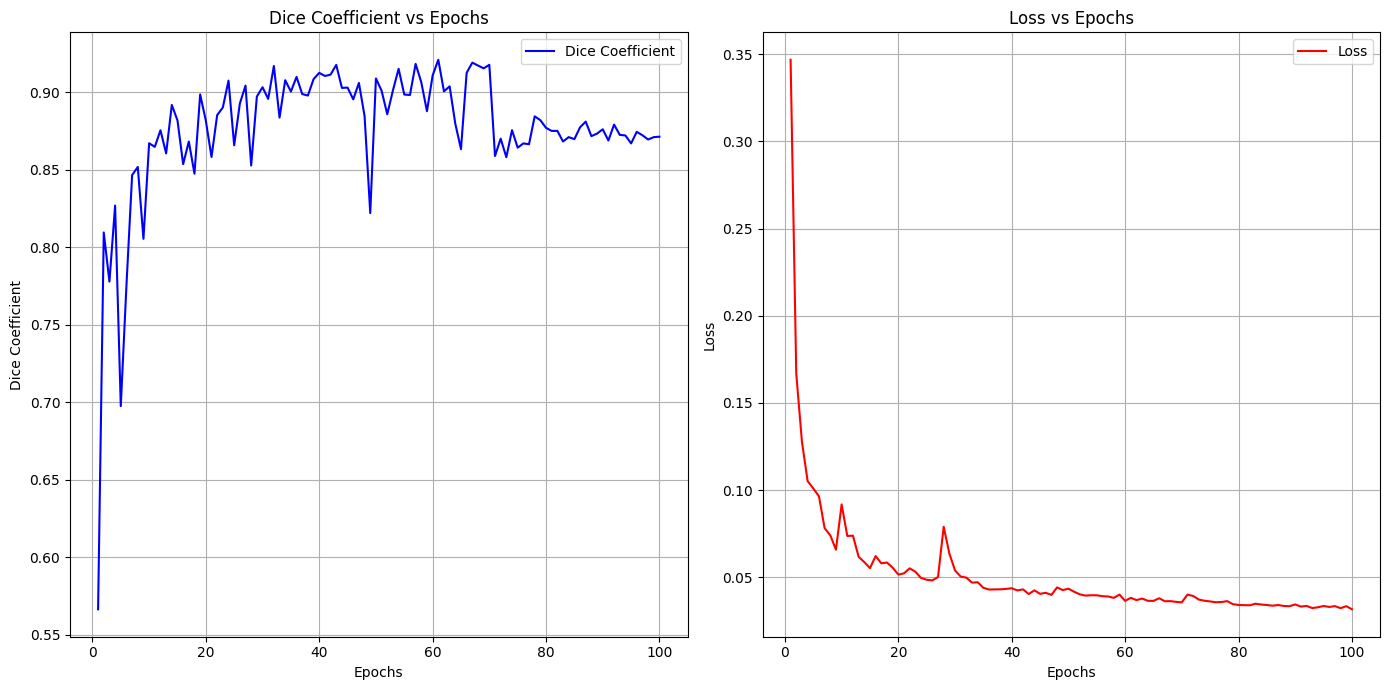

In [18]:
epochs = list(range(1, len(model_results["dice_liver"]) + 1))
plt.figure(figsize=(14, 7))
print(f"max epoch: {model_results['best_epoch']}")
print(f"max dice score: {max(model_results['dice_liver'])}")

# dice
plt.subplot(1, 2, 1)
plt.plot(epochs, model_results["dice_liver"], label='Dice Coefficient', color='blue')
plt.title('Dice Coefficient vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.grid()

#loss
plt.subplot(1, 2, 2)
plt.plot(epochs, model_results["loss"], label='Loss', color='red')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()